In [13]:
import pandas as pd
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import xgboost as xgb
import cupy as cp
import numpy as np
import json

In [1]:
def train_test_split_by_date(x, y, test_size=0.2):
    """
    Split the input data into training and test sets by date.
    The test set should contain the newest test_size proportion of the data.
    """
    df = pd.concat([x, y], axis=1)
    df = df.sort_values(by='author_date_unix_timestamp')
    split_index = int((1 - test_size) * len(df))
    x_train = df.iloc[:split_index, :-1]
    y_train = df.iloc[:split_index, -1]
    x_test = df.iloc[split_index:, :-1]
    y_test = df.iloc[split_index:, -1]
    return x_train, x_test, y_train, y_test


In [39]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

def hyperparameter_optimization(x_train, y_train, n_splits=5, n_trials=50):
    """
    Optimize the hyperparameters of the XGBoost model using cross-validation.

    Parameters:
      - x_train: Training features (pandas DataFrame)
      - y_train: Training labels (pandas Series)
      - n_splits: Number of cross-validation splits (default: 5)
      - n_trials: Number of hyperparameter search trials (default: 50)

    Returns:
      - The best hyperparameters found by Optuna.
    """
    # Convert the entire training set to NumPy arrays once.
    x_train_np = x_train.to_numpy()
    y_train_np = y_train.to_numpy().ravel()

    # Compute class weights based on the entire training set.
    #classes = np.unique(y_train_np)
    #class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_np)
    #class_weight_dict = dict(zip(classes, class_weights))
    #scale_pos_weight = class_weight_dict[0] / class_weight_dict[1]

    # Convert the NumPy arrays to GPU arrays (cupy.ndarray).
    x_train_gpu = cp.asarray(x_train_np)
    y_train_gpu = cp.asarray(y_train_np)

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    def objective(trial):

        # https://xgboosting.com/most-important-xgboost-hyperparameters-to-tune/
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 300), # Number of boosting rounds, 1000 is too much with little no improvement
            'min_child_weight': trial.suggest_float('min_child_weight', 1.0, 7.0, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 9),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
            #'scale_pos_weight': scale_pos_weight,
            'class_weight': 'balanced',
            'random_state': 42,
            'n_jobs': -1
        }

        early_stopping_rounds = 50
        
        cv_scores = []
        # Perform stratified K-fold cross-validation using pre-converted arrays.
        for train_idx, valid_idx in skf.split(x_train_np, y_train_np):
            # Slice the pre-converted GPU arrays.
            X_tr_gpu = x_train_gpu[train_idx]
            y_tr_gpu = y_train_gpu[train_idx]
            X_val_gpu = x_train_gpu[valid_idx]
            # Use the original NumPy array for validation labels.
            y_val = y_train_np[valid_idx]
            
            # Configure and train the model.
            model = XGBClassifier(
                **params,
                early_stopping_rounds=early_stopping_rounds,
                tree_method="hist",  # GPU-optimized training
                device="cuda"        # use GPU for training and prediction
            )
            model.fit(X_tr_gpu,
                        y_tr_gpu,
                        eval_set=[(X_val_gpu, y_val)],
                        verbose=False
                      )
            
            # Predict on the validation fold.
            y_pred_prob = model.predict_proba(X_val_gpu)[:, 1]
            y_pred_cpu = cp.asnumpy(y_pred_prob)
            
            # Compute PR-AUC score for the current fold
            fold_score = average_precision_score(y_val, y_pred_cpu)
            cv_scores.append(fold_score)
        
        # Return the mean ROC AUC across folds.
        return np.mean(cv_scores)
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    # Free GPU memory to clear up space for subsequent computations.
    cp._default_memory_pool.free_all_blocks()

    return study.best_params


from sklearn.ensemble import RandomForestClassifier

def hyperparameter_optimization_rf(x_train, y_train, n_splits=5, n_trials=50):
    """
    Optimize the hyperparameters of the RandomForestClassifier using cross-validation.

    Parameters:
      - x_train: Training features (pandas DataFrame)
      - y_train: Training labels (pandas Series)
      - n_splits: Number of cross-validation splits (default: 5)
      - n_trials: Number of hyperparameter search trials (default: 50)

    Returns:
      - The best hyperparameters found by Optuna.
    """
    # Convert the training data to NumPy arrays
    x_train_np = x_train.to_numpy()
    y_train_np = y_train.to_numpy().ravel()

    # Create stratified K-fold splits
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    def objective(trial):
        # Define hyperparameter search space for RandomForestClassifier
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 20),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
            'class_weight': 'balanced',
            'random_state': 42,
            'n_jobs': -1
        }

        cv_scores = []
        # Iterate through each fold
        for train_idx, valid_idx in skf.split(x_train_np, y_train_np):
            X_tr = x_train_np[train_idx]
            y_tr = y_train_np[train_idx]
            X_val = x_train_np[valid_idx]
            y_val = y_train_np[valid_idx]

            # Initialize and train the model
            model = RandomForestClassifier(**params)
            model.fit(X_tr, y_tr)

            # Predict probabilities and compute ROC AUC score
            y_pred_prob = model.predict_proba(X_val)[:, 1]
            fold_score = average_precision_score(y_val, y_pred_prob)
            cv_scores.append(fold_score)

        # Return the mean ROC AUC across folds
        return np.mean(cv_scores)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    return study.best_params


# balanced random forest
from imblearn.ensemble import BalancedRandomForestClassifier


def hyperparameter_optimization_brf(x_train, y_train, n_splits=5, n_trials=50):
    """
    Optimize the hyperparameters of the RandomForestClassifier using cross-validation.

    Parameters:
      - x_train: Training features (pandas DataFrame)
      - y_train: Training labels (pandas Series)
      - n_splits: Number of cross-validation splits (default: 5)
      - n_trials: Number of hyperparameter search trials (default: 50)

    Returns:
      - The best hyperparameters found by Optuna.
    """
    # Convert the training data to NumPy arrays
    x_train_np = x_train.to_numpy()
    y_train_np = y_train.to_numpy().ravel()

    # Create stratified K-fold splits
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    def objective(trial):
        # Define hyperparameter search space for RandomForestClassifier
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 20),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
            'class_weight': 'balanced',
            'random_state': 42,
            'n_jobs': -1
        }

        cv_scores = []
        # Iterate through each fold
        for train_idx, valid_idx in skf.split(x_train_np, y_train_np):
            X_tr = x_train_np[train_idx]
            y_tr = y_train_np[train_idx]
            X_val = x_train_np[valid_idx]
            y_val = y_train_np[valid_idx]

            # Initialize and train the model
            model = BalancedRandomForestClassifier(**params)
            model.fit(X_tr, y_tr)

            # Predict probabilities and compute ROC AUC score
            y_pred_prob = model.predict_proba(X_val)[:, 1]
            fold_score = average_precision_score(y_val, y_pred_prob)
            cv_scores.append(fold_score)

        # Return the mean ROC AUC across folds
        return np.mean(cv_scores)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    return study.best_params

from sklearn.svm import OneClassSVM

def hyperparameter_optimization_ocsvm(x_train, y_train, n_splits=5, n_trials=50):
    """
    Optimize the hyperparameters of the RandomForestClassifier using cross-validation.

    Parameters:
      - x_train: Training features (pandas DataFrame)
      - y_train: Training labels (pandas Series)
      - n_splits: Number of cross-validation splits (default: 5)
      - n_trials: Number of hyperparameter search trials (default: 50)

    Returns:
      - The best hyperparameters found by Optuna.
    """
    # Convert the training data to NumPy arrays
    x_train_np = x_train.to_numpy()
    y_train_np = y_train.to_numpy().ravel()

    # Create stratified K-fold splits
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    def objective(trial):
        # Define hyperparameter search space for RandomForestClassifier
        params = {
            'nu': trial.suggest_float('nu', 0.01, 0.5),
            'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
            'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
            'degree': trial.suggest_int('degree', 1, 5),
            'coef0': trial.suggest_float('coef0', 0.0, 1.0),
        }

        cv_scores = []
        # Iterate through each fold
        for train_idx, valid_idx in skf.split(x_train_np, y_train_np):
            X_tr = x_train_np[train_idx]
            y_tr = y_train_np[train_idx]
            X_val = x_train_np[valid_idx]
            y_val = y_train_np[valid_idx]

            # Initialize and train the model
            model = OneClassSVM(**params)
            model.fit(X_tr)

            # Predict probabilities and compute ROC AUC score
            y_pred_prob = model.decision_function(X_val)
            fold_score = roc_auc_score(y_val, y_pred_prob)
            cv_scores.append(fold_score)

        # Return the mean ROC AUC across folds
        return np.mean(cv_scores)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    return study.best_params


In [3]:
# all columns in the dataset
INFO_COLUMNS = [
                "class", "type", #"linked", "fileschanged",
                "ndev", "age", "exp", "rexp", "sexp",
                "glm_probability", #"classification",
                "time_of_day", "day_of_week", "is_weekend",
                "author_experience", "author_ownership",
                "hash","file", "author_date_unix_timestamp"]

Y_COLUMN = ['contains_bug']

X_COLUMNS = ["d_cbo","d_cboModified","d_fanin",
             "d_fanout","d_wmc","d_dit","d_noc",
             "d_rfc","d_lcom",#"d_lcom*","d_tcc","d_lcc",
             "d_totalMethodsQty","d_staticMethodsQty",
             "d_publicMethodsQty","d_privateMethodsQty","d_protectedMethodsQty",
             "d_defaultMethodsQty","d_visibleMethodsQty","d_abstractMethodsQty",
             "d_finalMethodsQty","d_synchronizedMethodsQty","d_totalFieldsQty",
             "d_staticFieldsQty","d_publicFieldsQty","d_privateFieldsQty",
             "d_protectedFieldsQty","d_defaultFieldsQty","d_finalFieldsQty",
             "d_synchronizedFieldsQty","d_nosi","d_loc","d_returnQty","d_loopQty",
             "d_comparisonsQty","d_tryCatchQty","d_parenthesizedExpsQty","d_stringLiteralsQty",
             "d_numbersQty","d_assignmentsQty","d_mathOperationsQty","d_variablesQty",
             "d_maxNestedBlocksQty","d_anonymousClassesQty","d_innerClassesQty",
             "d_lambdasQty",
             #"d_uniqueWordsQty",
             "d_modifiers",
             #"d_logStatementsQty",
             "cbo","cboModified","fanin","fanout","wmc","dit","noc","rfc","lcom",#"lcom*","tcc","lcc",
             "totalMethodsQty","staticMethodsQty","publicMethodsQty",
             "privateMethodsQty","protectedMethodsQty","defaultMethodsQty",
             "visibleMethodsQty","abstractMethodsQty","finalMethodsQty",
             "synchronizedMethodsQty","totalFieldsQty","staticFieldsQty",
             "publicFieldsQty","privateFieldsQty","protectedFieldsQty",
             "defaultFieldsQty","finalFieldsQty","synchronizedFieldsQty",
             "nosi","loc","returnQty","loopQty","comparisonsQty",
             "tryCatchQty","parenthesizedExpsQty","stringLiteralsQty",
             "numbersQty","assignmentsQty","mathOperationsQty",
             "variablesQty","maxNestedBlocksQty","anonymousClassesQty",
             "innerClassesQty","lambdasQty",
             #"uniqueWordsQty", # Number of unique words in the source code
             "modifiers",
             #"logStatementsQty", # Number of log statements in the source code
             #"fix",
             "entrophy",
             "la","ld",
             #"net_lines_changed","absolute_lines_changed",
             "lines_per_file",
             "changed_file_count",
             #"entropy_bucket",
             ]

# these columns have NaN values
# so we dont use them for simplicity
NaN_COLUMNS = ["d_lcom*", "d_tcc", "d_lcc", "lcom*", "tcc", "lcc", "classification"]

In [4]:
import pandas as pd
# read the merged df

df = pd.read_csv('merged_datasets/new/tomcat_merged_df.csv')

print(df.shape[0])

126165


In [5]:
# print column which has missing values
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])


d_lcom*            6607
d_tcc             22281
d_lcc             22281
lcom*              6589
tcc               22114
lcc               22114
classification    59600
dtype: int64


In [6]:
#print distinc values in tcc column
print(df['tcc'].unique())
# and their counts
print(df['tcc'].value_counts())

# print nan count
print(df['tcc'].isnull().sum())

[-1.  0. nan]
tcc
 0.0    93641
-1.0    10410
Name: count, dtype: int64
22114


# DECISON
should we delete columns with possible N/A values or delete rows with N/A values ? 

if number of visible methods in a class is less than 2, then CK prefers to set it -1.
For some reason, some rows have NaN values, so set it to -1 as well as it is not applicable.

In [7]:
def fix_df(df):
    """
    XGBoost supports missing values, so we don't need to impute them.
    """

    return df



    # Handle NA values
    """
    df['d_lcom*'] = df['d_lcom*'].fillna(-1)
    df['d_tcc'] = df['d_tcc'].fillna(-1)
    df['d_lcc'] = df['d_lcc'].fillna(-1)
    df['lcom*'] = df['lcom*'].fillna(-1)
    df['tcc'] = df['tcc'].fillna(-1)
    df['lcc'] = df['lcc'].fillna(-1)
    """
    # drop these columns
    # remove from X_COLUMNS
    
    try:
        X_COLUMNS.remove('d_lcom*')
        X_COLUMNS.remove('lcom*')
        X_COLUMNS.remove('d_tcc')
        X_COLUMNS.remove('tcc')
        X_COLUMNS.remove('d_lcc')
        X_COLUMNS.remove('lcc')
    except:
        # already removed
        pass
    
    df = df.drop(columns=['d_lcom*', 'lcom*', 'd_tcc', 'tcc', 'd_lcc', 'lcc'])
    return df

df = fix_df(df)

In [8]:
from openpyxl import Workbook
from openpyxl.styles import Font, PatternFill
from openpyxl.utils import get_column_letter
from openpyxl.formatting.rule import ColorScaleRule

def write_formatted_report(ws, df, start_row, start_col):
    """
    Writes the DataFrame `df` into worksheet `ws` starting at (start_row, start_col).
    
    - The header row is formatted with bold text and a light gray fill.
    - For any row whose first cell (the "class" column) equals "accuracy"
      (case-insensitive), the function writes:
         • The label "accuracy" in the first column.
         • The accuracy value (assumed to be in the second value of the row)
           into the cell corresponding to the "f1-score" header.
         • All other numeric cells (except the support column) are left blank.
         • The "support" column (if present) is left unchanged.
    - After writing the table, a conditional color–scale is applied to all 
      numeric cells (i.e. all cells except the first "class" column and the 
      "support" column). Also, any empty cell in that range is cleared of fill.
      
    Float values are formatted with two decimals.
    
    Returns the total number of rows written (header + data).
    """
    header_font = Font(bold=True)
    header_fill = PatternFill(start_color="D9D9D9", end_color="D9D9D9", fill_type="solid")
    
    headers = list(df.columns)
    num_cols = len(headers)
    total_rows = df.shape[0] + 1  # header + data rows

    # Write the header row.
    for j, col_name in enumerate(headers, start=start_col):
        cell = ws.cell(row=start_row, column=j, value=col_name)
        cell.font = header_font
        cell.fill = header_fill

    # Write data rows.
    for i, row_data in enumerate(df.values, start=start_row + 1):
        # Check if this is the "accuracy" row.
        if str(row_data[0]).strip().lower() == "accuracy":
            # Write the "accuracy" label in the first column.
            ws.cell(row=i, column=start_col, value=row_data[0])
            # Find the column index for "f1-score" (case-insensitive) in headers.
            f1_idx = None
            for idx, h in enumerate(headers):
                if h.strip().lower() == "f1-score":
                    f1_idx = idx
                    break
            # Write the accuracy value into the "f1-score" column.
            if f1_idx is not None and len(row_data) > 1:
                accuracy_value = row_data[1]  # assume the accuracy value is in the second column
                cell = ws.cell(row=i, column=start_col + f1_idx, value=accuracy_value)
                if isinstance(accuracy_value, float):
                    cell.number_format = "0.00"
            # For the remaining columns:
            for j, h in enumerate(headers[1:], start=start_col + 1):
                # Skip the f1-score column (already written) and the support column.
                if (f1_idx is not None and j == start_col + f1_idx) or h.strip().lower() == "support":
                    continue
                ws.cell(row=i, column=j, value="")
        else:
            # Normal row: write each cell value.
            for j, value in enumerate(row_data, start=start_col):
                cell = ws.cell(row=i, column=j, value=value)
                if isinstance(value, float):
                    cell.number_format = "0.00"
    
    # Determine the range for numeric cells to apply conditional formatting.
    # We want to apply formatting to all numeric columns except:
    #   - the first column ("class")
    #   - the "support" column (if present)
    #
    # Find the index of "support" in headers (if it exists).
    support_idx = None
    for idx, h in enumerate(headers):
        if h.strip().lower() == "support":
            support_idx = idx
            break
    numeric_start_col = start_col + 1  # skip "class"
    if support_idx is not None:
        # Apply formatting to columns before the support column.
        numeric_end_col = start_col + support_idx - 1  # excludes the support column
    else:
        numeric_end_col = start_col + num_cols - 1

    numeric_start_row = start_row + 1
    numeric_end_row = start_row + df.shape[0]
    # Build range string (e.g. "B2:D10").
    cell_range = f"{get_column_letter(numeric_start_col)}{numeric_start_row}:{get_column_letter(numeric_end_col)}{numeric_end_row}"
    
    # Define a color scale: low values in red, mid in yellow, high in green.
    color_scale_rule = ColorScaleRule(
        start_type="num", start_value=0, start_color="F8696B",
        mid_type="num", mid_value=0.5, mid_color="FFEB84",
        end_type="num", end_value=1, end_color="63BE7B"
    )
    ws.conditional_formatting.add(cell_range, color_scale_rule)
    
    # Remove fill from any empty cells in the numeric range.
    for row in ws[cell_range]:
        for cell in row:
            if cell.value in [None, ""]:
                cell.fill = PatternFill(fill_type=None)
    
    return total_rows

###############################################################################
# Main export function.
###############################################################################
def export_results_to_excel(results, output_file):
    """
    Groups the classification reports (from the global dict `results`) by dataset
    and writes them all into a single worksheet.
    
    For each dataset, the random-split and date-split reports are written side by side,
    with a title row above each table (e.g. "Dataset1 random split" and "Dataset1 date split").
    Each dataset block is written on a new set of rows (separated by a blank gap).
    
    Finally, the workbook is saved to `output_file`.
    """
    # Group the reports by dataset name.
    # Expected keys: "<dataset_name>_random_split" and "<dataset_name>_date_split"
    grouped_results = {}
    for key, report in results.items():
        try:
            ds_name, split_type, _ = key.rsplit("_", 2)
        except ValueError:
            continue
        if ds_name not in grouped_results:
            grouped_results[ds_name] = {}
        grouped_results[ds_name][split_type] = report

    # Create a new workbook with one worksheet.
    wb = Workbook()
    ws = wb.active
    ws.title = "Classification Reports"
    
    current_row = 1  # starting row on the sheet
    gap_rows = 2     # blank rows between dataset blocks

    for ds_name, splits in grouped_results.items():
        # Convert the reports into DataFrames.
        if "random" in splits:
            df_random = pd.DataFrame(splits["random"]).T.reset_index().rename(columns={"index": "class"})
        else:
            df_random = None

        if "date" in splits:
            df_date = pd.DataFrame(splits["date"]).T.reset_index().rename(columns={"index": "class"})
        else:
            df_date = None

        # Determine starting column for the date table.
        if df_random is not None:
            left_table_cols = df_random.shape[1]
        else:
            left_table_cols = 0
        date_table_start_col = left_table_cols + 3 if df_random is not None else 1

        # Write title cells above each table.
        ws.cell(row=current_row, column=1, value=f"{ds_name} random split")
        ws.cell(row=current_row, column=date_table_start_col, value=f"{ds_name} date split")

        # Write the tables starting on the next row.
        start_table_row = current_row + 1
        rows_random = 0
        rows_date = 0
        if df_random is not None:
            rows_random = write_formatted_report(ws, df_random, start_table_row, 1)
        if df_date is not None:
            rows_date = write_formatted_report(ws, df_date, start_table_row, date_table_start_col)

        # Determine block height (title row + maximum table height).
        block_height = 1 + max(rows_random, rows_date)
        current_row += block_height + gap_rows

    wb.save(output_file)
    print(f"Workbook saved as {output_file}")


In [9]:
from sklearn.feature_selection import SelectFromModel
from mrmr import mrmr_classif

def select_features(x, y, method="model", estimator=None, threshold="median", 
                    correlation_threshold=0.9, num_features=50):
    """
    Select features using different methods.

    Parameters:
      - x: Training features (pandas DataFrame)
      - y: Training labels (pandas Series)
      - method: Which feature selection method to use.
                Options are:
                  "model" : Model-based feature selection using SelectFromModel.
                  "cbfs"  : Correlation-based feature selection (CBFS).
                  "mrmr"  : Minimum Redundancy Maximum Relevance (MRMR) using mrmr_selection.
      - estimator: (For "model" method) An estimator to compute feature importances.
                   If None, an XGBClassifier is used.
      - threshold: (For "model" method) The threshold for feature importance in SelectFromModel.
                   Default is "median".
      - correlation_threshold: (For "cbfs" method) Threshold to drop highly correlated features.
      - num_features: (For "mrmr" method) Number of features to select.
      
    Returns:
      - A list of selected feature names.
    """
    method = method.lower()
    if method == "model":
        if estimator is None:
            estimator = XGBClassifier(tree_method="hist", device="cuda", random_state=42)
        estimator.fit(x, y)
        selector = SelectFromModel(estimator, threshold=threshold, prefit=True)
        selected_features = list(x.columns[selector.get_support()])
        return selected_features

    elif method == "cbfs":
        # Compute the absolute correlation matrix and remove one of any pair of highly correlated features.
        corr_matrix = x.corr().abs()
        # Use only the upper triangle of the correlation matrix.
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        to_drop = [column for column in upper.columns if any(upper[column] > correlation_threshold)]
        selected_features = [col for col in x.columns if col not in to_drop]
        return selected_features

    elif method == "mrmr":
        # Call mrmr_classif directly with the DataFrame (not x.values) so that it can access the column names.
        selected_features = mrmr_classif(x, y, K=num_features)
        return selected_features

    else:
        raise ValueError("Method must be one of 'model', 'cbfs', or 'mrmr'")

In [10]:
results = {}
best_param_dict = {}

In [42]:
from sklearn.preprocessing import MinMaxScaler

def main(result_prefix: str, feature_selection_method="mrmr", n_features = 50, n_splits=5, n_trials=50, correlation_threshold=0.9):


    for dataset in DATASETS:

        dataset_name = dataset.split("new")[1][1:]

        CP = DATASETS

        for processed in results.keys():
            if dataset_name in processed:
                continue        

        print(f"Processing {dataset_name}")
        df = pd.read_csv(dataset)
        df = fix_df(df)

        df = pd.DataFrame()
        # read all datasets in CP into single df
        for cp_dataset in CP:
            print(cp_dataset)
            cp_df = pd.read_csv(cp_dataset)
            cp_df = fix_df(cp_df)
            df = pd.concat([df, cp_df])


        """
        TODO
        - It might not be best to split the dataset here. We should split the dataset in the hyperparameter optimization step.
        - We should also perform feature selection in the hyperparameter optimization step. MAYBE ???
        """
        

        # -------------------------
        # Random split approach
        # -------------------------
        x_train, x_test, y_train, y_test = train_test_split(df[X_COLUMNS + INFO_COLUMNS], df[Y_COLUMN],
                                                            test_size=0.2, random_state=42)
        
        # Scale after split to avoid leakage
        scaler = MinMaxScaler()
        x_train[X_COLUMNS] = scaler.fit_transform(x_train[X_COLUMNS])
        x_test[X_COLUMNS] = scaler.transform(x_test[X_COLUMNS])


        # Perform feature selection on the training set using only X_COLUMNS
        selected_features_random = select_features(x_train[X_COLUMNS], y_train,
                                                   method=feature_selection_method, num_features=n_features, correlation_threshold=correlation_threshold)
        print(f"Selected features for {dataset_name} (random split): {selected_features_random}")

        # Optimize hyperparameters on the selected features
        best_params = hyperparameter_optimization(x_train[selected_features_random], y_train, n_splits=n_splits, n_trials=n_trials)
        best_model = XGBClassifier(**best_params, tree_method="hist", device="cuda")
        best_model.fit(x_train[selected_features_random], y_train)
        y_pred = best_model.predict(x_test[selected_features_random])
        results[f"{dataset_name}_random_split"] = classification_report(y_test, y_pred, output_dict=True)
        best_param_dict[f"{dataset_name}_random_split"] = best_params

        # -------------------------
        # Date split approach
        # -------------------------

        # Lets not use first %20(time) of the dataset
        # as the project evolves over time
        # we will use remaining %80 percent as training + test set 

        """df_trimmed = df.sort_values(by='author_date_unix_timestamp').iloc[int(df.shape[0]*0.2):]

        ########################experimental"""
        
        x_train_date, x_test_date, y_train_date, y_test_date = train_test_split_by_date(
            df[X_COLUMNS + INFO_COLUMNS], df[Y_COLUMN], test_size=0.2)
        
        # Scale splits
        x_train_date[X_COLUMNS] = scaler.fit_transform(x_train_date[X_COLUMNS])
        x_test_date[X_COLUMNS] = scaler.transform(x_test_date[X_COLUMNS])

        selected_features_date = select_features(x_train_date[X_COLUMNS], y_train_date,
                                                 method=feature_selection_method, num_features=n_features, correlation_threshold=correlation_threshold)
        print(f"Selected features for {dataset_name} (date split): {selected_features_date}")

        best_params = hyperparameter_optimization(x_train_date[selected_features_date], y_train_date, n_splits=n_splits, n_trials=n_trials)
        best_model = XGBClassifier(**best_params, tree_method="hist", device="cuda")
        best_model.fit(x_train_date[selected_features_date], y_train_date)
        y_pred = best_model.predict(x_test_date[selected_features_date])
        results[f"{dataset_name}_date_split"] = classification_report(y_test_date, y_pred, output_dict=True)
        best_param_dict[f"{dataset_name}_date_split"] = best_params

        #####
        break

    # Export the classification reports to Excel.
    export_results_to_excel(results, output_file=f"{result_prefix}_classification_reports.xlsx")

    # save best params as json
    with open(f'{result_prefix}_best_params.json', 'w') as f:
        json.dump(best_param_dict, f)

In [12]:
DATASETS = ["merged_datasets/new/broadleaf_merged_df.csv",
            "merged_datasets/new/camel_merged_df.csv",
            "merged_datasets/new/dubbo_merged_df.csv",
            "merged_datasets/new/elasticsearch_merged_df.csv",
            "merged_datasets/new/guava_merged_df.csv",
            "merged_datasets/new/jdk_merged_df.csv",
            "merged_datasets/new/jgroups_merged_df.csv",
            "merged_datasets/new/kafka_merged_df.csv",
            "merged_datasets/new/spark_merged_df.csv",
            "merged_datasets/new/spring-boot_merged_df.csv",
            "merged_datasets/new/spring-framework_merged_df.csv",
            "merged_datasets/new/tomcat_merged_df.csv",
            ]

In [36]:
# data cleaning

import pandas as pd
import numpy as np

def clean_rule_0(df):
    """
    Rule 0:
    Exclude duplicate rows.

    Parameters:
      df : Input DataFrame.

    Returns:
      A DataFrame with duplicate rows removed.
    """
    df = df.copy()
    init_len = df.shape[0]
    df.drop_duplicates(inplace=True)
    print(f"Rule 0: Dropping {init_len - df.shape[0]} rows.")
    return df

def clean_rule_1(df, gap):
    """
    Rule 1:
    Exclude a class change row (c1) if the same class is later deleted (c2) 
    and the time difference (c2.time - c1.time) is less than the specified gap.
    
    Assumes:
      - A column 'class' uniquely identifies a class.
      - A column 'author_date_unix_timestamp' gives the commit time.
      - A column 'type' whose value 'deleted' (case-insensitive) indicates deletion.
    
    Parameters:
      df  : Input DataFrame.
      gap : Time gap threshold (same unit as author_date_unix_timestamp).
    
    Returns:
      A DataFrame with the rows meeting this rule removed.
    """
    df = df.copy()
    indices_to_drop = []
    # Process each class separately.
    for cls, group in df.groupby('class'):
      group_sorted = group.sort_values('author_date_unix_timestamp')
      indices = group_sorted.index.tolist()
      for i in range(len(indices) - 1):
        c1_idx = indices[i]
        c2_idx = indices[i + 1]
        # Convert datetime strings to timestamps for comparison
        c1_time = pd.to_datetime(df.loc[c1_idx, 'author_date_unix_timestamp']).timestamp()
        c2_time = pd.to_datetime(df.loc[c2_idx, 'author_date_unix_timestamp']).timestamp()
        time_diff = c2_time - c1_time
        # If next commit is a deletion and time difference is too short.
        if str(df.loc[c2_idx, 'type']).lower() == 'deleted' and time_diff < gap:
          indices_to_drop.append(c1_idx)

    print(f"Rule 1: Dropping {len(indices_to_drop)} rows.")

    return df.drop(index=indices_to_drop)
    

def clean_rule_2(df, gap):
    """
    Rule 2:
    Exclude a class change row if it is the last change for its class, it is labeled as 'clean',
    and the time difference between the project’s last commit and this change is less than gap.
    
    Assumes:
      - A column 'classification' holds labels (e.g. 'clean').
      - 'author_date_unix_timestamp' is used for time.
    
    Parameters:
      df  : Input DataFrame.
      gap : Time gap threshold.
      
    Returns:
      A DataFrame with the flagged rows removed.
    """
    df = df.copy()
    project_last_time = pd.to_datetime(df['author_date_unix_timestamp'].max()).timestamp()
    indices_to_drop = []
    for cls, group in df.groupby('class'):
        group_sorted = group.sort_values('author_date_unix_timestamp')
        last_idx = group_sorted.index[-1]
        # Check if the last change is labeled as clean.
        if str(df.loc[last_idx, 'contains_bug']).lower() == 'false':
            time_diff = project_last_time - pd.to_datetime(df.loc[last_idx, 'author_date_unix_timestamp']).timestamp()
            if time_diff < gap:
                indices_to_drop.append(last_idx)

    print(f"Rule 2: Dropping {len(indices_to_drop)} rows.")
    return df.drop(index=indices_to_drop)

def clean_rule_3(df):
    """
    Rule 3:
    Exclude a class change if the resulting class does not contain any local (non-inherited)
    methods or attributes.
    
    Heuristic:
      - Checks that at least one of 'totalMethodsQty' or 'totalFieldsQty' is greater than zero.
    
    Parameters:
      df : Input DataFrame.
      
    Returns:
      A DataFrame with rows removed if both counts are 0.
    """
    df = df.copy()
    if {'totalMethodsQty', 'totalFieldsQty'}.issubset(df.columns):
        mask = (df['totalMethodsQty'] > 0) | (df['totalFieldsQty'] > 0)
        print(f"Rule 3: Dropping {df.shape[0] - mask.sum()} rows.")
        return df[mask]
    return df

def clean_rule_4(df):
    """
    Rule 4:
    Exclude a class change if the only local methods present are getter or setter methods.
    
    Heuristic:
      - In absence of explicit method names, we assume that if the class complexity is extremely low 
        (e.g. very low WMC and RFC) despite having some methods, it may only contain trivial accessor methods.
      - Here we drop rows where 'totalMethodsQty' > 0 but both 'wmc' and 'rfc' are <= 1.
    
    Parameters:
      df : Input DataFrame.
      
    Returns:
      A DataFrame with such rows removed.
    """
    df = df.copy()
    if {'totalMethodsQty', 'wmc', 'rfc'}.issubset(df.columns):
        mask = ~((df['totalMethodsQty'] > 0) & (df['wmc'] <= 1) & (df['rfc'] <= 1))
        print(f"Rule 4: Dropping {df.shape[0] - mask.sum()} rows.")
        return df[mask]
    return df

def clean_rule_5(df):
    """
    Rule 5:
    Exclude a class change if no lines were added (la == 0).
    
    Assumes:
      - Column 'la' represents the number of lines added.
      
    Parameters:
      df : Input DataFrame.
      
    Returns:
      A DataFrame with rows having la == 0 removed.
    """
    df = df.copy()
    if 'la' in df.columns:
        print(f"Rule 5: Dropping {df['la'].eq(0).sum()} rows.")
        return df[df['la'] > 0]
    return df

def clean_rule_6(df):
  """
  Rule 6:
  Exclude a class change if only comment lines were changed.
  
  Heuristic:
    - Assume that all difference metrics (columns starting with 'd_') are 0 when only comments change.
  
  Parameters:
    df : Input DataFrame.
    
  Returns:
    A DataFrame with rows where the sum of all d_* metrics is 0 removed.
  """
  df = df.copy()
  d_cols = [col for col in df.columns if col.startswith('d_')]
  if d_cols:
    # Check if all d_* columns are 0 for each row
    mask = ~df[d_cols].eq(0).all(axis=1)
    print(f"Rule 6: Dropping {df.shape[0] - mask.sum()} rows.")
    return df[mask]
  return df

def clean_rule_7(df, min_change):
    """
    Rule 7:
    Exclude a class change if only local (non-inherited) getter or setter methods are added or deleted.
    
    Heuristic:
      - In absence of explicit getter/setter identification, we assume that if the overall line change 
        (la + ld) is very minimal yet there is a change in method counts, then the change might be trivial.
    
    Parameters:
      df        : Input DataFrame.
      min_change: Minimum total lines changed to consider the change substantial.
      
    Returns:
      A DataFrame with rows meeting this heuristic removed.
    """
    df = df.copy()
    if {'la', 'ld', 'd_totalMethodsQty'}.issubset(df.columns):
        # Exclude rows where the sum of added and deleted lines is less than min_change and there is a non-zero change in methods.
        mask = ~(((df['la'] + df['ld']) < min_change) & (df['d_totalMethodsQty'] != 0))
        print(f"Rule 7: Dropping {df.shape[0] - mask.sum()} rows.")
        return df[mask]
    return df

def clean_rule_8(df):
    """
    Rule 8:
    Exclude a class change if the file name ends with 'Type' or 'Exception'.
    
    Assumes:
      - A column 'file' contains the file name (with extension).
      - The check is performed on the base name (without extension).
    
    Parameters:
      df : Input DataFrame.
      
    Returns:
      A DataFrame with rows removed where the file name (without extension) ends with 'Type' or 'Exception'.
    """
    df = df.copy()
    if 'file' in df.columns:
        def file_filter(fname):
            base = fname.split('.')[0].strip()
            return not (base.endswith("Type") or base.endswith("Exception"))
        mask = df['file'].apply(file_filter)
        print(f"Rule 8: Dropping {df.shape[0] - mask.sum()} rows.")
        return df[mask]
    return df

def clean_rule_9(df):
    """
    Rule 9:
    Exclude a class change if the class appears to be dead code,
    meaning that after the change its methods are no longer called.
    
    Heuristic:
      - For example, if 'cbo' (coupling) and 'fanin' (number of callers) are both 0,
        then the class’s methods are likely never used.
    
    Parameters:
      df : Input DataFrame.
      
    Returns:
      A DataFrame with rows removed that meet the heuristic.
    """
    df = df.copy()
    if {'cbo', 'fanin'}.issubset(df.columns):
        mask = ~((df['cbo'] == 0) & (df['fanin'] == 0))
        print(f"Rule 9: Dropping {df.shape[0] - mask.sum()} rows.")
        return df[mask]
    return df

def clean_rule_10(df):
    """
    Rule 10:
    Exclude a class change if the class corresponds to a data class or a class 
    whose methods only delegate to other classes.
    
    Heuristic:
      - A data class might be characterized by extremely low complexity (low 'wmc' and 'rfc')
        yet have a non-zero number of fields.
    
    Parameters:
      df : Input DataFrame.
      
    Returns:
      A DataFrame with rows removed that likely correspond to data classes.
    """
    df = df.copy()
    if {'wmc', 'rfc', 'totalFieldsQty'}.issubset(df.columns):
        mask = ~((df['wmc'] <= 1) & (df['rfc'] <= 1) & (df['totalFieldsQty'] >= 1))
        print(f"Rule 10: Dropping {df.shape[0] - mask.sum()} rows.")
        return df[mask]
    return df

def clean_rule_11(df):
    """
    Rule 11:
    Exclude a class change if both la (lines added) and ld (lines deleted) are 0,
    suggesting that only the file path (or name) changed.
    
    Assumes:
      - Columns 'la' and 'ld' exist.
      
    Parameters:
      df : Input DataFrame.
      
    Returns:
      A DataFrame with rows removed where la == 0 and ld == 0.
    """
    df = df.copy()
    if {'la', 'ld'}.issubset(df.columns):
        mask = ~((df['la'] == 0) & (df['ld'] == 0))
        print(f"Rule 11: Dropping {df.shape[0] - mask.sum()} rows.")
        return df[mask]
    return df

def clean_rule_12(df, threshold):
    """
    Rule 12:
    Exclude a class change if the overall change is too marginal.
    
    Heuristic:
      - Sum all absolute differences from columns starting with 'd_'.
      - If the total change is above a given threshold, consider the change too marginal.
    
    Parameters:
      df        : Input DataFrame.
      threshold : Maximum total change allowed.
      
    Returns:
      A DataFrame with rows having total d_* change above the threshold removed.
    """
    df = df.copy()
    d_cols = [col for col in df.columns if col.startswith('d_')]
    if d_cols:
        total_change = df[d_cols].abs().sum(axis=1)
        mask = (total_change <= threshold) | (df['contains_bug'] == True)
        print(f"Rule 12: Dropping {df.shape[0] - mask.sum()} rows.")
        return df[mask]
    return df

def clean_rule_13(df, threshold):
    """
    Rule 13:
    Exclude a class change if the overall change is too minimal.
    
    Heuristic:
      - Sum all absolute differences from columns starting with 'd_'.
      - If the total change is below a given threshold, consider the change too minimal.
    
    Parameters:
      df        : Input DataFrame.
      threshold : Minimum total change required.
      
    Returns:
      A DataFrame with rows having total d_* change below the threshold removed.
    """
    df = df.copy()
    d_cols = [col for col in df.columns if col.startswith('d_')]
    if d_cols:
        total_change = df[d_cols].abs().sum(axis=1)
        mask = (total_change >= threshold) | (df['contains_bug'] == True)
        print(f"Rule 12: Dropping {df.shape[0] - mask.sum()} rows.")
        return df[mask]
    return df


def clean_rule_14(df, threshold):
    """
    Rule 13:
    Exclude a class change if the commit changed too many files
    
    
    Parameters:
      df        : Input DataFrame.
      threshold : Minimum total change required.
      
    Returns:
      A DataFrame with rows having less than threshold changed files removed.
    """
    df = df.copy()
    #mask = df['changed_file_count'] <= threshold
    mask = (df['changed_file_count'] <= threshold) | (df['contains_bug'] == True)
    print(f"Rule 14: Dropping {df.shape[0] - mask.sum()} rows.")
    return df[mask]

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

def clean_rule_cluster(df, threshold, commit_hash_col='hash', 
                       x_columns=X_COLUMNS, info_columns=INFO_COLUMNS, y_column=Y_COLUMN, 
                       cluster_features=None):
    """
    For commits with changed_file_count above a threshold, reduce the number of rows by splitting
    the commit rows into groups via clustering. The target number of groups is the average
    changed_file_count of commits that are below the threshold.
    
    Parameters:
      df              : Input DataFrame. Must include columns `changed_file_count` and commit_hash_col.
      threshold       : The threshold for changed_file_count.
      commit_hash_col : Column name that identifies a commit (default 'hash').
      x_columns     : List of feature column names.
      info_columns  : List of additional info column names.
      y_column      : List of label column names. Can be a list or a single column name.
      cluster_features: List of column names to use for clustering. 
                        If None, use x_columns (excluding 'changed_file_count').
                        
    Returns:
      A new DataFrame where commits with a high changed_file_count have been reduced to a number
      of rows equal to the average changed_file_count of commits below threshold, while preserving
      the features, info, and labels.
    """
    df = df.copy()
    
    # Split data into two groups: commits with changed_file_count below/equal and above the threshold.
    df_below = df[df['changed_file_count'] <= threshold]
    df_above = df[df['changed_file_count'] > threshold]
    
    # Compute average changed_file_count for commits below threshold (rounded to nearest int)
    if not df_below.empty:
        avg_count = int(round(df_below['changed_file_count'].mean()))
    else:
        avg_count = 1
    avg_count = max(avg_count, 1)  # Ensure at least one cluster/group

    # Determine default columns for clustering if not provided.
    if cluster_features is None:
        if x_columns is None:
            raise ValueError("Either cluster_features or x_columns must be provided.")
        # Use x_columns but remove 'changed_file_count' if present.
        cluster_features = [col for col in x_columns if col != 'changed_file_count']

    # For storing processed commits from the above-threshold group.
    reduced_rows = []

    # Process each commit in the above-threshold group.
    for commit, group in df_above.groupby(commit_hash_col):
        # If the number of rows is already less than or equal to avg_count, keep them as is.
        if group.shape[0] <= avg_count:
            reduced_rows.append(group)
        else:
            # For clustering, drop rows with missing values in the cluster features.
            group_for_cluster = group.dropna(subset=cluster_features)
            if group_for_cluster.shape[0] < avg_count:
                # If too few rows remain after dropping NaNs, use the original group.
                reduced_rows.append(group)
                continue

            # Cluster the rows into avg_count clusters.
            try:
                kmeans = KMeans(n_clusters=avg_count, random_state=42)
                clusters = kmeans.fit_predict(group_for_cluster[cluster_features])
            except Exception as e:
                print(f"Clustering failed for commit {commit}: {e}")
                reduced_rows.append(group)
                continue

            group_for_cluster = group_for_cluster.copy()
            group_for_cluster['cluster'] = clusters

            # Build aggregation functions for each column.
            agg_funcs = {}
            for col in group_for_cluster.columns:
                if col in [commit_hash_col, 'cluster']:
                    agg_funcs[col] = 'first'
                elif x_columns is not None and col in x_columns:
                    # For feature columns, if numeric, average; else, take first.
                    if pd.api.types.is_numeric_dtype(group_for_cluster[col]):
                        agg_funcs[col] = 'mean'
                    else:
                        agg_funcs[col] = 'first'
                elif info_columns is not None and col in info_columns:
                    # For info columns, assume consistency and take the first value.
                    agg_funcs[col] = 'first'
                elif y_column is not None and ((isinstance(y_column, list) and col in y_column) or (col == y_column)):
                    agg_funcs[col] = 'first'
                elif col == 'changed_file_count':
                    agg_funcs[col] = 'mean'
                else:
                    # For any other column, if numeric, take mean; otherwise, take the first occurrence.
                    if pd.api.types.is_numeric_dtype(group_for_cluster[col]):
                        agg_funcs[col] = 'mean'
                    else:
                        agg_funcs[col] = 'first'

            # Aggregate by cluster.
            aggregated = group_for_cluster.groupby('cluster').agg(agg_funcs).reset_index(drop=True)
            reduced_rows.append(aggregated)
    
    # Combine the reduced commits with those below threshold.
    result_df = pd.concat([df_below] + reduced_rows, ignore_index=True)
    
    print(f"Rule clustering: Dropping {df_above.shape[0] - result_df.shape[0]} rows.")
    return result_df


# Example of combining the cleaning steps
def clean_dataset(df, gap_rule1=3600*24*2, gap_rule2=3600*24*7*4, min_change_rule7=10, minimal_threshold = 15, marginal_threshold=250, changed_file_threshold=10):
    """
    Apply all cleaning rules in sequence.
    
    Parameters:
      df                : Input DataFrame.
      gap_rule1, gap_rule2: Time gap thresholds for rules 1 and 2.
      min_change_rule7  : Minimum line change for rule 7.
      marginal_threshold: Threshold for marginal change (rule 12).
      
    Returns:
      Cleaned DataFrame.
    """
    init_len = df.shape[0]

    df_clean = df.copy()
    df_clean = clean_rule_0(df_clean)
    
    #df_clean = clean_rule_1(df_clean, gap_rule1) # 2 days 
    df_clean = clean_rule_2(df_clean, gap_rule2) # a month
    df_clean = clean_rule_3(df_clean)
    df_clean = clean_rule_4(df_clean)#
    df_clean = clean_rule_5(df_clean)
    df_clean = clean_rule_6(df_clean)
    df_clean = clean_rule_7(df_clean, min_change=min_change_rule7)
    df_clean = clean_rule_8(df_clean)
    df_clean = clean_rule_9(df_clean)
    df_clean = clean_rule_10(df_clean)
    df_clean = clean_rule_11(df_clean)
    #df_clean = clean_rule_12(df_clean, threshold=marginal_threshold)
    #df_clean = clean_rule_13(df_clean, threshold=minimal_threshold)
    #df_clean = clean_rule_14(df_clean, threshold=changed_file_threshold)

    df_clean = clean_rule_cluster(df_clean, threshold=changed_file_threshold)

    print(f"Initial rows: {init_len}, Final rows: {df_clean.shape[0]}")

    return df_clean


def get_cleaned_data(x_df, y_df, gap_rule1=3600*24*2, gap_rule2=3600*24*7*4, min_change_rule7=10, minimal_threshold = 15, marginal_threshold=250, changed_file_threshold=10):
  """
  Clean the input dataframes and return cleaned versions.
  
  Parameters:
    x_df              : Features DataFrame
    y_df              : Target Series 
    gap_rule1         : Time gap threshold for rule 1 (in seconds)
    gap_rule2         : Time gap threshold for rule 2 (in seconds)
    min_change_rule7  : Minimum line change for rule 7
    marginal_threshold: Threshold for marginal change (rule 12)
    
  Returns:
    (cleaned_x_df, cleaned_y_df): Tuple of cleaned DataFrames
  """
  # Merge x_df and y_df into a single dataframe 
  merged_df = pd.concat([x_df, y_df], axis=1)
  
  # Clean the merged dataframe
  cleaned_df = clean_dataset(merged_df, gap_rule1, gap_rule2, min_change_rule7, minimal_threshold, marginal_threshold, changed_file_threshold)
  
  # Split back into features and target
  cleaned_x_df = cleaned_df[x_df.columns]
  cleaned_y_df = cleaned_df[y_df.name]
  
  return cleaned_x_df, cleaned_y_df



In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_distribution(df):
  """
  Plot the distribution of columns in the DataFrame.
  
  Parameters:
    df : Input DataFrame.
  """
  # Select rows where all d_* columns are 0
  d_cols = [col for col in df.columns if col.startswith('d_')]
  mask = df[d_cols].eq(0).all(axis=1)
  df_zero_diff = df[mask]
  
  # Configure plot style and size
  plt.style.use('default')
  plt.figure(figsize=(15, 5))
  
  # Plot the distribution of each column
  for col in X_COLUMNS:
    if col.startswith('d_'):
      continue
      
    # Create new figure for each plot
    plt.figure(figsize=(10, 6))
    
    # Create histogram with density plot
    sns.histplot(data=df_zero_diff[col], bins=100, kde=True)
    
    # Customize plot
    plt.title(f'Distribution of {col} (when no changes)', fontsize=12)
    plt.xlabel(col, fontsize=10)
    plt.ylabel('Count', fontsize=10)
    plt.xticks(rotation=45)
    
    # Add grid
    plt.grid(True, alpha=0.3)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Show plot
    plt.show()

<Figure size 1500x500 with 0 Axes>

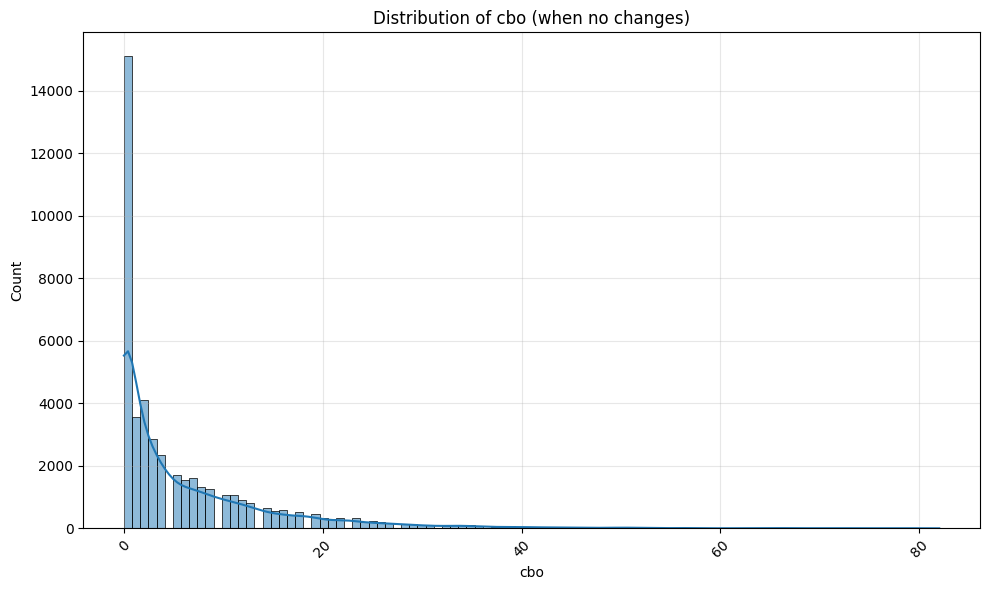

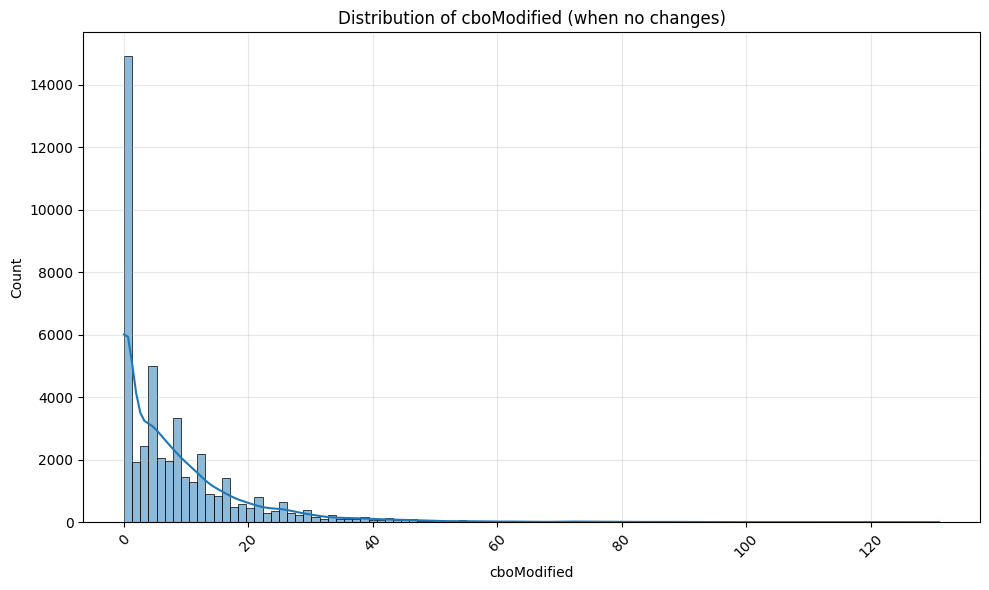

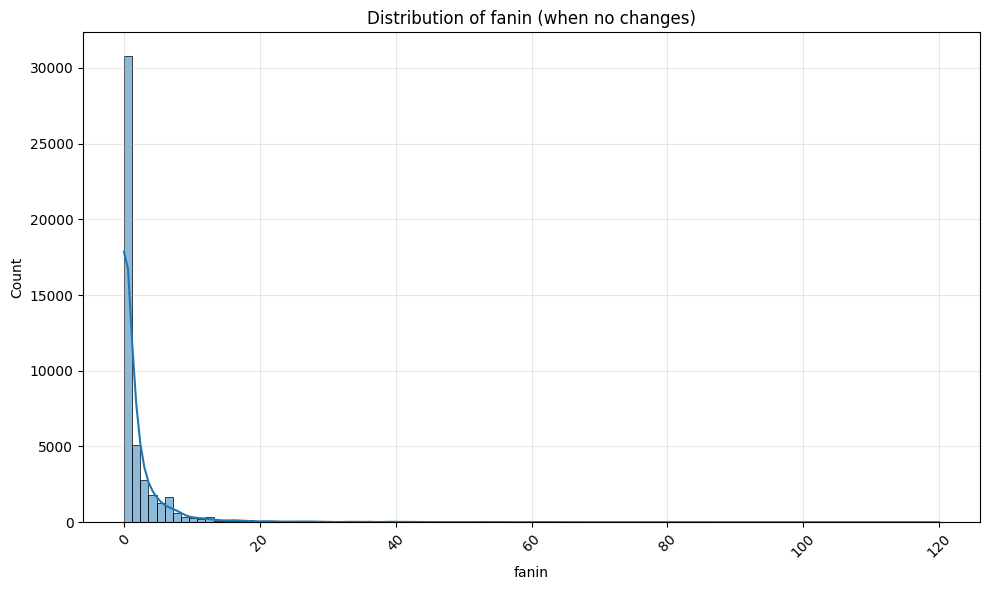

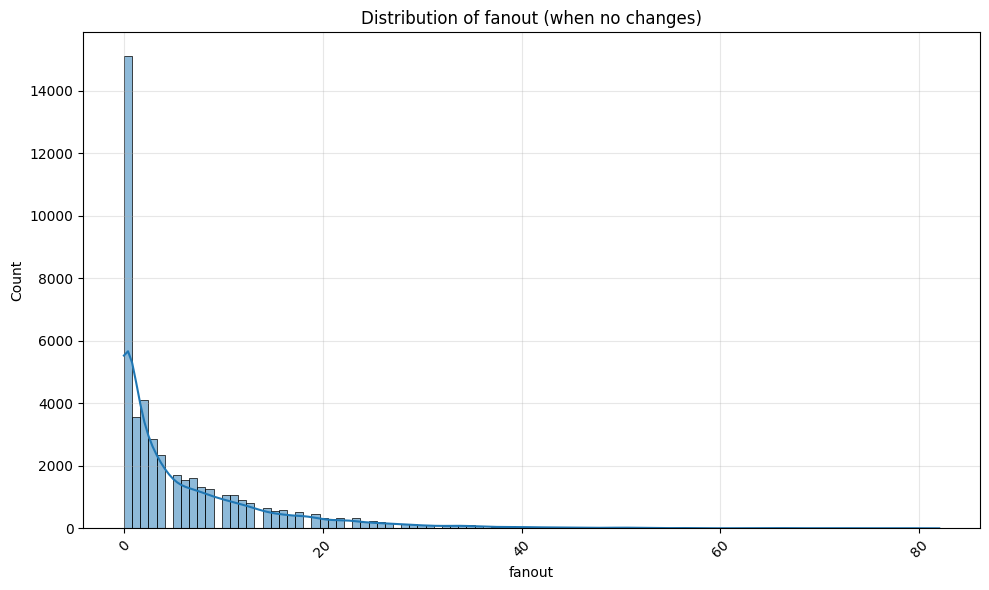

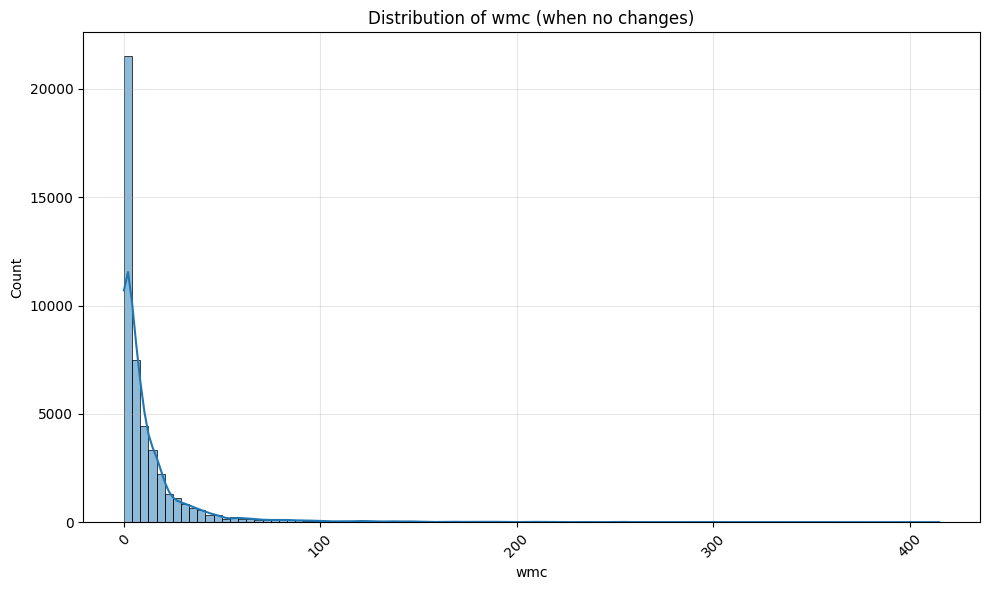

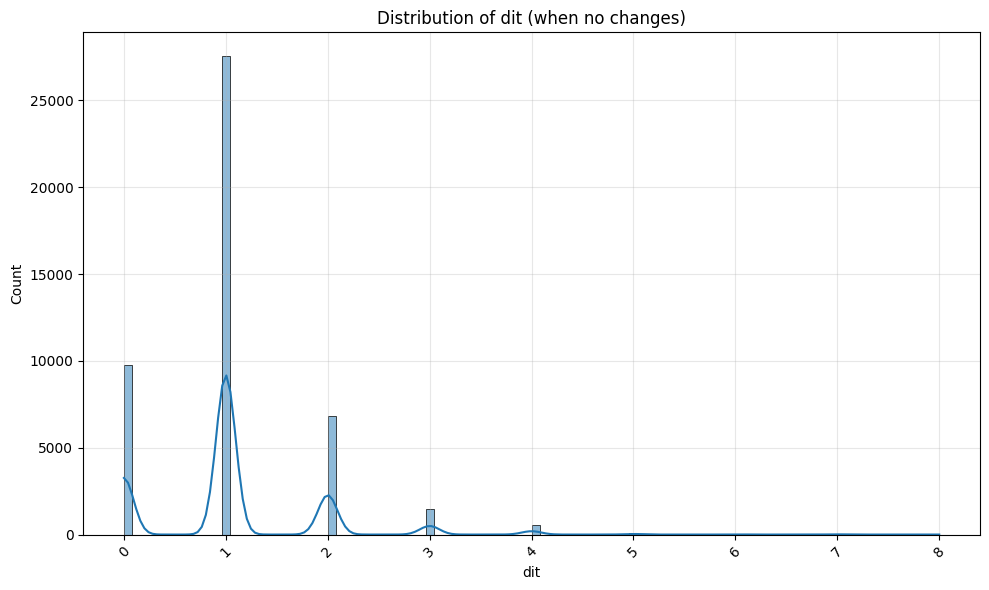

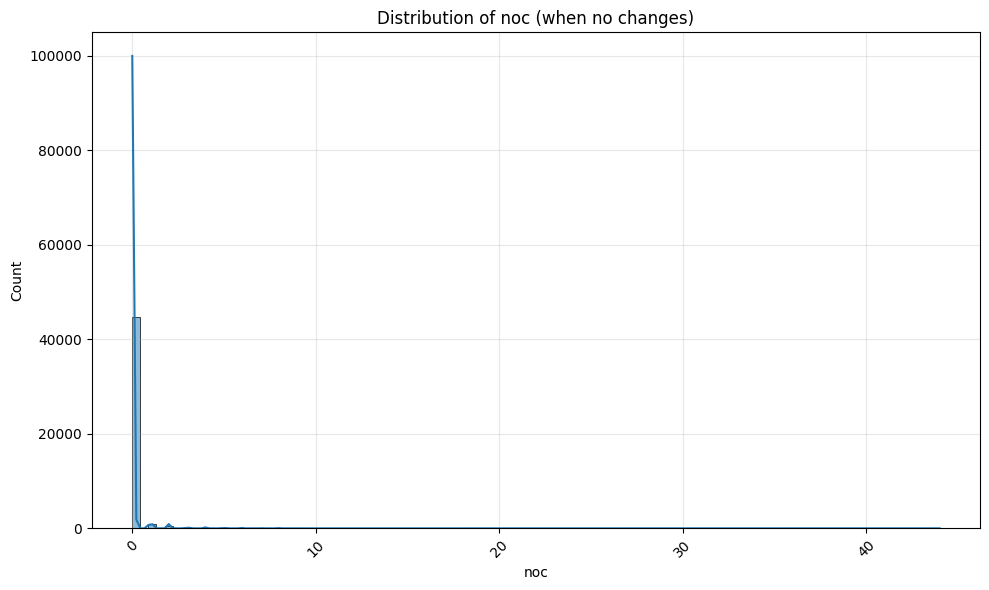

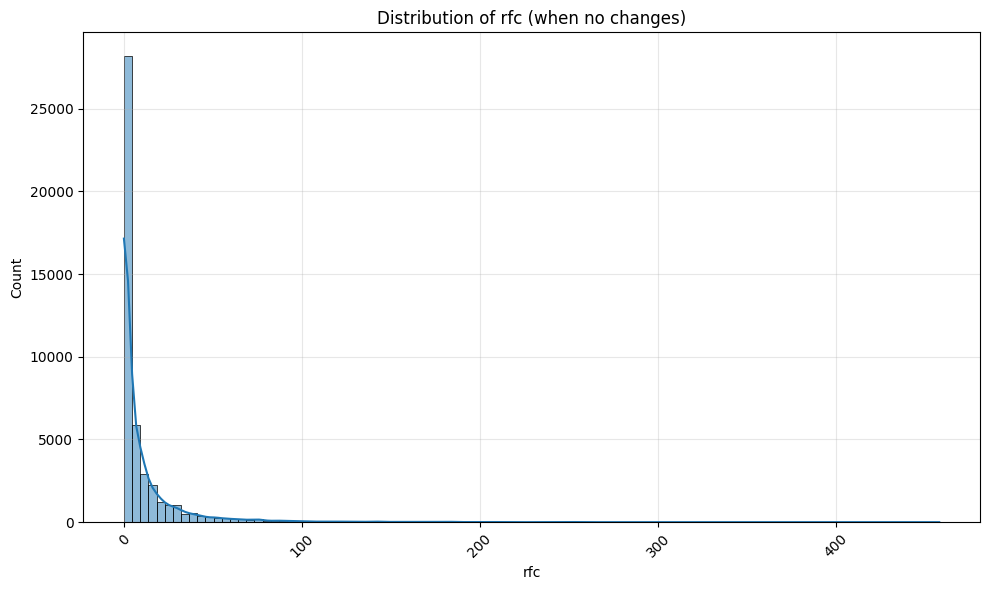

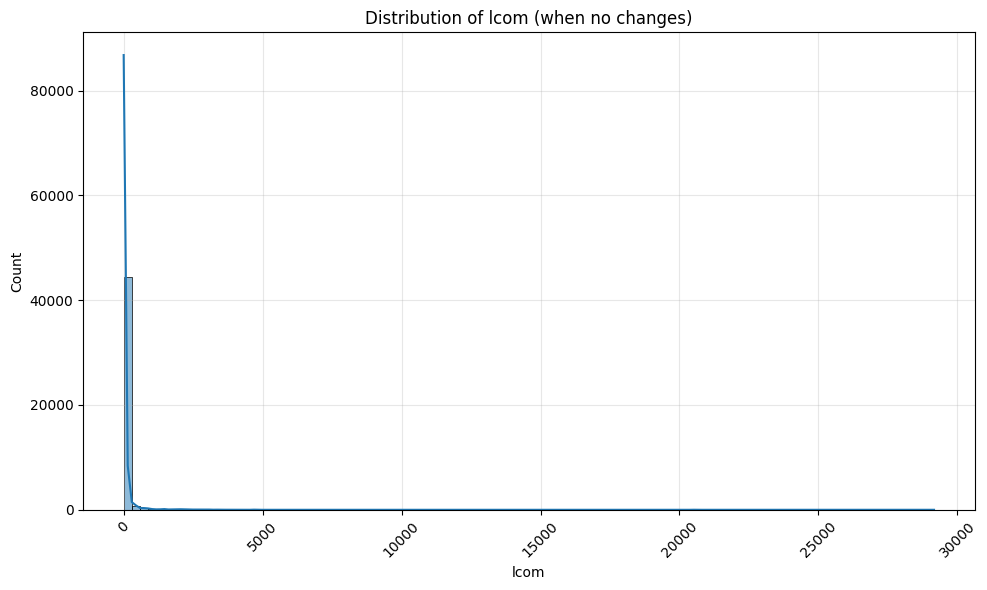

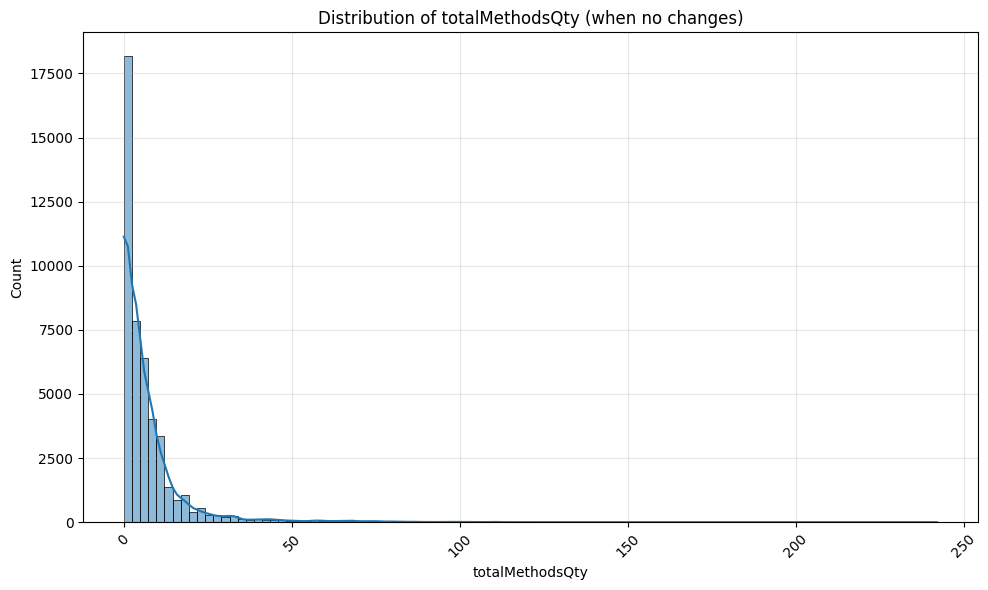

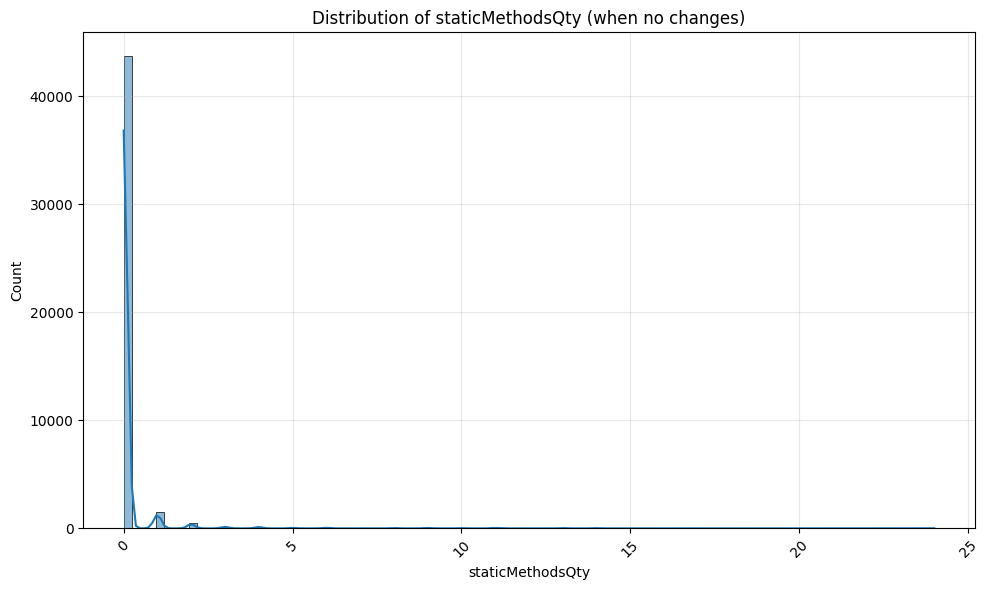

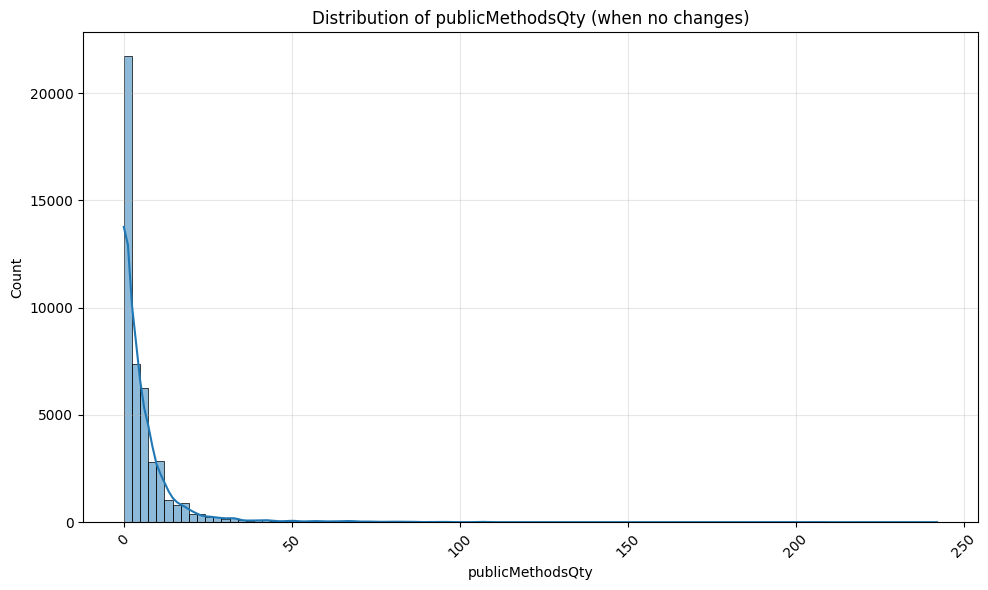

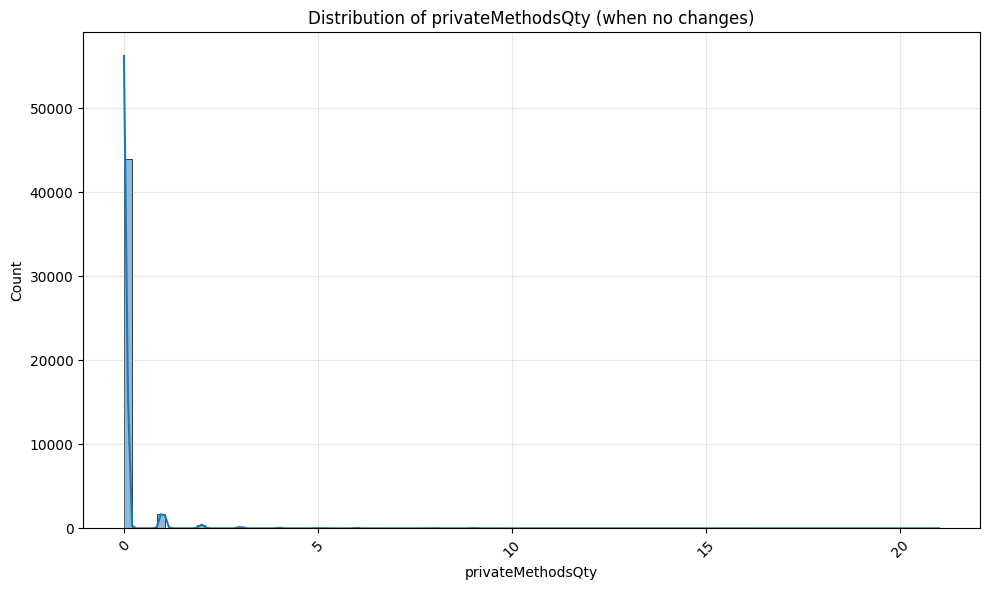

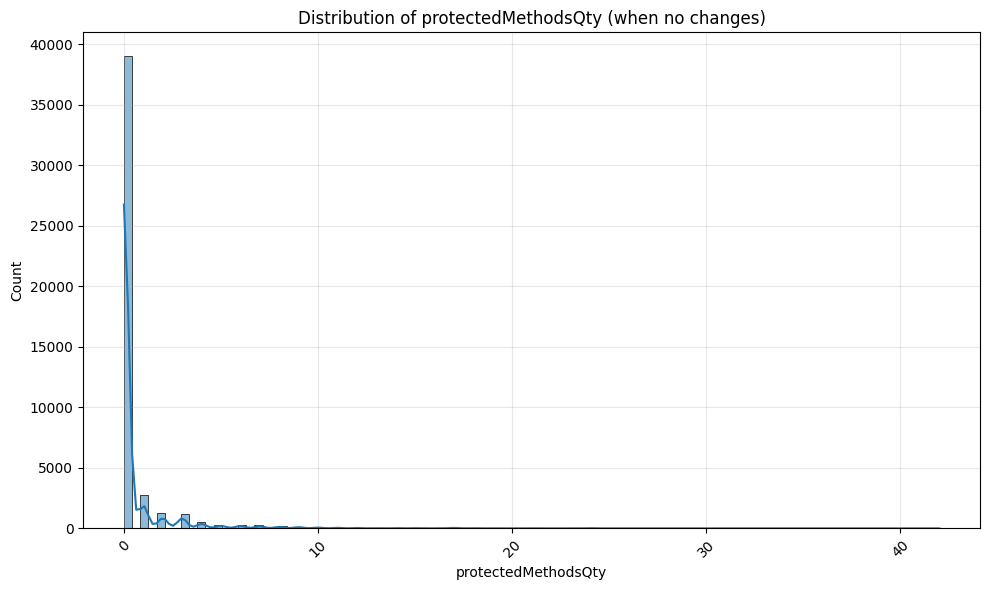

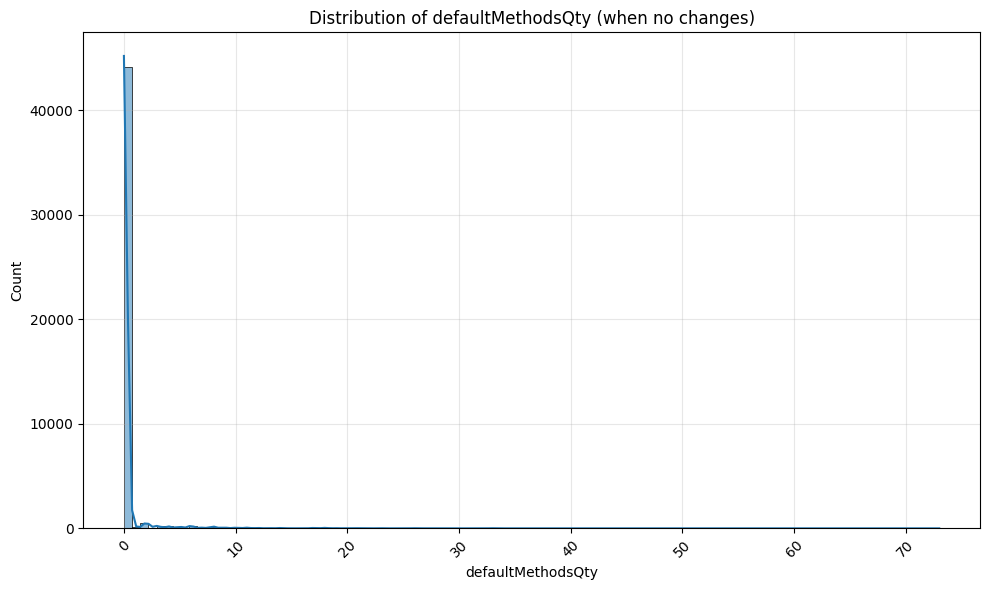

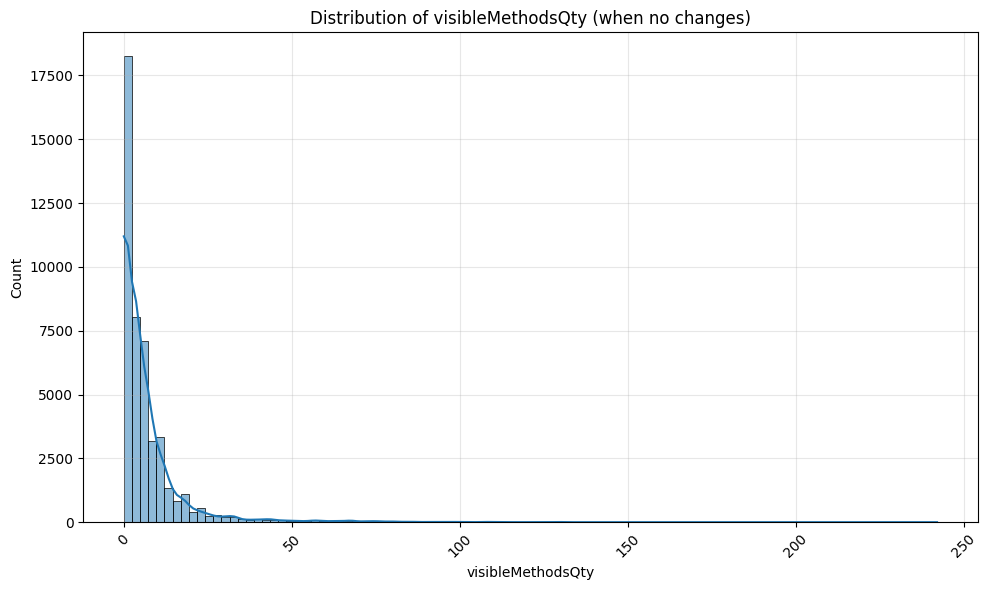

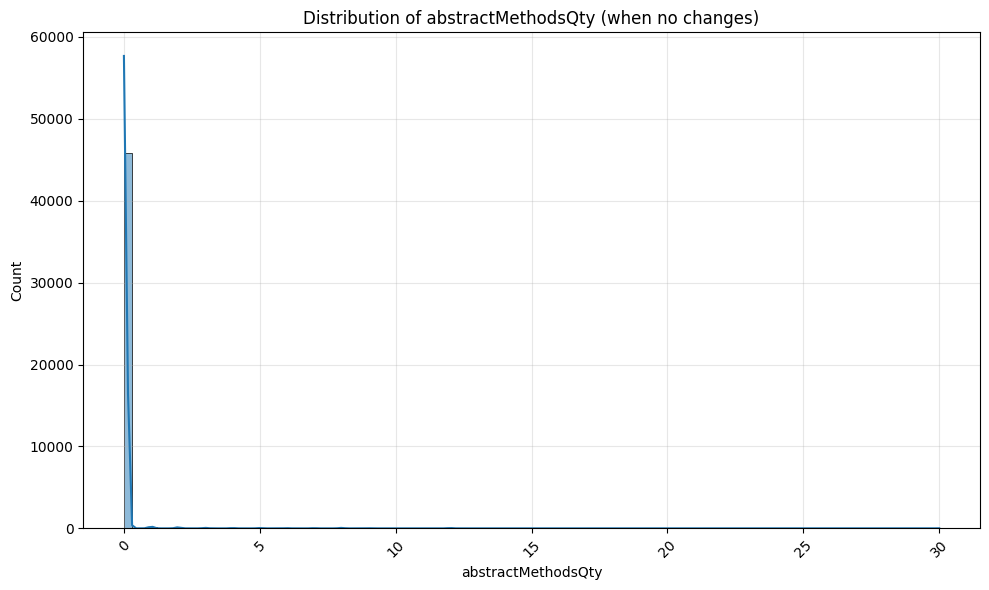

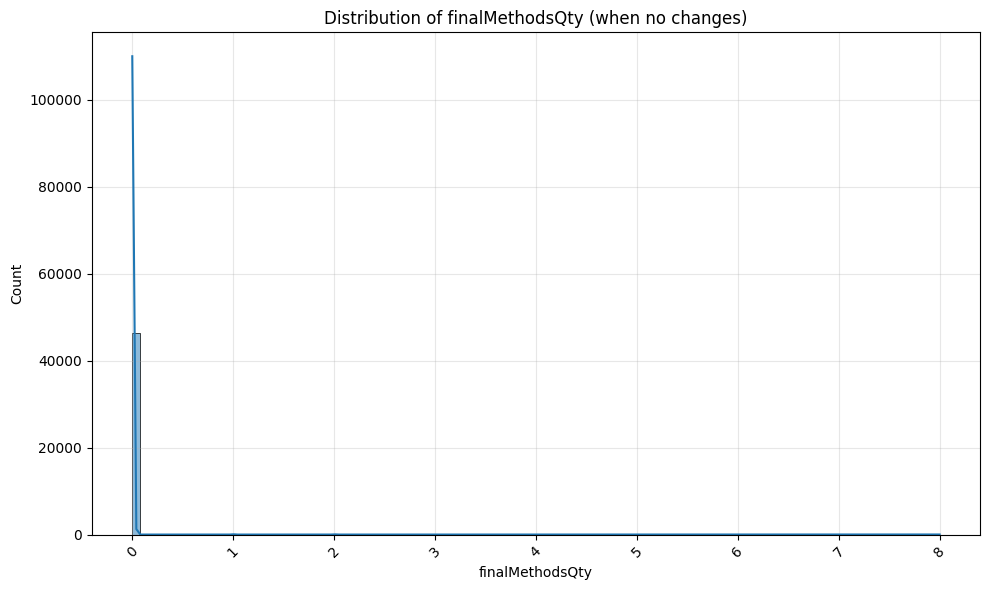

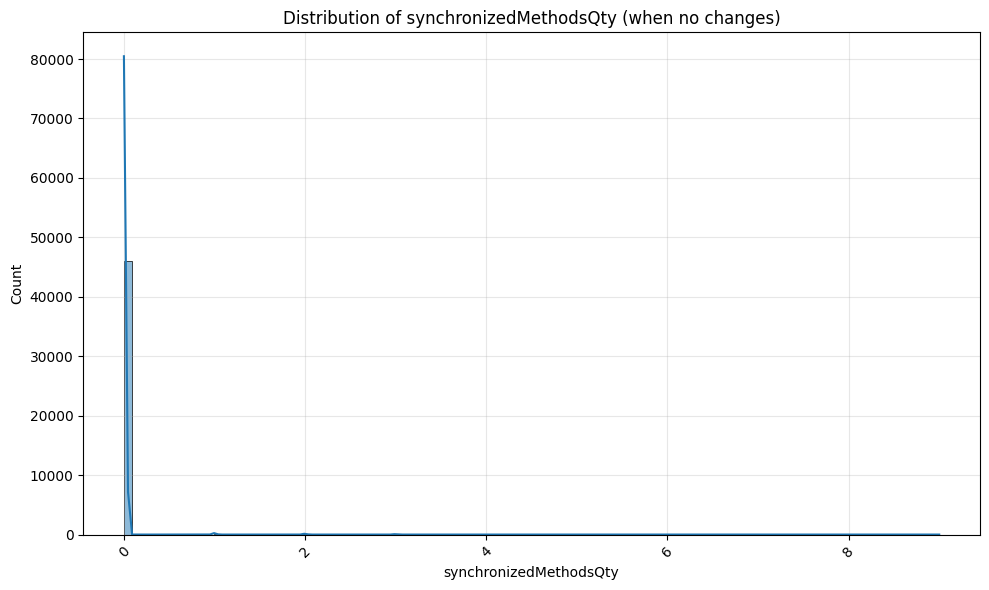

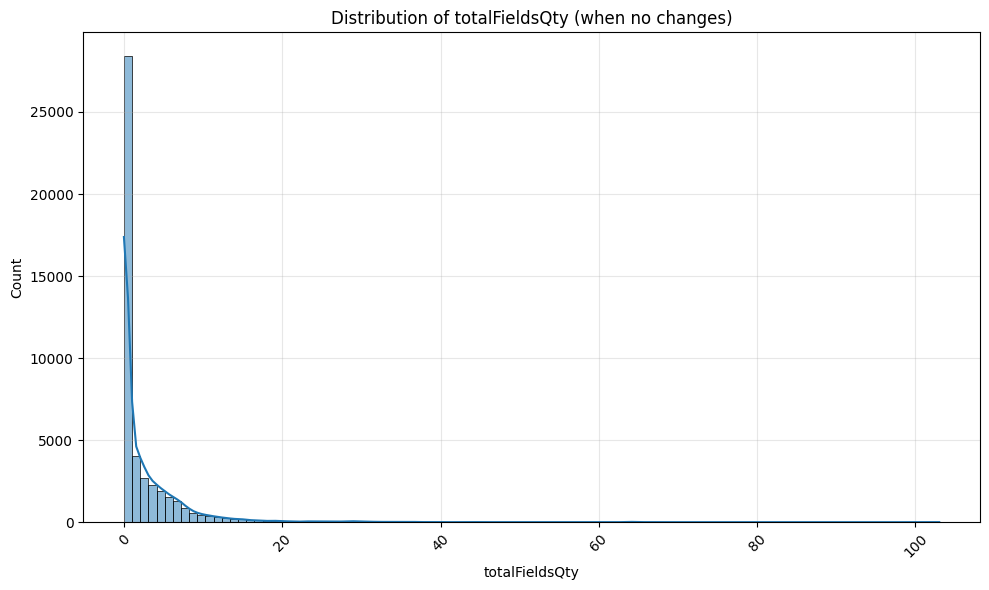

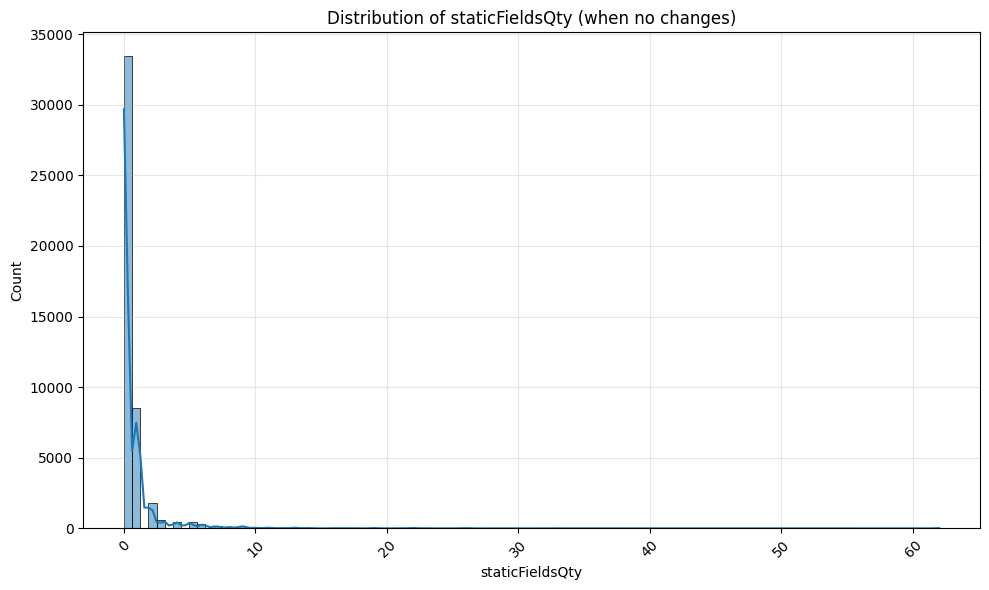

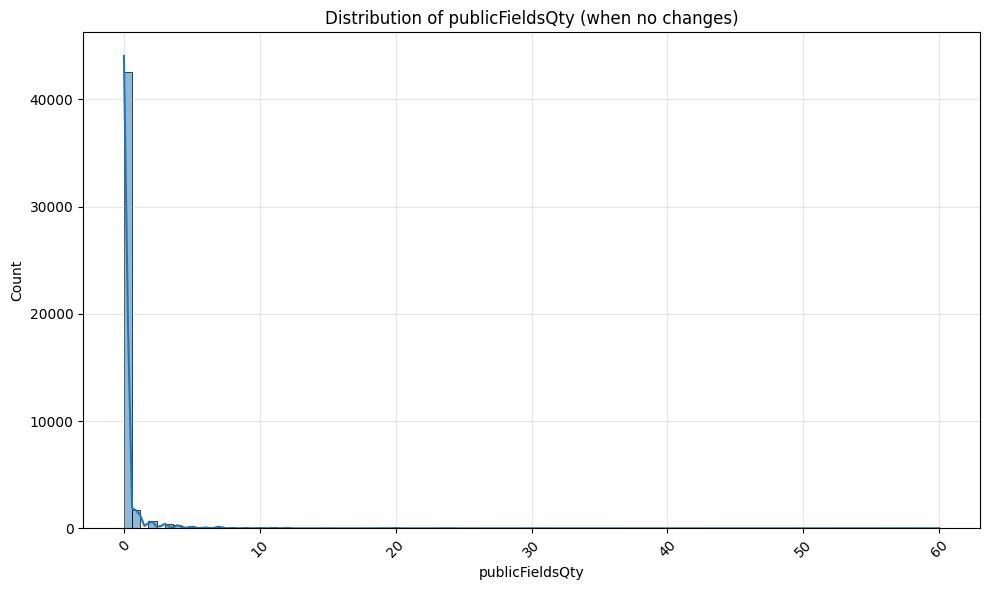

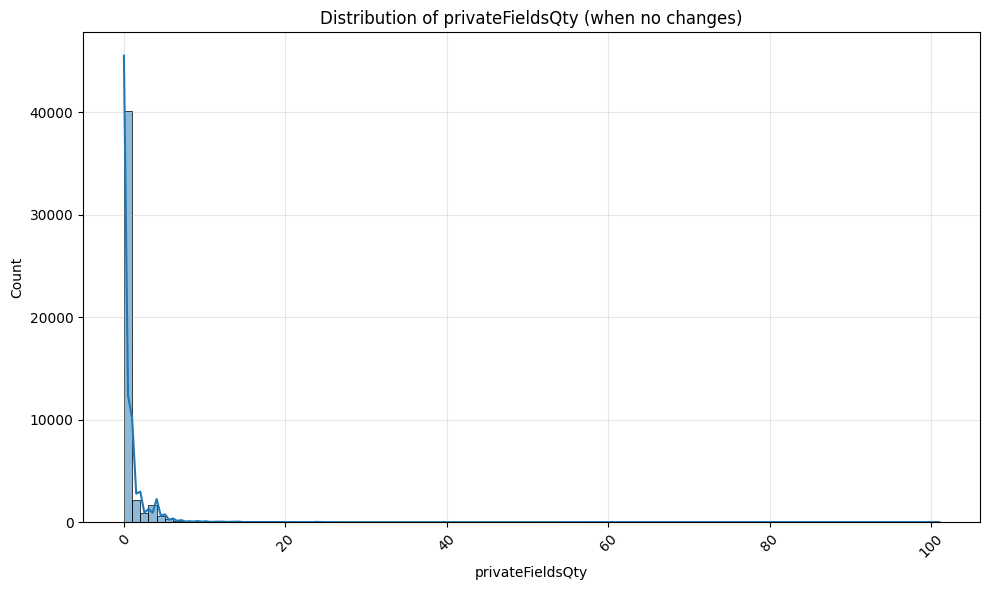

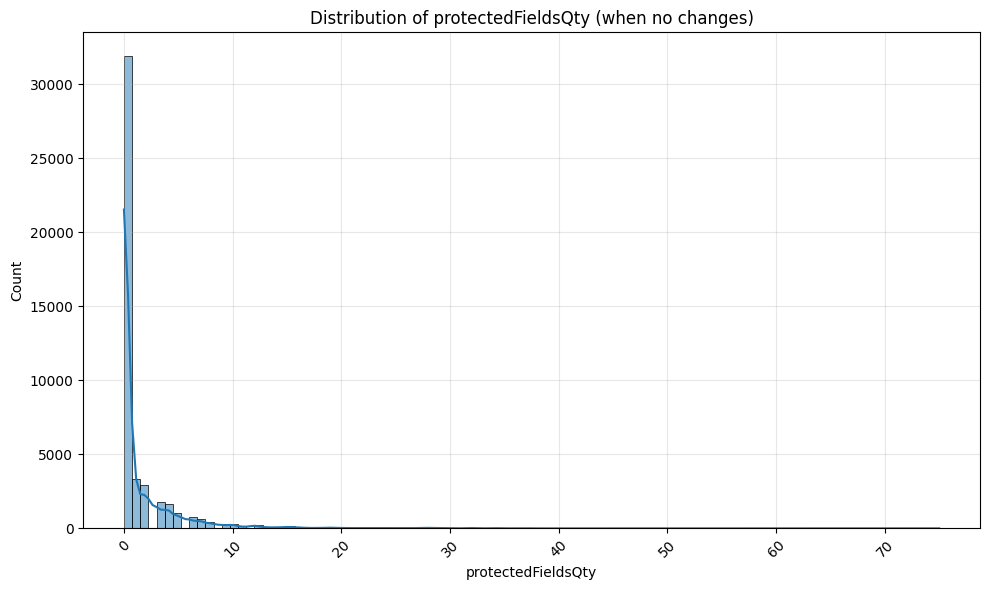

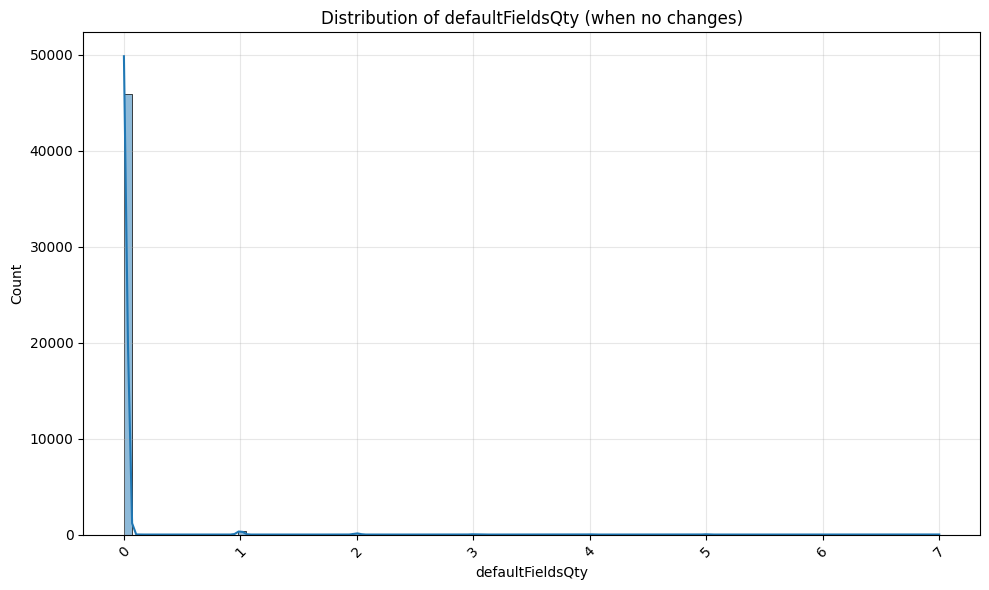

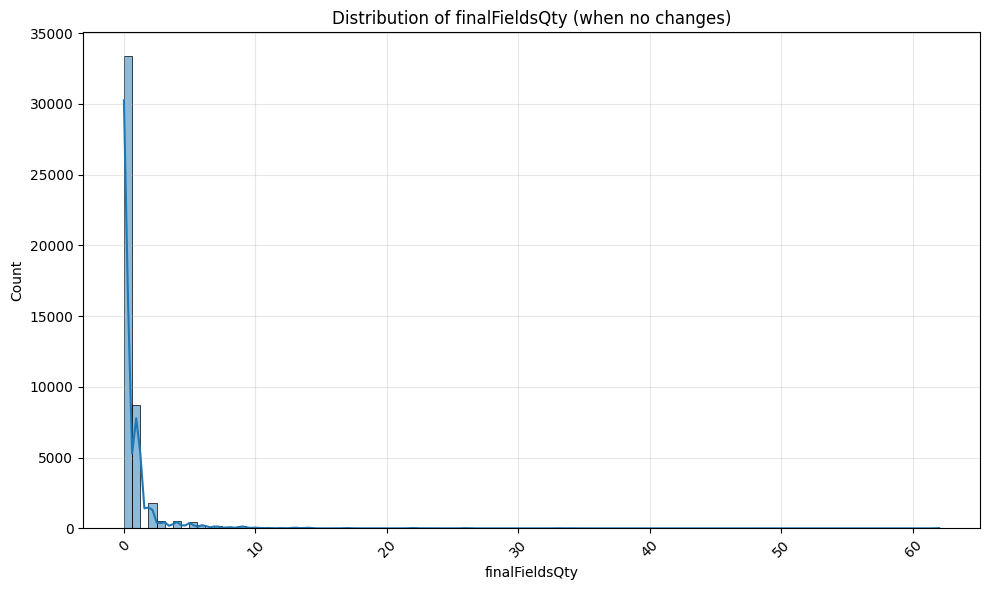

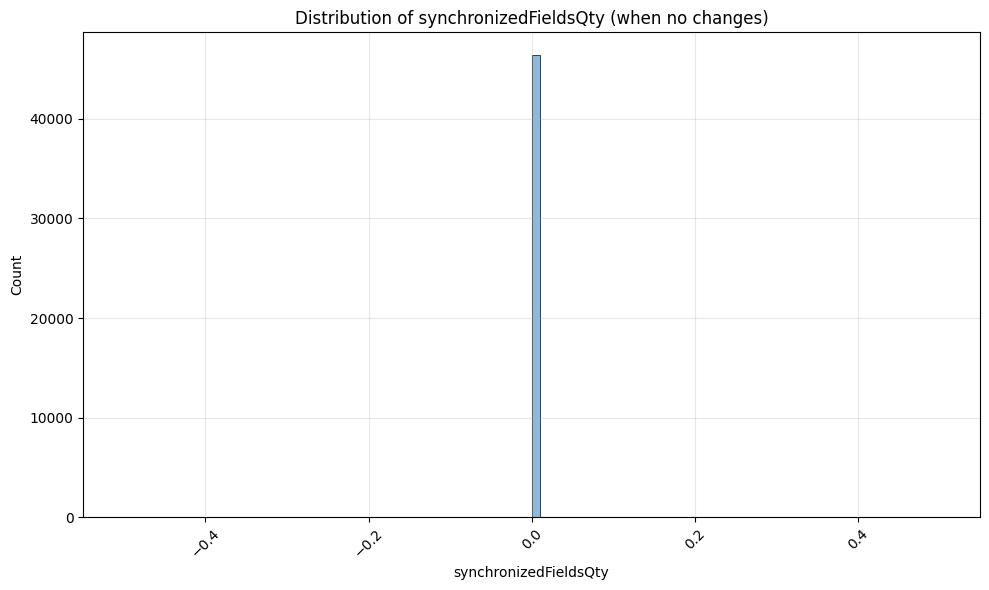

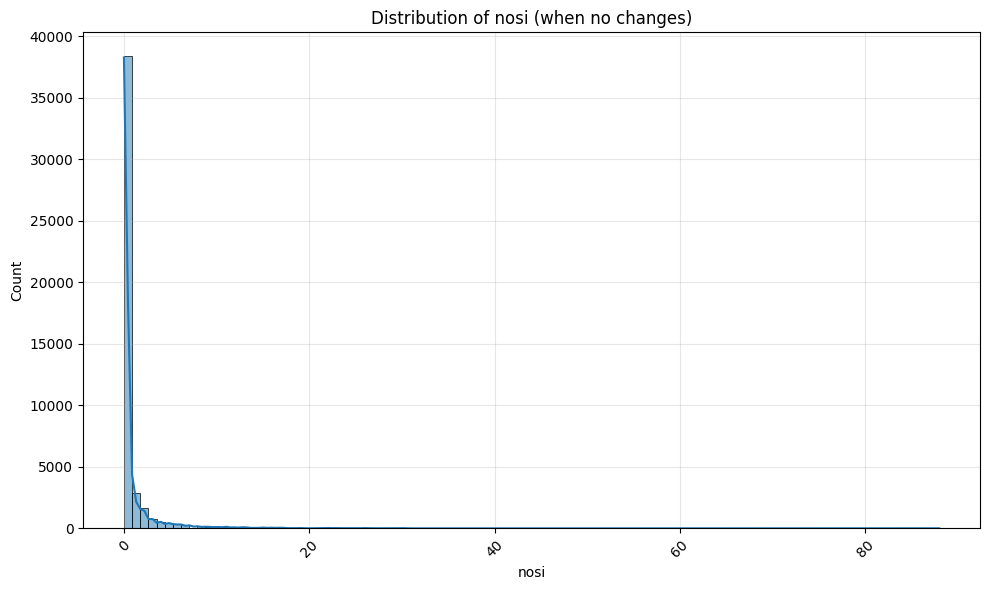

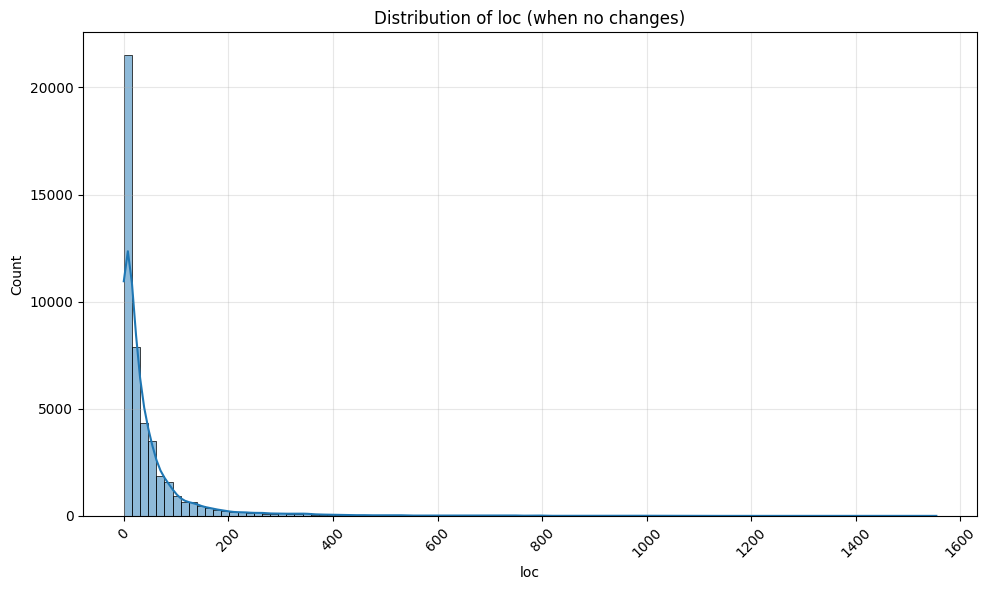

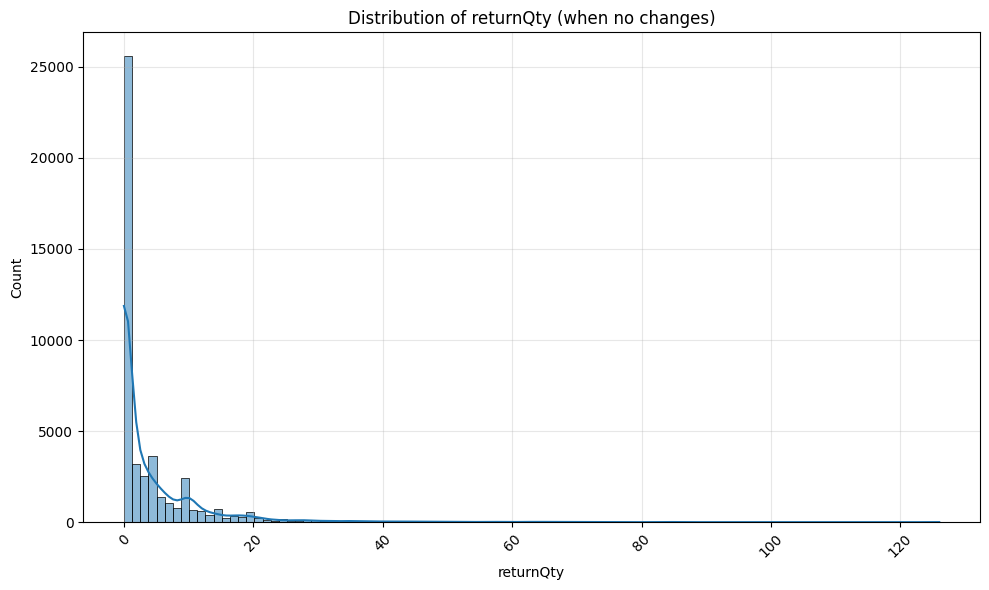

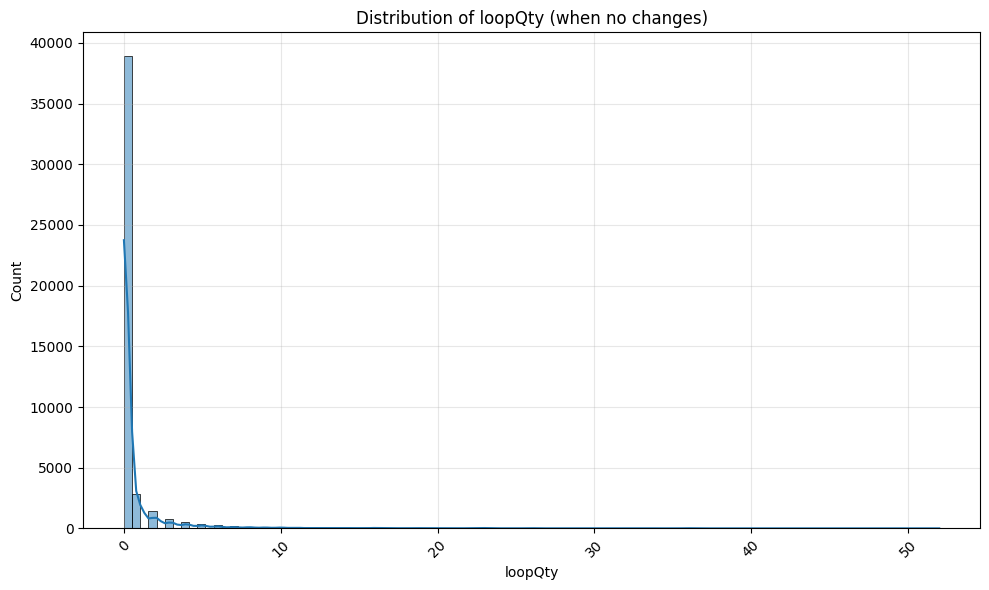

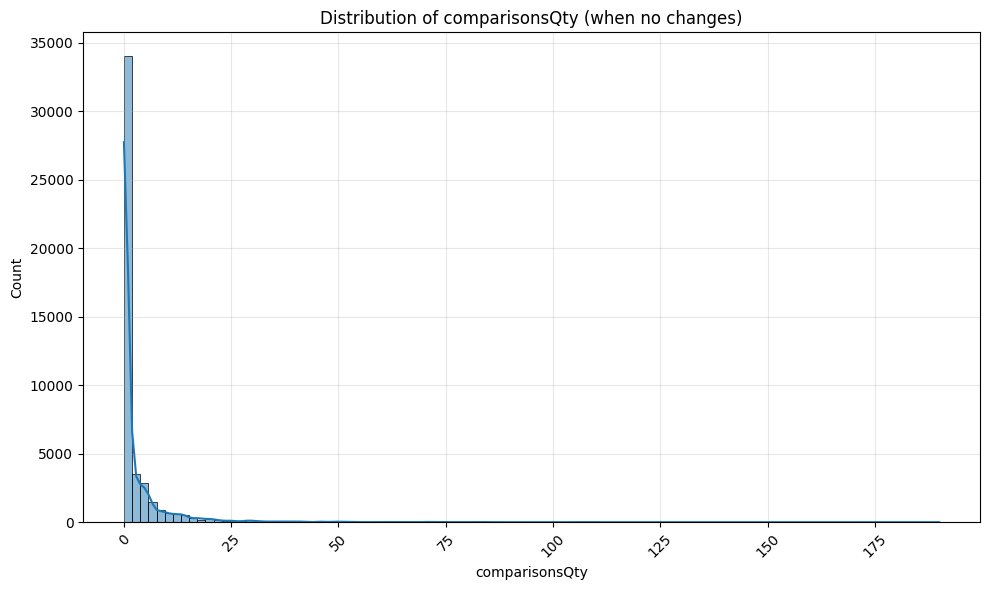

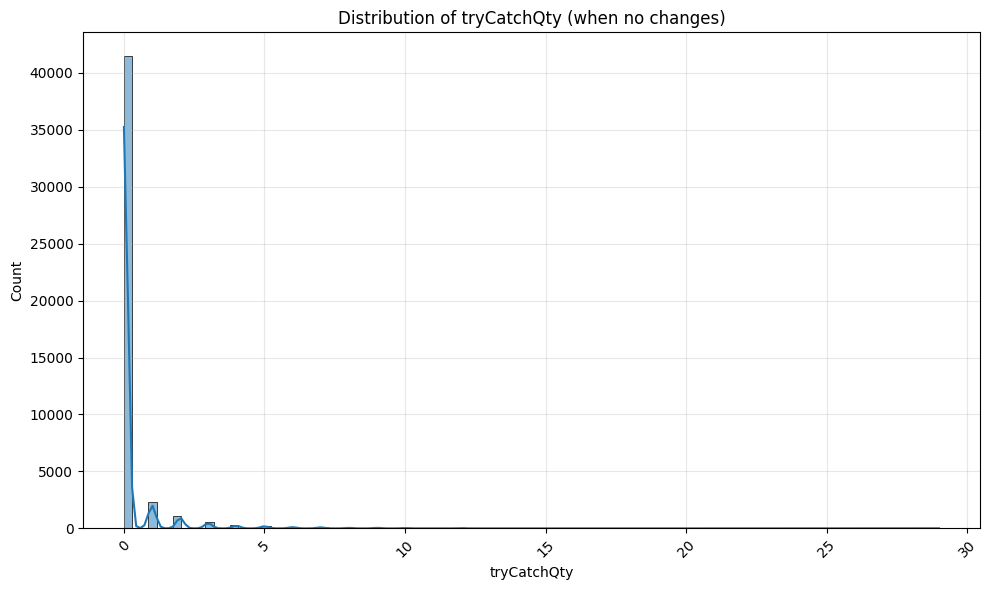

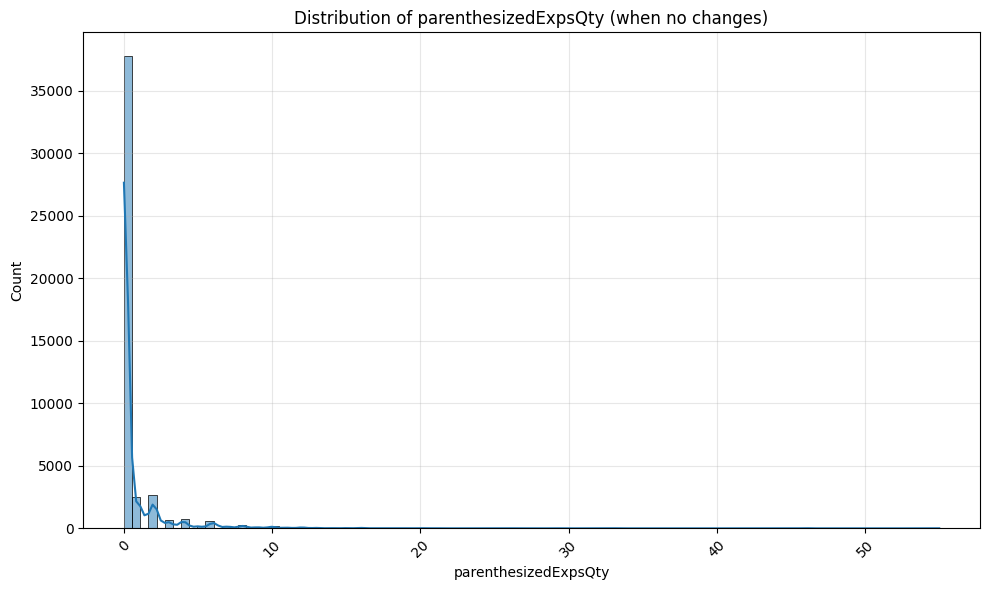

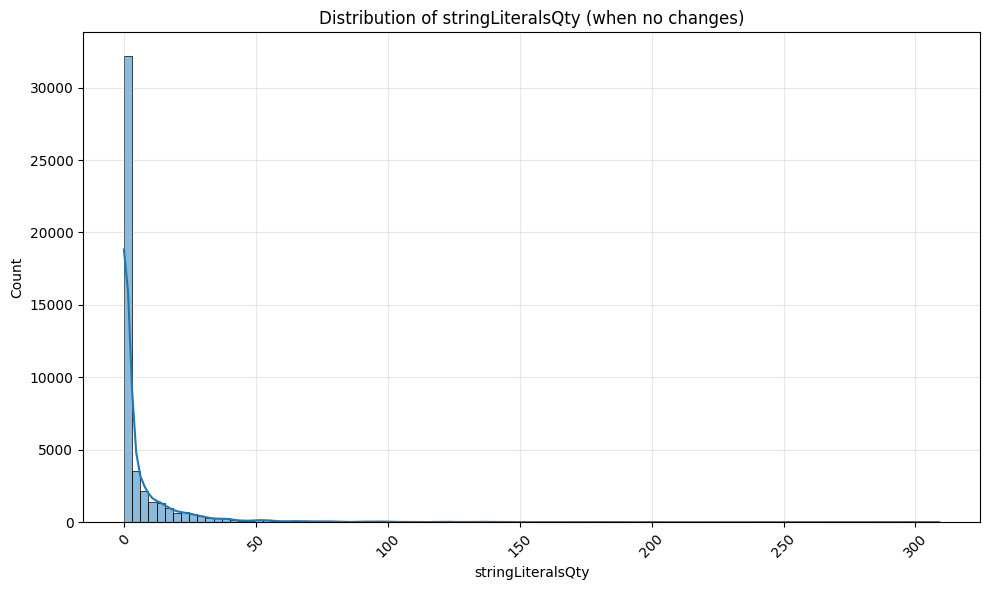

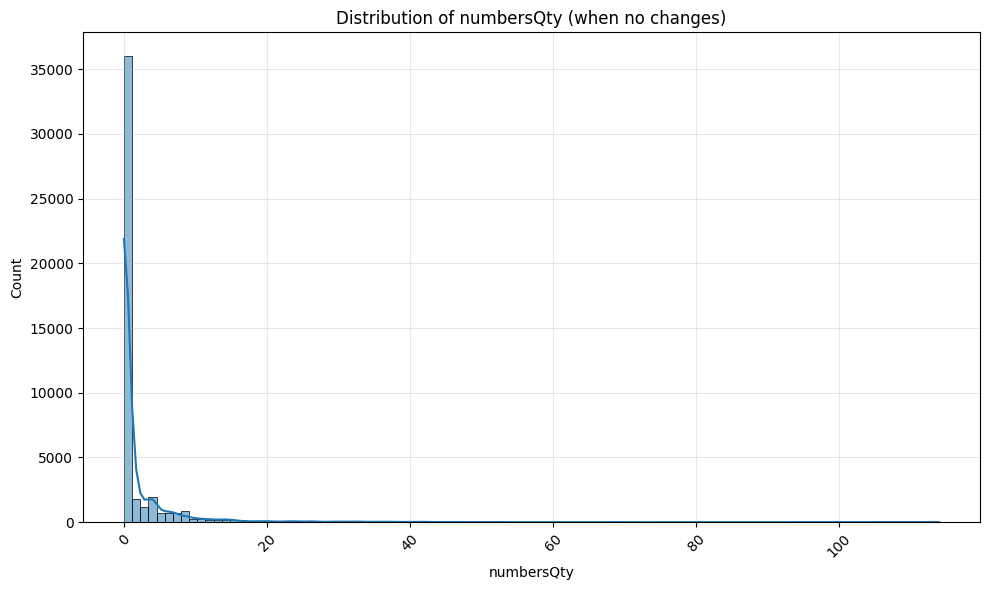

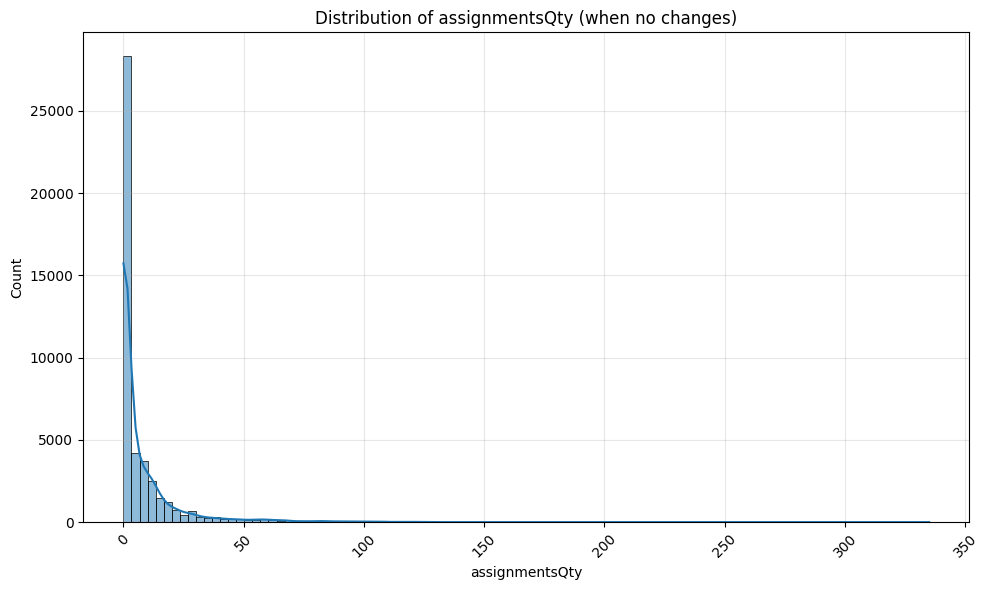

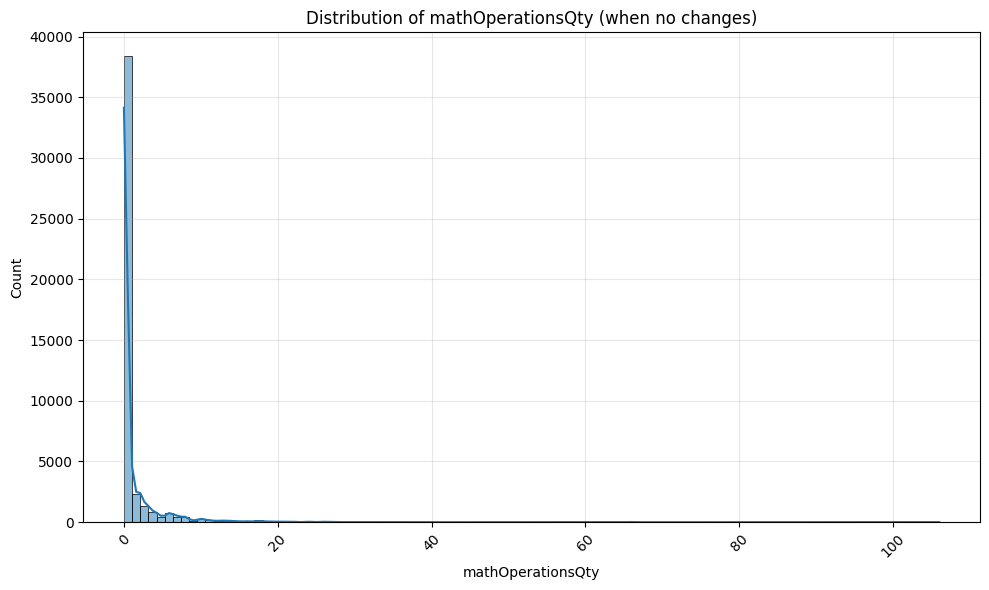

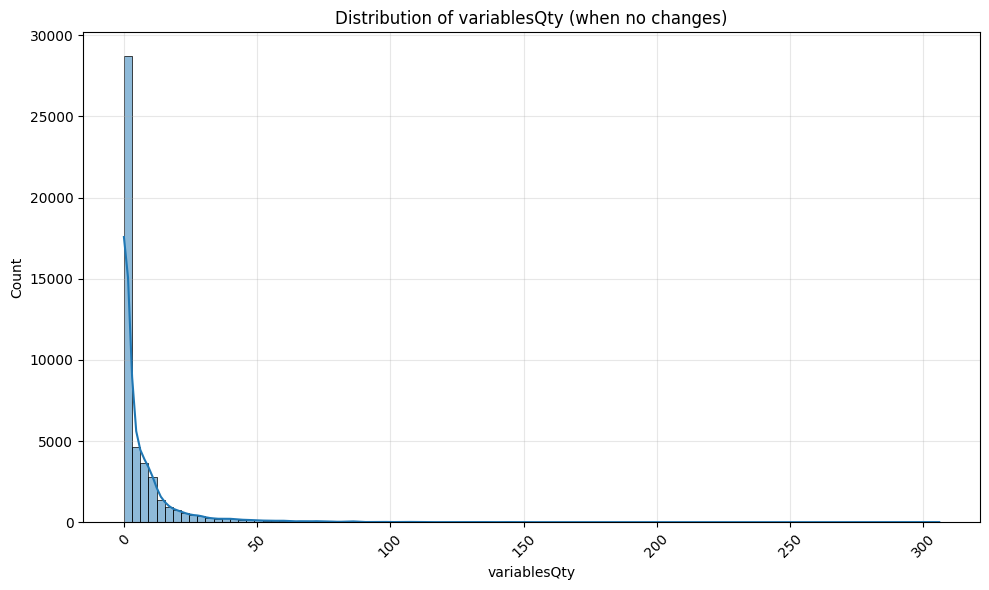

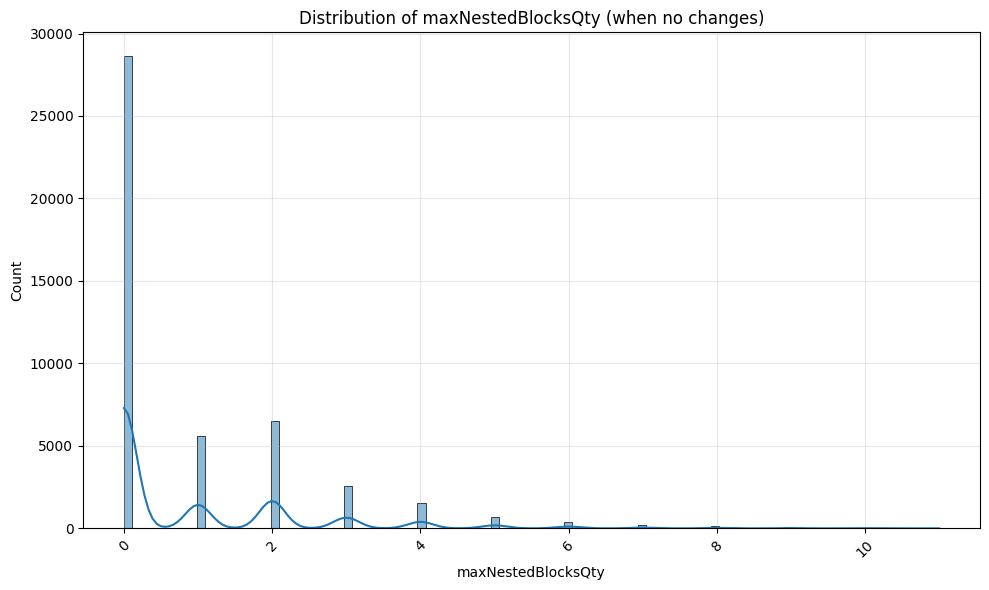

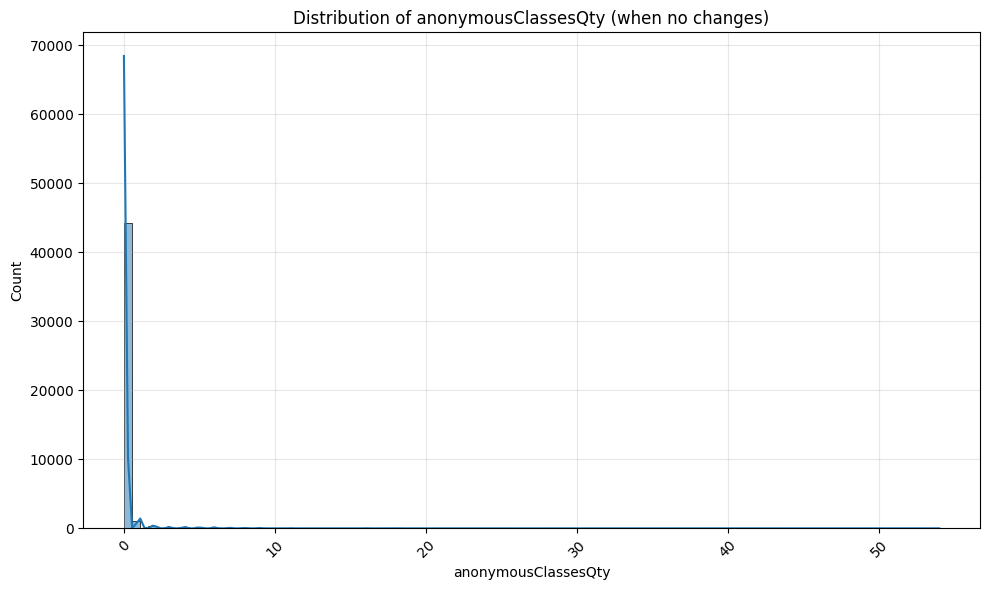

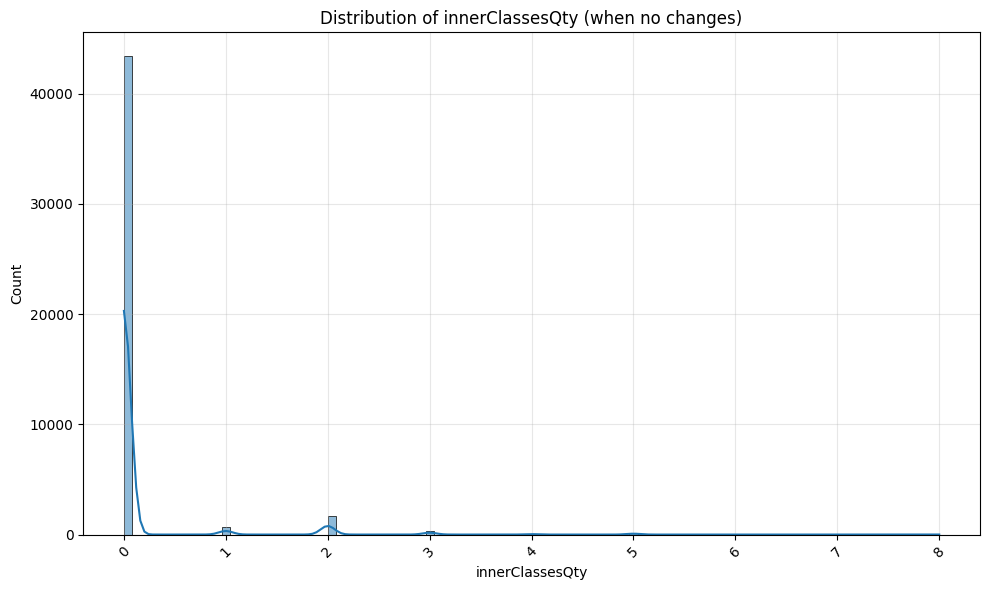

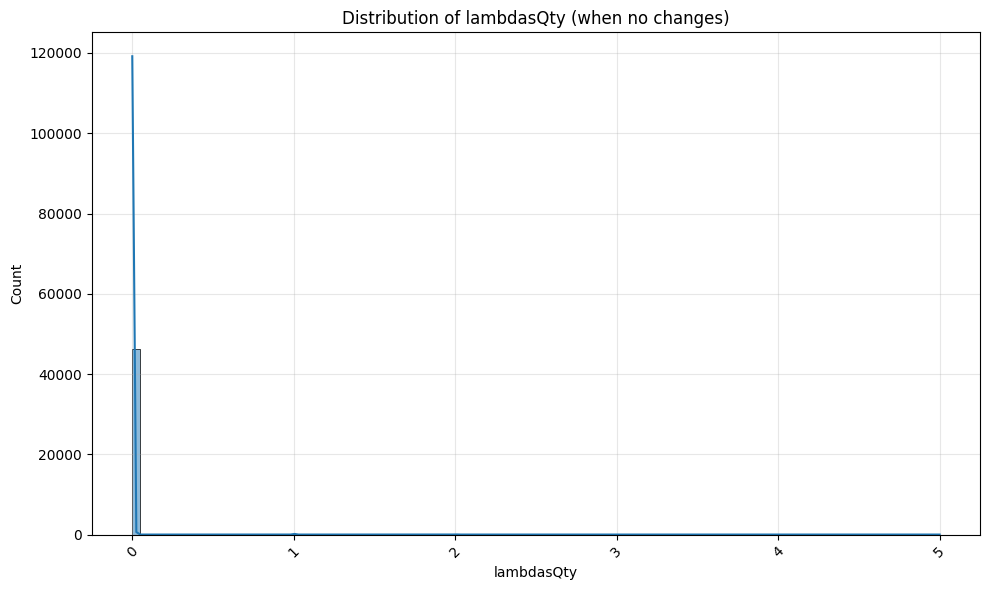

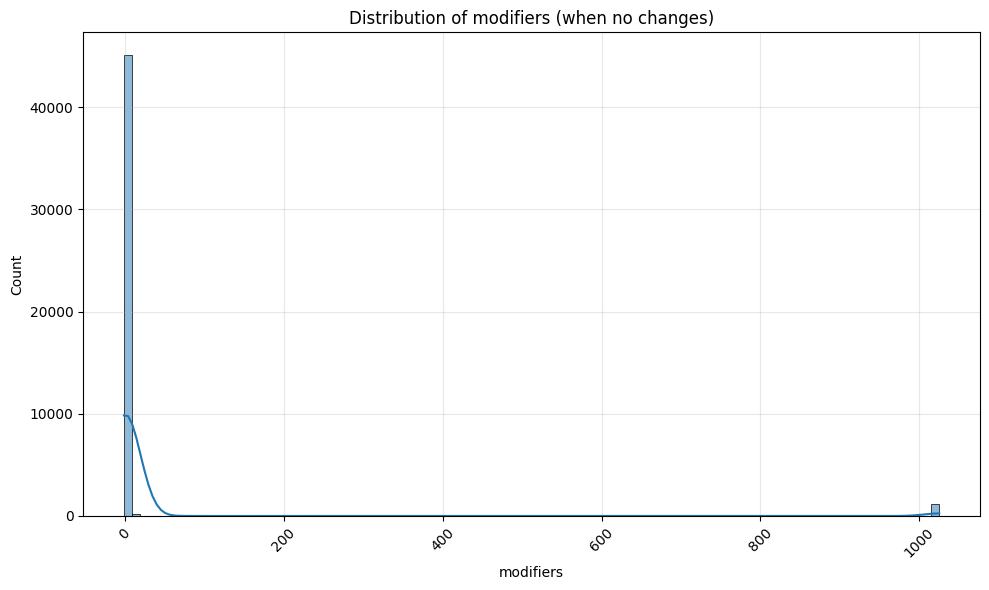

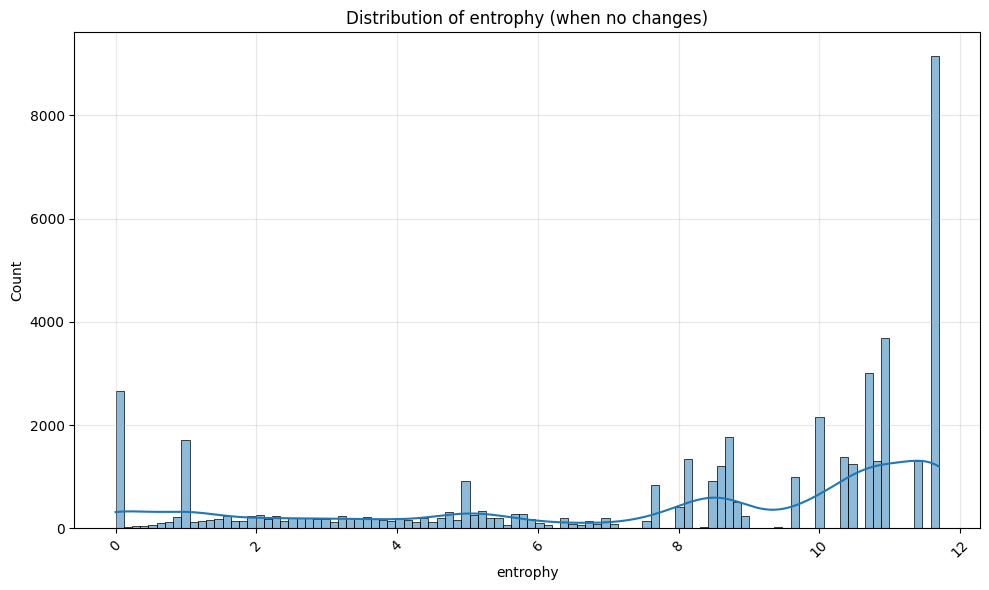

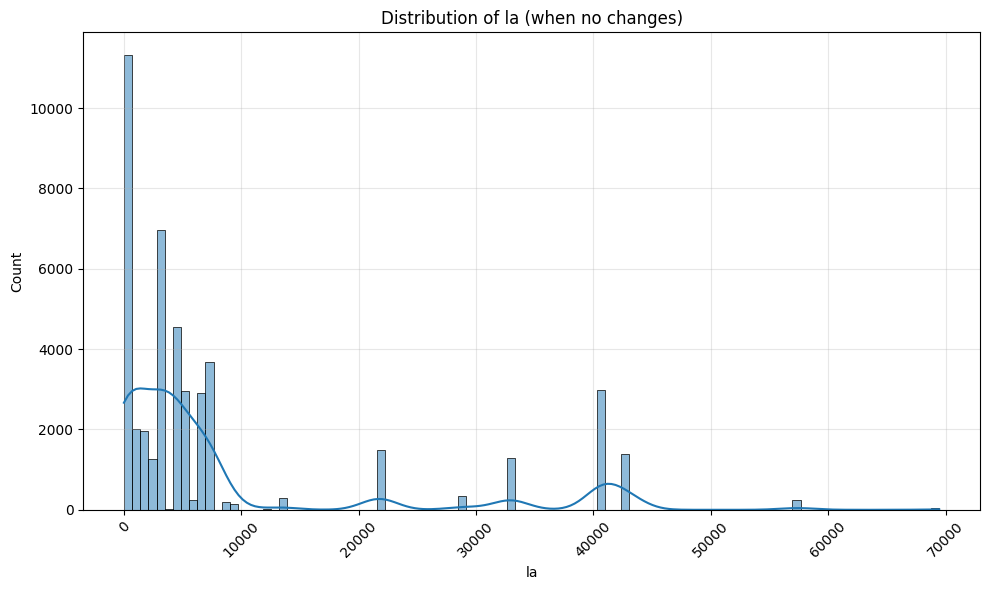

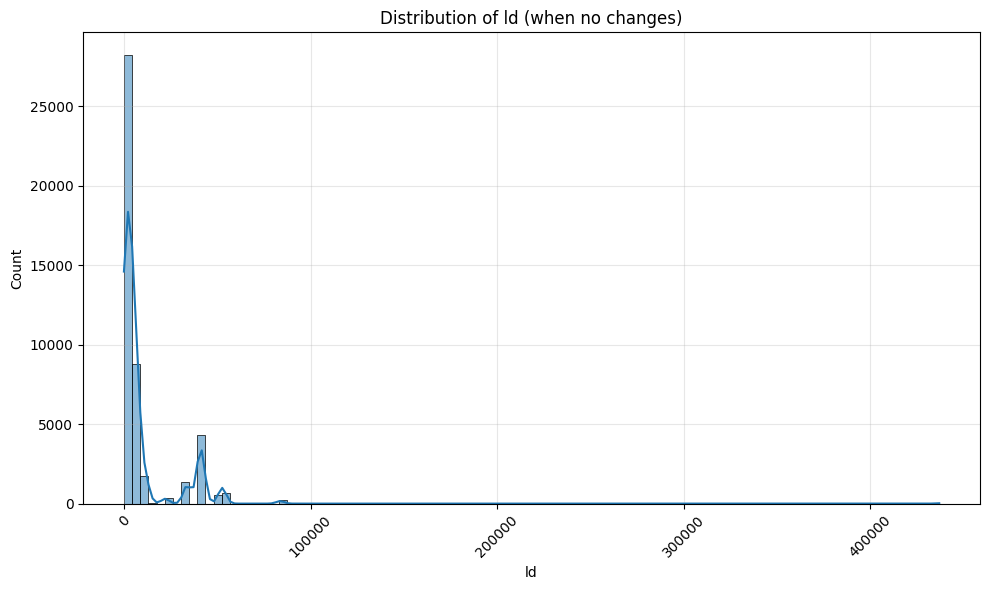

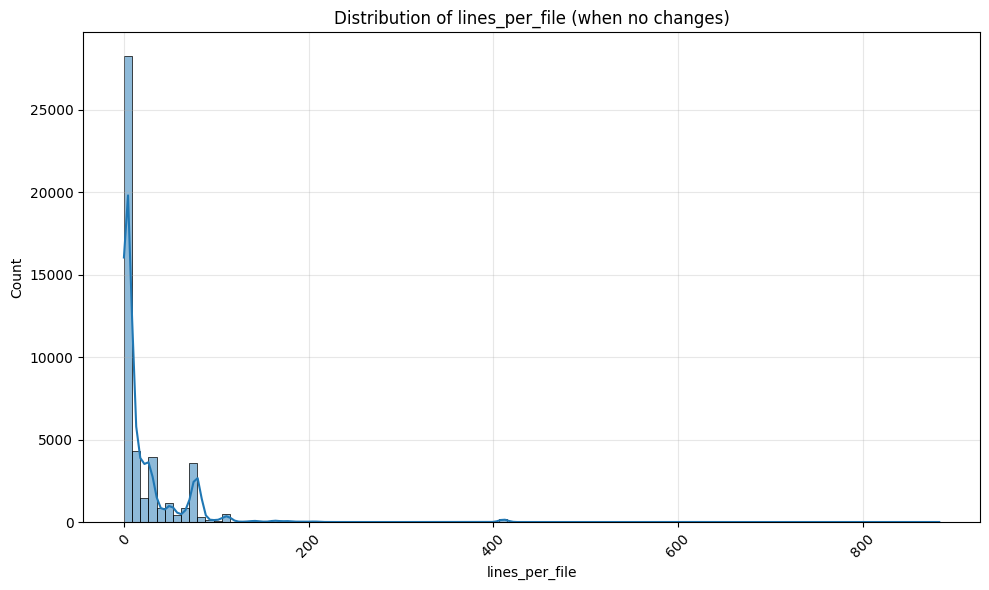

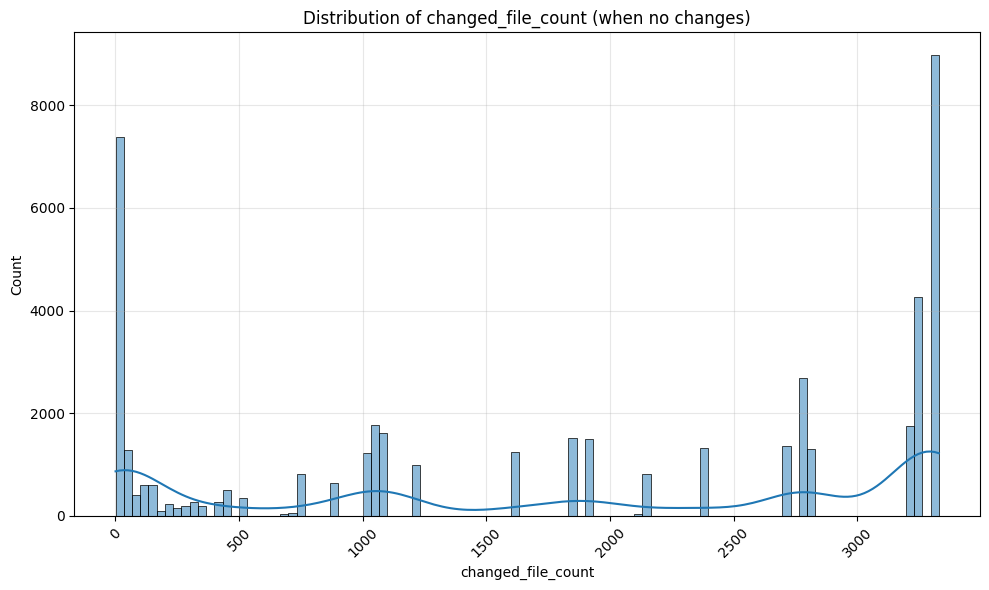

In [18]:
df = pd.read_csv(DATASETS[0])
plot_distribution(df)

In [15]:

df = pd.read_csv(DATASETS[0])
print(df['contains_bug'].value_counts())

df = clean_dataset(df)
print(df['contains_bug'].value_counts())

contains_bug
False    62851
True     50553
Name: count, dtype: int64
Rule 0: Dropping 0 rows.
Original rows: 113404, after cleaning: 33563
Initial rows: 113404, Final rows: 33563
contains_bug
0.0    27876
1.0     5687
Name: count, dtype: int64


In [17]:
import matplotlib.pyplot as plt

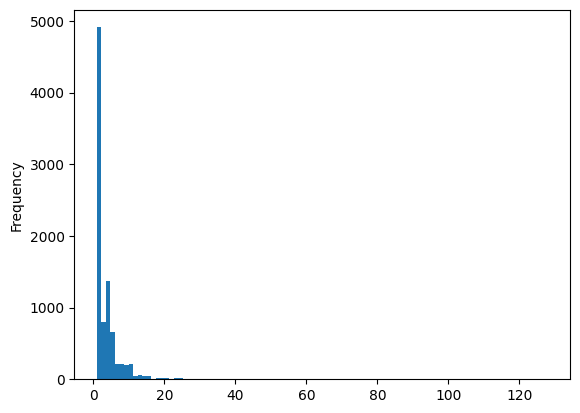

In [18]:
df['hash'].value_counts().plot(kind='hist', bins=100)
plt.show()

contains_bug
False    62851
True     50553
Name: count, dtype: int64
731.6387096774193
Number of unique commits: 8967


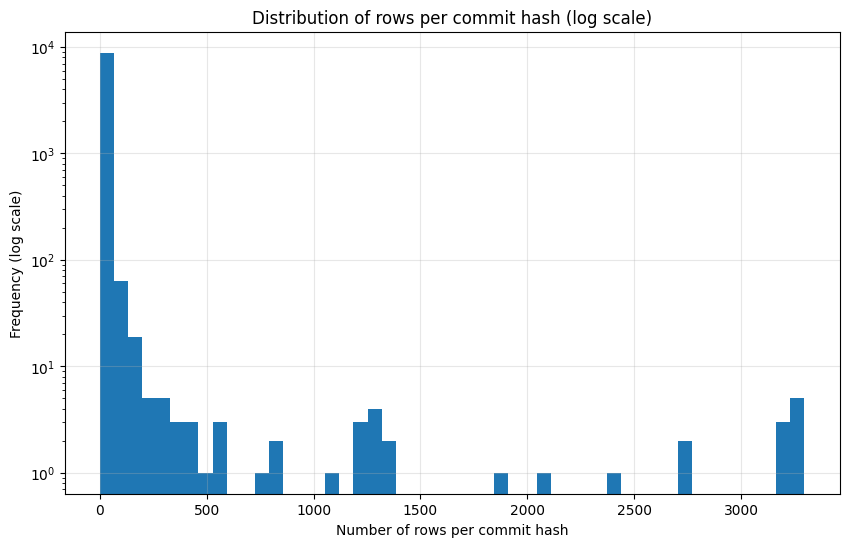

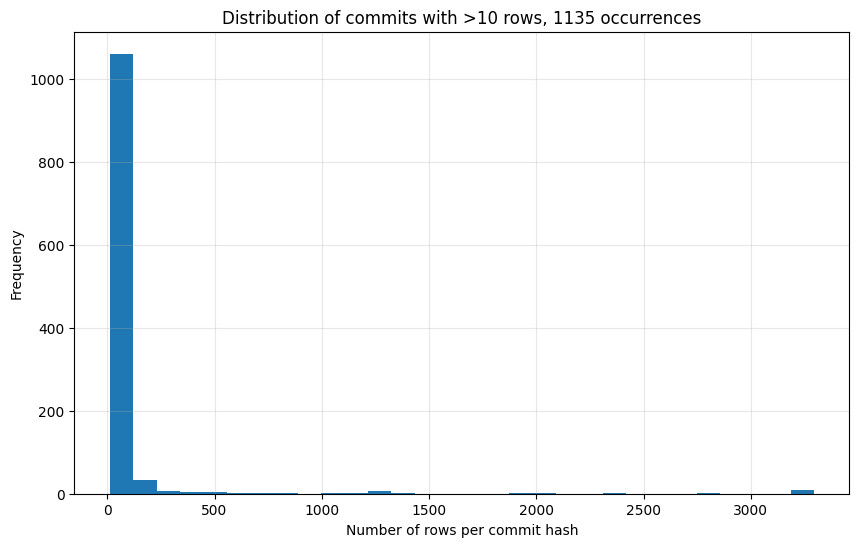

Summary statistics for rows per commit hash:
count    8967.000000
mean       12.646816
std       122.602227
min         1.000000
25%         1.000000
50%         2.000000
75%         6.000000
max      3295.000000
Name: count, dtype: float64
Commits with >10 rows: 1135 (12.66%)
Commits with >50 rows: 180 (2.01%)

Top 10 commits with most rows:
hash
655c3afeeb12f927a636eb43021cddee3d05133a    3295
1cd4ebedfc87f86dd03a0ef232c17d276f9fbff4    3292
d1a42351c0c5391b49427ba7a0b216c7f5b14b43    3291
5b504640876eb35d07af89a688b69da41f3b1e45    3291
5a913ddbb89da00ecb0bccc9a7de100629d645ad    3277
1b56f6a13cd60e587c9158be8804709a7ae5efd6    3212
6a2ea6ad4868eaa0d7c870f59de41b951eb652d9    3212
0b859d50fcbd7ffa55cf18ceb61f482ad03143db    3193
64ea061d8158248918fab0cd71ac5ddb182ec36d    2766
366feee6a75ef8dcce10264c4239a941cc3d5b63    2766
Name: count, dtype: int64


In [25]:
# plot distributions of repeating hash values
df = pd.read_csv(DATASETS[0])
#df = clean_dataset(df)
print(df['contains_bug'].value_counts())
print(np.mean(df['changed_file_count'].value_counts()))

# Count occurrences of each hash value
hash_counts = df['hash'].value_counts()
print(f"Number of unique commits: {len(hash_counts)}")

# Plot distribution of rows per commit hash
plt.figure(figsize=(10, 6))
plt.hist(hash_counts.values, bins=50, log=True)
plt.xlabel('Number of rows per commit hash')
plt.ylabel('Frequency (log scale)')
plt.title('Distribution of rows per commit hash (log scale)')
plt.grid(alpha=0.3)
plt.show()

# Plot distribution for commits with many rows
plt.figure(figsize=(10, 6))
high_rows_commits = hash_counts[hash_counts > 10]
plt.hist(high_rows_commits.values, bins=30)
plt.xlabel('Number of rows per commit hash')
plt.ylabel('Frequency')
plt.title(f'Distribution of commits with >10 rows, {len(high_rows_commits)} occurrences')
plt.grid(alpha=0.3)
plt.show()

# Display summary statistics
print("Summary statistics for rows per commit hash:")
print(hash_counts.describe())
print(f"Commits with >10 rows: {(hash_counts > 10).sum()} ({(hash_counts > 10).sum()/len(hash_counts)*100:.2f}%)")
print(f"Commits with >50 rows: {(hash_counts > 50).sum()} ({(hash_counts > 50).sum()/len(hash_counts)*100:.2f}%)")

# Show top commits with the most rows
print("\nTop 10 commits with most rows:")
print(hash_counts.head(10))

Rule 0: Dropping 0 rows.
Original rows: 113404, after cleaning: 33563
Initial rows: 113404, Final rows: 33563
contains_bug
0.0    27876
1.0     5687
Name: count, dtype: int64
216.53548387096774
Number of unique commits: 8967


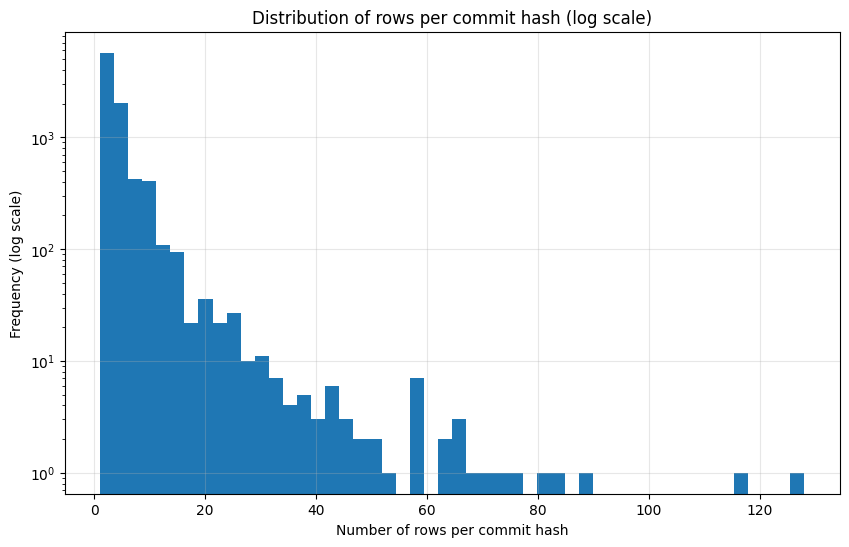

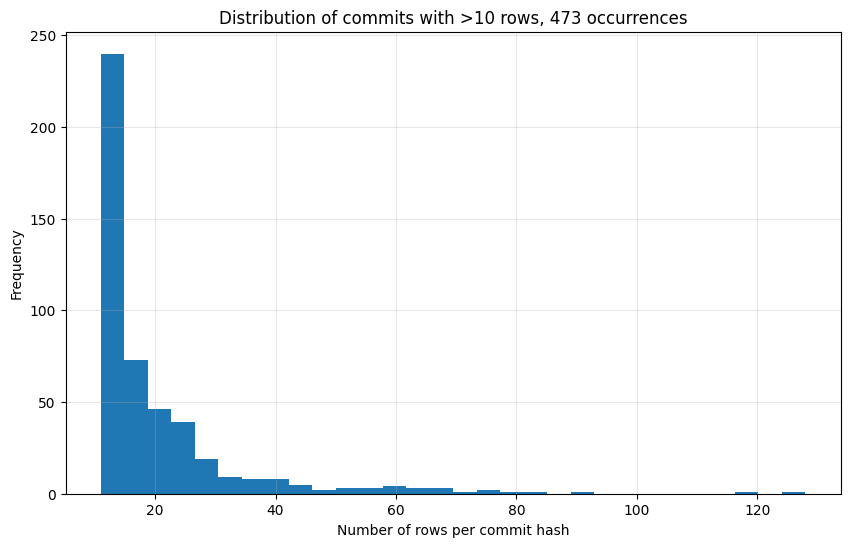

Summary statistics for rows per commit hash:
count    8967.000000
mean        3.742946
std         5.494329
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max       128.000000
Name: count, dtype: float64
Commits with >10 rows: 473 (5.27%)
Commits with >50 rows: 23 (0.26%)

Top 10 commits with most rows:
hash
392af4a88663f3593ebbbe909748362e7d337652    128
f1fe818a630ccd06b78390185e66bb3d1859b23c    117
9b6dd7955d20467e3e730fba1781ddff0e0f7cbe     89
7842ebff56f7eba16d22e1c741dcfc8629877ea8     84
1f2e3abbc7153e3bcf749b2cf08c307150f4ee65     80
010d6220c4e3ed89c725b9a69be50243d08433a6     76
b662643a0406f27e4a1b58570f5d0f18c944f288     74
5d8df8aa13fd7d1d84495c5a8eef3cf3cb8b56ae     72
f89cf53287da739b44a1d39aa537e2dd7b4d8dda     69
22aaac6c1252ddfa023816e7d5d09bf66e073ab9     67
Name: count, dtype: int64


In [24]:
# plot distributions of repeating hash values
df = pd.read_csv(DATASETS[0])
df = clean_dataset(df)
print(df['contains_bug'].value_counts())
print(np.mean(df['changed_file_count'].value_counts()))

# Count occurrences of each hash value
hash_counts = df['hash'].value_counts()
print(f"Number of unique commits: {len(hash_counts)}")

# Plot distribution of rows per commit hash
plt.figure(figsize=(10, 6))
plt.hist(hash_counts.values, bins=50, log=True)
plt.xlabel('Number of rows per commit hash')
plt.ylabel('Frequency (log scale)')
plt.title('Distribution of rows per commit hash (log scale)')
plt.grid(alpha=0.3)
plt.show()

# Plot distribution for commits with many rows
plt.figure(figsize=(10, 6))
high_rows_commits = hash_counts[hash_counts > 10]
plt.hist(high_rows_commits.values, bins=30)
plt.xlabel('Number of rows per commit hash')
plt.ylabel('Frequency')
plt.title(f'Distribution of commits with >10 rows, {len(high_rows_commits)} occurrences')
plt.grid(alpha=0.3)
plt.show()

# Display summary statistics
print("Summary statistics for rows per commit hash:")
print(hash_counts.describe())
print(f"Commits with >10 rows: {(hash_counts > 10).sum()} ({(hash_counts > 10).sum()/len(hash_counts)*100:.2f}%)")
print(f"Commits with >50 rows: {(hash_counts > 50).sum()} ({(hash_counts > 50).sum()/len(hash_counts)*100:.2f}%)")

# Show top commits with the most rows
print("\nTop 10 commits with most rows:")
print(hash_counts.head(10))

In [33]:
df = pd.read_csv(DATASETS[0])


df = clean_dataset(df)

#print label dist
print(df['contains_bug'].value_counts())

Rule 0: Dropping 0 rows.
Rule 2: Dropping 6 rows.
Rule 3: Dropping 14312 rows.
Rule 4: Dropping 8642 rows.
Rule 5: Dropping 476 rows.
Rule 6: Dropping 32720 rows.
Rule 7: Dropping 384 rows.
Rule 8: Dropping 1265 rows.
Rule 9: Dropping 5455 rows.
Rule 10: Dropping 218 rows.
Rule 11: Dropping 0 rows.
Original rows: 49926, after cleaning: 22905
Initial rows: 113404, Final rows: 22905
contains_bug
False    18833
True      4072
Name: count, dtype: int64


In [41]:
#smote and adasyn
from imblearn.over_sampling import SMOTE, ADASYN 
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM

df = pd.read_csv(DATASETS[0])


df = clean_dataset(df)
x_train_date, x_test_date, y_train_date, y_test_date = train_test_split_by_date(
                                                        df[X_COLUMNS + INFO_COLUMNS], df[Y_COLUMN], test_size=0.2)

print("Train dist: ", y_train_date.value_counts())
print("Test dist: ", y_test_date.value_counts())

#x_train_date, x_test_date, y_train_date, y_test_date = train_test_split(df[X_COLUMNS + INFO_COLUMNS], df[Y_COLUMN],
#                                                            test_size=0.2, random_state=42)
#x_train_date, y_train_date = get_cleaned_data(x_train_date, y_train_date)

dataset_name = "camel"

# apply smote
smote = SMOTE()
x_train_date, y_train_date = smote.fit_resample(x_train_date[X_COLUMNS], y_train_date)

# apply ADASYN
adasyn = ADASYN()
x_train_date, y_train_date = adasyn.fit_resample(x_train_date[X_COLUMNS], y_train_date)

# apply TomekLinks
tomek = TomekLinks()
x_train_date, y_train_date = tomek.fit_resample(x_train_date[X_COLUMNS], y_train_date)

# Scale splits
scaler = MinMaxScaler()

x_train_date[X_COLUMNS] = scaler.fit_transform(x_train_date[X_COLUMNS])
x_test_date[X_COLUMNS] = scaler.transform(x_test_date[X_COLUMNS])


selected_features_date = select_features(x_train_date[X_COLUMNS], y_train_date,
                                        method="mrmr", num_features=10)
print(f"Selected features for {dataset_name} (date split): {selected_features_date}")


# xgboost
best_params = hyperparameter_optimization(x_train_date[selected_features_date], y_train_date, n_splits=5, n_trials=30)
best_model = XGBClassifier(**best_params, tree_method="hist", device="cuda")

# random forest
#best_params = hyperparameter_optimization_rf(x_train_date[selected_features_date], y_train_date, n_splits=5, n_trials=15)
#best_model = RandomForestClassifier(**best_params)

# balanced random forest
#best_params = hyperparameter_optimization_brf(x_train_date[selected_features_date], y_train_date, n_splits=5, n_trials=15)
#best_model = BalancedRandomForestClassifier(**best_params)

# one-class SVM
#best_params = hyperparameter_optimization_ocsvm(x_train_date[selected_features_date], y_train_date, n_splits=5, n_trials=15)
#best_model = OneClassSVM(**best_params)

best_model.fit(x_train_date[selected_features_date], y_train_date)
y_pred = best_model.predict(x_test_date[selected_features_date])
results[f"{dataset_name}_date_split"] = classification_report(y_test_date, y_pred, output_dict=True)
print(results[f"{dataset_name}_date_split"])
best_param_dict[f"{dataset_name}_date_split"] = best_params


result_prefix = "data_cleaning_test"

# Export the classification reports to Excel.
export_results_to_excel(results, output_file=f"{result_prefix}_classification_reports.xlsx")

# save best params as json
with open(f'{result_prefix}_best_params.json', 'w') as f:
    json.dump(best_param_dict, f)


Rule 0: Dropping 0 rows.
Rule 2: Dropping 6 rows.
Rule 3: Dropping 14312 rows.
Rule 4: Dropping 8642 rows.
Rule 5: Dropping 476 rows.
Rule 6: Dropping 32720 rows.
Rule 7: Dropping 384 rows.
Rule 8: Dropping 1265 rows.
Rule 9: Dropping 5455 rows.
Rule 10: Dropping 218 rows.
Rule 11: Dropping 0 rows.
Rule clustering: Dropping 7187 rows.
Initial rows: 113404, Final rows: 22905
Train dist:  contains_bug
False    15042
True      3282
Name: count, dtype: int64
Test dist:  contains_bug
False    3791
True      790
Name: count, dtype: int64


100%|██████████| 10/10 [00:02<00:00,  4.26it/s]
[I 2025-03-17 16:07:57,281] A new study created in memory with name: no-name-75f739bc-2f11-4edf-9b5f-1ec5f6dbb4d2


Selected features for camel (date split): ['entrophy', 'd_tryCatchQty', 'finalMethodsQty', 'cbo', 'd_privateFieldsQty', 'changed_file_count', 'd_dit', 'maxNestedBlocksQty', 'fanout', 'lines_per_file']


[I 2025-03-17 16:08:04,863] Trial 0 finished with value: 0.9522326631753787 and parameters: {'n_estimators': 118, 'min_child_weight': 2.240177850274733, 'max_depth': 6, 'learning_rate': 0.11071842967421985, 'subsample': 0.7224651031749001, 'colsample_bytree': 0.9515750043938027, 'gamma': 5.372475162339737e-05, 'reg_alpha': 1.1968612157751568e-08, 'reg_lambda': 0.012839925718110325}. Best is trial 0 with value: 0.9522326631753787.
[I 2025-03-17 16:08:23,528] Trial 1 finished with value: 0.9766776077414179 and parameters: {'n_estimators': 280, 'min_child_weight': 1.0344976452822758, 'max_depth': 7, 'learning_rate': 0.11746207215408316, 'subsample': 0.9374578422277018, 'colsample_bytree': 0.7181452848766519, 'gamma': 1.105768369641774e-06, 'reg_alpha': 2.506257807670408e-06, 'reg_lambda': 0.001700272839593254}. Best is trial 1 with value: 0.9766776077414179.
[I 2025-03-17 16:08:34,389] Trial 2 finished with value: 0.8992360884473196 and parameters: {'n_estimators': 183, 'min_child_weight'

{'False': {'precision': 0.8435865504358655, 'recall': 0.8934318121867582, 'f1-score': 0.8677940046118371, 'support': 3791.0}, 'True': {'precision': 0.2862190812720848, 'recall': 0.20506329113924052, 'f1-score': 0.23893805309734514, 'support': 790.0}, 'accuracy': 0.7747216764898494, 'macro avg': {'precision': 0.5649028158539752, 'recall': 0.5492475516629993, 'f1-score': 0.5533660288545911, 'support': 4581.0}, 'weighted avg': {'precision': 0.7474677334440762, 'recall': 0.7747216764898494, 'f1-score': 0.7593468966230904, 'support': 4581.0}}
Workbook saved as data_cleaning_test_classification_reports.xlsx


In [14]:
main("cp_mrmr_50", feature_selection_method="mrmr", n_features=50, n_splits=5, n_trials=30, correlation_threshold=0.9)

Processing broadleaf_merged_df.csv
merged_datasets/new/spring-boot_merged_df.csv
merged_datasets/new/spring-framework_merged_df.csv
merged_datasets/new/tomcat_merged_df.csv
merged_datasets/new/broadleaf_merged_df.csv
merged_datasets/new/dubbo_merged_df.csv


100%|██████████| 50/50 [00:36<00:00,  1.36it/s]


Selected features for broadleaf_merged_df.csv (random split): ['entrophy', 'changed_file_count', 'la', 'ld', 'noc', 'd_dit', 'lambdasQty', 'anonymousClassesQty', 'tcc', 'd_defaultMethodsQty', 'd_protectedFieldsQty', 'finalFieldsQty', 'lines_per_file', 'fanout', 'd_publicMethodsQty', 'rfc', 'd_lcom*', 'lcc', 'innerClassesQty', 'cbo', 'd_anonymousClassesQty', 'd_cbo', 'loc', 'dit', 'nosi', 'd_fanout', 'comparisonsQty', 'd_visibleMethodsQty', 'maxNestedBlocksQty', 'd_defaultFieldsQty', 'd_stringLiteralsQty', 'variablesQty', 'privateFieldsQty', 'd_totalMethodsQty', 'privateMethodsQty', 'd_loc', 'staticMethodsQty', 'wmc', 'd_tcc', 'd_privateFieldsQty', 'loopQty', 'returnQty', 'd_totalFieldsQty', 'modifiers', 'numbersQty', 'd_maxNestedBlocksQty', 'assignmentsQty', 'd_wmc', 'd_cboModified', 'fanin']


[I 2025-02-19 12:39:23,584] A new study created in memory with name: no-name-cc919fd6-a296-41c0-813e-4313da2c1fea
[I 2025-02-19 12:39:32,964] Trial 0 finished with value: 0.8309135100937548 and parameters: {'n_estimators': 122, 'min_child_weight': 3.63475792691668, 'max_depth': 4, 'learning_rate': 0.01492558592304627, 'subsample': 0.6020237249396614, 'colsample_bytree': 0.7099969323498221, 'gamma': 5.520626348611435e-07, 'reg_alpha': 2.3679033996037874e-07, 'reg_lambda': 5.689693424301708e-08, 'scale_pos_weight': 14.176419874511167}. Best is trial 0 with value: 0.8309135100937548.
[I 2025-02-19 12:39:55,632] Trial 1 finished with value: 0.9439558212972423 and parameters: {'n_estimators': 180, 'min_child_weight': 1.1819512005976787, 'max_depth': 9, 'learning_rate': 0.13287352083244633, 'subsample': 0.7931879080672695, 'colsample_bytree': 0.536513792915912, 'gamma': 1.4636082810712613e-05, 'reg_alpha': 9.099592547224332e-08, 'reg_lambda': 9.068022771012491e-07, 'scale_pos_weight': 15.025

Selected features for broadleaf_merged_df.csv (date split): ['entrophy', 'd_dit', 'changed_file_count', 'ld', 'la', 'dit', 'lambdasQty', 'anonymousClassesQty', 'd_lcom*', 'lines_per_file', 'd_cbo', 'cbo', 'modifiers', 'd_publicMethodsQty', 'publicFieldsQty', 'd_fanout', 'fanout', 'noc', 'd_visibleMethodsQty', 'rfc', 'd_maxNestedBlocksQty', 'd_totalFieldsQty', 'tcc', 'd_cboModified', 'd_totalMethodsQty', 'staticMethodsQty', 'd_protectedFieldsQty', 'loc', 'd_privateFieldsQty', 'd_loc', 'finalFieldsQty', 'd_stringLiteralsQty', 'lcc', 'd_anonymousClassesQty', 'variablesQty', 'maxNestedBlocksQty', 'd_assignmentsQty', 'fanin', 'd_variablesQty', 'comparisonsQty', 'd_wmc', 'd_returnQty', 'loopQty', 'numbersQty', 'd_rfc', 'defaultMethodsQty', 'wmc', 'innerClassesQty', 'd_parenthesizedExpsQty', 'assignmentsQty']


[I 2025-02-19 12:51:56,223] Trial 0 finished with value: 0.8785564865827459 and parameters: {'n_estimators': 106, 'min_child_weight': 2.3016656924208854, 'max_depth': 9, 'learning_rate': 0.011106721800365218, 'subsample': 0.5048058640660962, 'colsample_bytree': 0.8779956212042725, 'gamma': 7.69407885439524e-07, 'reg_alpha': 1.232879859560591e-08, 'reg_lambda': 0.002208381590506238, 'scale_pos_weight': 19.348547877078385}. Best is trial 0 with value: 0.8785564865827459.
[I 2025-02-19 12:52:18,662] Trial 1 finished with value: 0.9421879407445587 and parameters: {'n_estimators': 277, 'min_child_weight': 4.952288700537578, 'max_depth': 7, 'learning_rate': 0.1901823522235316, 'subsample': 0.700144182332352, 'colsample_bytree': 0.6094043731184279, 'gamma': 2.928420138995144e-07, 'reg_alpha': 0.10853436143209655, 'reg_lambda': 0.010865359793076868, 'scale_pos_weight': 4.774715232768973}. Best is trial 1 with value: 0.9421879407445587.
[I 2025-02-19 12:52:29,266] Trial 2 finished with value: 0

Workbook saved as cp_mrmr_50_classification_reports.xlsx


In [14]:
"""export_results_to_excel(results, output_file="classification_reports.xlsx")

# save best params as json
with open('best_params.json', 'w') as f:
    json.dump(best_param_dict, f)"""

'export_results_to_excel(results, output_file="classification_reports.xlsx")\n\n# save best params as json\nwith open(\'best_params.json\', \'w\') as f:\n    json.dump(best_param_dict, f)'

In [ ]:
pipelines = [
    # (result_prefix, feature_selection_method, n_features, n_splits, n_trials, correlation_threshold)
    #("mrmr100", "mrmr", 100, 5, 50, None), ## almost all columns
    ("mrmr50", "mrmr", 50, 5, 50, None),
    #("mrmr25", "mrmr", 25, 5, 50, None),
    #("mrmr10", "mrmr", 10, 5, 50, None),
    #("cbfs09", "cbfs", None, 5, 50, 0.9),
    #("cbfs05", "cbfs", None, 5, 50, 0.5),
    #("cbfs01", "cbfs", None, 5, 50, 0.1),
    #("model", "model", None, 5, 50, None),
]

from time import sleep

for result_prefix, feature_selection_method, n_features, n_splits, n_trials, correlation_threshold in pipelines:
    print(f"Running pipeline: {result_prefix}")
    main(result_prefix, feature_selection_method, n_features, n_splits, n_trials, correlation_threshold)
    sleep(300) # cool off for 5 minutes

Running pipeline: mrmr25
Processing broadleaf_merged_df.csv


100%|██████████| 25/25 [00:06<00:00,  4.14it/s]


Selected features for broadleaf_merged_df.csv (random split): ['entrophy', 'd_synchronizedMethodsQty', 'changed_file_count', 'ld', 'dit', 'la', 'd_dit', 'lines_per_file', 'd_cbo', 'defaultMethodsQty', 'loc', 'd_lcom*', 'd_cboModified', 'd_fanout', 'stringLiteralsQty', 'd_maxNestedBlocksQty', 'd_publicMethodsQty', 'modifiers', 'rfc', 'anonymousClassesQty', 'd_totalMethodsQty', 'd_totalFieldsQty', 'loopQty', 'd_visibleMethodsQty', 'd_staticMethodsQty']


[I 2025-02-17 21:05:35,290] A new study created in memory with name: no-name-1fa6174b-c0c3-4d96-bf97-30c51a879898
[I 2025-02-17 21:05:44,386] Trial 0 finished with value: 0.9805319028863163 and parameters: {'n_estimators': 197, 'min_child_weight': 3.5331531387740625, 'max_depth': 5, 'learning_rate': 0.06740349170323155, 'subsample': 0.651870757987133, 'colsample_bytree': 0.9856182769227608, 'gamma': 0.00011588411785553649, 'reg_alpha': 1.3486794822866283e-07, 'reg_lambda': 0.011175973618420846, 'scale_pos_weight': 15.754059262165946}. Best is trial 0 with value: 0.9805319028863163.
[I 2025-02-17 21:06:03,516] Trial 1 finished with value: 0.9933411221780577 and parameters: {'n_estimators': 300, 'min_child_weight': 1.485753389285414, 'max_depth': 9, 'learning_rate': 0.07023718184746083, 'subsample': 0.7806795779469105, 'colsample_bytree': 0.7729203783533543, 'gamma': 0.24570822616239213, 'reg_alpha': 2.6626478468362716e-07, 'reg_lambda': 2.706033516909091e-07, 'scale_pos_weight': 1.70386

Selected features for broadleaf_merged_df.csv (date split): ['entrophy', 'lines_per_file', 'changed_file_count', 'dit', 'ld', 'la', 'd_dit', 'd_cbo', 'd_lcom*', 'loc', 'd_fanout', 'abstractMethodsQty', 'd_cboModified', 'd_maxNestedBlocksQty', 'd_staticMethodsQty', 'rfc', 'd_visibleMethodsQty', 'innerClassesQty', 'd_totalMethodsQty', 'stringLiteralsQty', 'd_anonymousClassesQty', 'd_totalFieldsQty', 'loopQty', 'd_loc', 'd_publicMethodsQty']


[I 2025-02-17 21:15:18,331] Trial 0 finished with value: 0.9815973151680326 and parameters: {'n_estimators': 108, 'min_child_weight': 3.9582581905296084, 'max_depth': 6, 'learning_rate': 0.16629122746823077, 'subsample': 0.8961390186520888, 'colsample_bytree': 0.5779840446464797, 'gamma': 0.15861414571218826, 'reg_alpha': 0.010886129090247925, 'reg_lambda': 4.8778050185803736e-08, 'scale_pos_weight': 4.336823063647409}. Best is trial 0 with value: 0.9815973151680326.
[I 2025-02-17 21:15:29,563] Trial 1 finished with value: 0.9806068876562858 and parameters: {'n_estimators': 300, 'min_child_weight': 1.0023557378999157, 'max_depth': 4, 'learning_rate': 0.29791136505716637, 'subsample': 0.5549851428394253, 'colsample_bytree': 0.548772892259922, 'gamma': 1.4736841964938703e-05, 'reg_alpha': 1.5726340419054268e-08, 'reg_lambda': 0.00860668032673822, 'scale_pos_weight': 2.0978780475812853}. Best is trial 0 with value: 0.9815973151680326.
[I 2025-02-17 21:15:35,057] Trial 2 finished with valu

Processing camel_merged_df.csv


100%|██████████| 25/25 [00:12<00:00,  1.97it/s]
[I 2025-02-17 21:25:18,215] A new study created in memory with name: no-name-b3e8533e-d733-48cc-8656-47052b042f11


Selected features for camel_merged_df.csv (random split): ['entrophy', 'd_innerClassesQty', 'changed_file_count', 'ld', 'd_tcc', 'la', 'd_publicMethodsQty', 'stringLiteralsQty', 'lines_per_file', 'nosi', 'dit', 'd_lcc', 'lcom*', 'd_parenthesizedExpsQty', 'd_mathOperationsQty', 'assignmentsQty', 'tcc', 'd_finalFieldsQty', 'd_defaultMethodsQty', 'fanout', 'wmc', 'd_maxNestedBlocksQty', 'maxNestedBlocksQty', 'lcc', 'loc']


[I 2025-02-17 21:25:29,777] Trial 0 finished with value: 0.9708525014579786 and parameters: {'n_estimators': 232, 'min_child_weight': 2.7501072167227774, 'max_depth': 6, 'learning_rate': 0.05966492058955776, 'subsample': 0.9804746028215292, 'colsample_bytree': 0.6999303931897658, 'gamma': 0.09086615137465455, 'reg_alpha': 5.151638452174874e-05, 'reg_lambda': 0.19560573966118047, 'scale_pos_weight': 8.473252124964457}. Best is trial 0 with value: 0.9708525014579786.
[I 2025-02-17 21:25:36,654] Trial 1 finished with value: 0.8696912214997299 and parameters: {'n_estimators': 214, 'min_child_weight': 1.2757258329673478, 'max_depth': 3, 'learning_rate': 0.013412246934700544, 'subsample': 0.9318053762352634, 'colsample_bytree': 0.5450459762964537, 'gamma': 0.3785498847705311, 'reg_alpha': 0.4864697129694275, 'reg_lambda': 0.0006433435648332982, 'scale_pos_weight': 9.435502269222527}. Best is trial 0 with value: 0.9708525014579786.
[I 2025-02-17 21:25:47,217] Trial 2 finished with value: 0.96

Selected features for camel_merged_df.csv (date split): ['entrophy', 'lines_per_file', 'changed_file_count', 'ld', 'd_tcc', 'd_innerClassesQty', 'la', 'd_publicMethodsQty', 'stringLiteralsQty', 'd_lcc', 'lcom*', 'nosi', 'd_parenthesizedExpsQty', 'dit', 'd_mathOperationsQty', 'd_defaultMethodsQty', 'returnQty', 'd_finalFieldsQty', 'tcc', 'wmc', 'd_maxNestedBlocksQty', 'd_modifiers', 'loc', 'd_visibleMethodsQty', 'lcc']


[I 2025-02-17 21:40:33,092] Trial 0 finished with value: 0.9651352860992877 and parameters: {'n_estimators': 133, 'min_child_weight': 1.8624255705272212, 'max_depth': 9, 'learning_rate': 0.01569993086374282, 'subsample': 0.6708258384462857, 'colsample_bytree': 0.8952999902736976, 'gamma': 0.00015565111762944647, 'reg_alpha': 2.8298827055173468e-05, 'reg_lambda': 0.001741182330293892, 'scale_pos_weight': 9.193004384144013}. Best is trial 0 with value: 0.9651352860992877.
[I 2025-02-17 21:40:40,036] Trial 1 finished with value: 0.9598617255738635 and parameters: {'n_estimators': 129, 'min_child_weight': 4.875120675934883, 'max_depth': 5, 'learning_rate': 0.16130787319786724, 'subsample': 0.6240128874631938, 'colsample_bytree': 0.6456255367702955, 'gamma': 0.0052192732884550974, 'reg_alpha': 1.2334736479285613e-07, 'reg_lambda': 5.448051528596615e-06, 'scale_pos_weight': 1.143219813365251}. Best is trial 0 with value: 0.9651352860992877.
[I 2025-02-17 21:40:47,976] Trial 2 finished with v

Processing dubbo_merged_df.csv


100%|██████████| 25/25 [00:02<00:00,  9.72it/s]
[I 2025-02-17 21:57:09,479] A new study created in memory with name: no-name-d9fa9896-4ca5-40d3-aeec-b40f011658ac


Selected features for dubbo_merged_df.csv (random split): ['entrophy', 'la', 'changed_file_count', 'ld', 'd_cboModified', 'lines_per_file', 'comparisonsQty', 'publicFieldsQty', 'd_tcc', 'maxNestedBlocksQty', 'tryCatchQty', 'd_fanout', 'stringLiteralsQty', 'defaultMethodsQty', 'd_cbo', 'mathOperationsQty', 'd_fanin', 'loopQty', 'd_dit', 'assignmentsQty', 'd_lcc', 'anonymousClassesQty', 'finalFieldsQty', 'privateFieldsQty', 'variablesQty']


[I 2025-02-17 21:57:21,516] Trial 0 finished with value: 0.9881224685604184 and parameters: {'n_estimators': 131, 'min_child_weight': 1.2889150971005958, 'max_depth': 9, 'learning_rate': 0.07974879242850648, 'subsample': 0.6752872503156493, 'colsample_bytree': 0.9536724597232038, 'gamma': 1.3469342198507718e-08, 'reg_alpha': 3.297734258466534e-05, 'reg_lambda': 5.235158795527272e-07, 'scale_pos_weight': 15.298830710727792}. Best is trial 0 with value: 0.9881224685604184.
[I 2025-02-17 21:57:36,221] Trial 1 finished with value: 0.988609148888979 and parameters: {'n_estimators': 240, 'min_child_weight': 6.944457264899865, 'max_depth': 8, 'learning_rate': 0.12903399483989236, 'subsample': 0.6188375763013525, 'colsample_bytree': 0.6145815023456161, 'gamma': 0.6522968929412306, 'reg_alpha': 0.016380173527228366, 'reg_lambda': 3.576808101691362e-07, 'scale_pos_weight': 12.459334733980334}. Best is trial 1 with value: 0.988609148888979.
[I 2025-02-17 21:57:46,969] Trial 2 finished with value:

Selected features for dubbo_merged_df.csv (date split): ['entrophy', 'changed_file_count', 'la', 'ld', 'lines_per_file', 'publicFieldsQty', 'comparisonsQty', 'd_cboModified', 'd_tcc', 'maxNestedBlocksQty', 'd_fanout', 'd_cbo', 'stringLiteralsQty', 'd_fanin', 'tryCatchQty', 'd_lcc', 'd_protectedMethodsQty', 'defaultMethodsQty', 'finalFieldsQty', 'd_dit', 'staticFieldsQty', 'd_anonymousClassesQty', 'defaultFieldsQty', 'loopQty', 'd_visibleMethodsQty']


[I 2025-02-17 22:06:58,650] Trial 0 finished with value: 0.9744681577694138 and parameters: {'n_estimators': 121, 'min_child_weight': 1.9141014174470863, 'max_depth': 7, 'learning_rate': 0.061807920730316296, 'subsample': 0.7424770327103241, 'colsample_bytree': 0.6811708812894081, 'gamma': 4.84241815346956e-05, 'reg_alpha': 1.2563133628368382e-07, 'reg_lambda': 1.2218013875687256e-06, 'scale_pos_weight': 3.335654073557008}. Best is trial 0 with value: 0.9744681577694138.
[I 2025-02-17 22:07:13,441] Trial 1 finished with value: 0.9924371690885098 and parameters: {'n_estimators': 272, 'min_child_weight': 5.832232095734226, 'max_depth': 8, 'learning_rate': 0.08480761532665898, 'subsample': 0.8985162608653338, 'colsample_bytree': 0.6784520392505216, 'gamma': 1.0128609927556348e-08, 'reg_alpha': 4.485847010132989e-05, 'reg_lambda': 1.6078553329604406e-06, 'scale_pos_weight': 16.232605076149383}. Best is trial 1 with value: 0.9924371690885098.
[I 2025-02-17 22:07:26,918] Trial 2 finished wit

Processing elasticsearch_merged_df.csv


100%|██████████| 25/25 [00:16<00:00,  1.52it/s]
[I 2025-02-17 22:18:20,458] A new study created in memory with name: no-name-7a7b13e7-6f14-48db-9afb-fe948489d4f0


Selected features for elasticsearch_merged_df.csv (random split): ['entrophy', 'changed_file_count', 'ld', 'd_dit', 'la', 'publicMethodsQty', 'lines_per_file', 'd_maxNestedBlocksQty', 'dit', 'd_totalMethodsQty', 'd_cbo', 'publicFieldsQty', 'd_defaultFieldsQty', 'lambdasQty', 'd_fanout', 'd_loc', 'd_visibleMethodsQty', 'd_cboModified', 'parenthesizedExpsQty', 'd_tcc', 'd_protectedMethodsQty', 'd_totalFieldsQty', 'd_rfc', 'd_returnQty', 'defaultMethodsQty']


[I 2025-02-17 22:18:34,462] Trial 0 finished with value: 0.9760576706942578 and parameters: {'n_estimators': 188, 'min_child_weight': 1.0479658828115936, 'max_depth': 7, 'learning_rate': 0.1658324390534426, 'subsample': 0.6651133946946977, 'colsample_bytree': 0.6992697740080109, 'gamma': 2.682788635359883e-06, 'reg_alpha': 0.10105023020230162, 'reg_lambda': 0.0007775457540339211, 'scale_pos_weight': 7.441822642891268}. Best is trial 0 with value: 0.9760576706942578.
[I 2025-02-17 22:18:48,564] Trial 1 finished with value: 0.9025656586638476 and parameters: {'n_estimators': 186, 'min_child_weight': 4.011931745412423, 'max_depth': 7, 'learning_rate': 0.023631192592161874, 'subsample': 0.5357726043007036, 'colsample_bytree': 0.6106431363791095, 'gamma': 3.186752292926344e-08, 'reg_alpha': 7.005966269956302e-06, 'reg_lambda': 0.00030943741619700814, 'scale_pos_weight': 13.520483571356573}. Best is trial 0 with value: 0.9760576706942578.
[I 2025-02-17 22:19:03,021] Trial 2 finished with val

Selected features for elasticsearch_merged_df.csv (date split): ['entrophy', 'd_dit', 'changed_file_count', 'ld', 'la', 'lines_per_file', 'publicMethodsQty', 'd_maxNestedBlocksQty', 'dit', 'd_visibleMethodsQty', 'publicFieldsQty', 'd_cboModified', 'd_defaultFieldsQty', 'd_totalMethodsQty', 'd_cbo', 'defaultMethodsQty', 'd_fanout', 'parenthesizedExpsQty', 'protectedMethodsQty', 'd_loc', 'returnQty', 'd_protectedMethodsQty', 'd_rfc', 'd_tcc', 'd_publicMethodsQty']


[I 2025-02-17 22:37:57,420] A new study created in memory with name: no-name-399544a7-a614-4f3a-9fcf-472b3e2e3815
[I 2025-02-17 22:38:11,723] Trial 0 finished with value: 0.944218081553424 and parameters: {'n_estimators': 262, 'min_child_weight': 4.18751028178935, 'max_depth': 6, 'learning_rate': 0.08727042415536489, 'subsample': 0.920447402105701, 'colsample_bytree': 0.7359136592436046, 'gamma': 7.266711064358536e-08, 'reg_alpha': 8.025371486945252e-07, 'reg_lambda': 2.846975335485078e-08, 'scale_pos_weight': 1.0721095681941004}. Best is trial 0 with value: 0.944218081553424.
[I 2025-02-17 22:38:29,381] Trial 1 finished with value: 0.9733529624263235 and parameters: {'n_estimators': 255, 'min_child_weight': 1.41646420122845, 'max_depth': 7, 'learning_rate': 0.08242364575733213, 'subsample': 0.7874130813145565, 'colsample_bytree': 0.9491641282314794, 'gamma': 3.951620586950441e-05, 'reg_alpha': 0.05233225415820854, 'reg_lambda': 1.0996168513619752e-07, 'scale_pos_weight': 5.25567013926

Processing guava_merged_df.csv


100%|██████████| 25/25 [00:06<00:00,  4.15it/s]
[I 2025-02-17 22:52:59,701] A new study created in memory with name: no-name-161b5650-d33d-4543-a824-665d648b58a0


Selected features for guava_merged_df.csv (random split): ['entrophy', 'd_fanout', 'changed_file_count', 'la', 'ld', 'lambdasQty', 'publicFieldsQty', 'protectedMethodsQty', 'mathOperationsQty', 'd_lcom*', 'd_lambdasQty', 'lines_per_file', 'd_cboModified', 'defaultFieldsQty', 'd_cbo', 'protectedFieldsQty', 'stringLiteralsQty', 'publicMethodsQty', 'd_rfc', 'd_dit', 'finalFieldsQty', 'd_defaultFieldsQty', 'totalFieldsQty', 'd_innerClassesQty', 'loopQty']


[I 2025-02-17 22:53:08,843] Trial 0 finished with value: 0.9693614646921743 and parameters: {'n_estimators': 239, 'min_child_weight': 1.9182498805903492, 'max_depth': 5, 'learning_rate': 0.0560808918334708, 'subsample': 0.7063434251776854, 'colsample_bytree': 0.8481657681238404, 'gamma': 3.2000657097878603e-07, 'reg_alpha': 6.018025397031216e-07, 'reg_lambda': 9.513834320977229e-07, 'scale_pos_weight': 2.7646763996777155}. Best is trial 0 with value: 0.9693614646921743.
[I 2025-02-17 22:53:21,920] Trial 1 finished with value: 0.9863789179893269 and parameters: {'n_estimators': 264, 'min_child_weight': 1.669656978666477, 'max_depth': 7, 'learning_rate': 0.036333056197998585, 'subsample': 0.6440688083130056, 'colsample_bytree': 0.902064051883589, 'gamma': 0.9497665055133825, 'reg_alpha': 0.362906986985608, 'reg_lambda': 1.2835506922595088e-07, 'scale_pos_weight': 3.4237079306096483}. Best is trial 1 with value: 0.9863789179893269.
[I 2025-02-17 22:53:36,317] Trial 2 finished with value: 

Selected features for guava_merged_df.csv (date split): ['entrophy', 'd_cbo', 'changed_file_count', 'la', 'ld', 'lambdasQty', 'publicFieldsQty', 'protectedMethodsQty', 'defaultFieldsQty', 'd_lambdasQty', 'd_fanout', 'd_lcom*', 'd_cboModified', 'stringLiteralsQty', 'lines_per_file', 'publicMethodsQty', 'd_dit', 'd_rfc', 'mathOperationsQty', 'modifiers', 'finalFieldsQty', 'd_defaultFieldsQty', 'd_innerClassesQty', 'd_visibleMethodsQty', 'd_modifiers']


[I 2025-02-17 23:04:51,697] Trial 0 finished with value: 0.928076542308399 and parameters: {'n_estimators': 275, 'min_child_weight': 5.344394175462952, 'max_depth': 5, 'learning_rate': 0.010155550790531195, 'subsample': 0.9125457901426896, 'colsample_bytree': 0.637559618797137, 'gamma': 0.49553296810660274, 'reg_alpha': 2.7363203516193892e-08, 'reg_lambda': 0.005806945874874164, 'scale_pos_weight': 15.020209351974076}. Best is trial 0 with value: 0.928076542308399.
[I 2025-02-17 23:05:05,596] Trial 1 finished with value: 0.9965889892969612 and parameters: {'n_estimators': 194, 'min_child_weight': 1.848381657440797, 'max_depth': 9, 'learning_rate': 0.19978604903454136, 'subsample': 0.5159234559801897, 'colsample_bytree': 0.9255077624773083, 'gamma': 0.0003341437430044316, 'reg_alpha': 1.0556246730723089e-05, 'reg_lambda': 0.4104380344120432, 'scale_pos_weight': 6.452193922112717}. Best is trial 1 with value: 0.9965889892969612.
[I 2025-02-17 23:05:08,896] Trial 2 finished with value: 0.

Processing jdk_merged_df.csv


100%|██████████| 25/25 [00:01<00:00, 21.15it/s]
[I 2025-02-17 23:15:23,799] A new study created in memory with name: no-name-6d812143-5b72-4609-a08b-5575b7e7cba7


Selected features for jdk_merged_df.csv (random split): ['entrophy', 'la', 'changed_file_count', 'd_assignmentsQty', 'd_tcc', 'd_modifiers', 'd_dit', 'd_variablesQty', 'd_publicMethodsQty', 'd_stringLiteralsQty', 'd_comparisonsQty', 'd_lcc', 'assignmentsQty', 'd_synchronizedMethodsQty', 'variablesQty', 'modifiers', 'publicMethodsQty', 'd_staticFieldsQty', 'dit', 'tcc', 'comparisonsQty', 'stringLiteralsQty', 'd_maxNestedBlocksQty', 'staticFieldsQty', 'lcc']


[I 2025-02-17 23:15:28,799] Trial 0 finished with value: 1.0 and parameters: {'n_estimators': 151, 'min_child_weight': 1.4285650853047036, 'max_depth': 7, 'learning_rate': 0.06862400507086633, 'subsample': 0.5632703685603428, 'colsample_bytree': 0.7457806932677331, 'gamma': 1.330830134332699e-08, 'reg_alpha': 0.0006184343854252493, 'reg_lambda': 2.379133681736772e-07, 'scale_pos_weight': 19.151286489008573}. Best is trial 0 with value: 1.0.
[I 2025-02-17 23:15:33,409] Trial 1 finished with value: 1.0 and parameters: {'n_estimators': 123, 'min_child_weight': 2.7456763485371627, 'max_depth': 5, 'learning_rate': 0.010488619756888978, 'subsample': 0.9897871360707808, 'colsample_bytree': 0.5186971632721955, 'gamma': 1.101190247265997e-07, 'reg_alpha': 0.031761235144811654, 'reg_lambda': 6.053630753668446e-06, 'scale_pos_weight': 8.562586047759698}. Best is trial 0 with value: 1.0.
[I 2025-02-17 23:15:35,656] Trial 2 finished with value: 1.0 and parameters: {'n_estimators': 258, 'min_child_w

Selected features for jdk_merged_df.csv (date split): ['entrophy', 'la', 'changed_file_count', 'd_assignmentsQty', 'd_dit', 'd_tcc', 'd_modifiers', 'assignmentsQty', 'dit', 'd_publicMethodsQty', 'd_stringLiteralsQty', 'd_maxNestedBlocksQty', 'd_lcc', 'd_numbersQty', 'maxNestedBlocksQty', 'modifiers', 'stringLiteralsQty', 'tcc', 'd_protectedFieldsQty', 'd_synchronizedMethodsQty', 'd_comparisonsQty', 'lcc', 'd_variablesQty', 'publicMethodsQty', 'variablesQty']


[I 2025-02-17 23:19:15,360] Trial 0 finished with value: 1.0 and parameters: {'n_estimators': 136, 'min_child_weight': 1.4875340119081653, 'max_depth': 8, 'learning_rate': 0.03691931536445003, 'subsample': 0.5420829760369567, 'colsample_bytree': 0.6258271698799649, 'gamma': 0.4878040540258591, 'reg_alpha': 0.02717019422098172, 'reg_lambda': 0.7368767570642368, 'scale_pos_weight': 12.105827836559364}. Best is trial 0 with value: 1.0.
[I 2025-02-17 23:19:19,792] Trial 1 finished with value: 1.0 and parameters: {'n_estimators': 145, 'min_child_weight': 5.672640263728975, 'max_depth': 4, 'learning_rate': 0.04429216904013222, 'subsample': 0.8833395742408469, 'colsample_bytree': 0.9624082576466666, 'gamma': 0.00041386633640005905, 'reg_alpha': 0.00035005243755200553, 'reg_lambda': 0.0013526341633428591, 'scale_pos_weight': 18.24068081788984}. Best is trial 0 with value: 1.0.
[I 2025-02-17 23:19:25,531] Trial 2 finished with value: 1.0 and parameters: {'n_estimators': 174, 'min_child_weight':

Processing jgroups_merged_df.csv


100%|██████████| 25/25 [00:04<00:00,  5.40it/s]
[I 2025-02-17 23:23:41,320] A new study created in memory with name: no-name-a2a9de3d-a0c9-48cf-afe1-704d271c231e


Selected features for jgroups_merged_df.csv (random split): ['changed_file_count', 'entrophy', 'la', 'defaultMethodsQty', 'privateMethodsQty', 'd_finalFieldsQty', 'protectedMethodsQty', 'defaultFieldsQty', 'd_dit', 'fanin', 'dit', 'privateFieldsQty', 'd_publicMethodsQty', 'maxNestedBlocksQty', 'lines_per_file', 'stringLiteralsQty', 'd_privateMethodsQty', 'parenthesizedExpsQty', 'd_maxNestedBlocksQty', 'assignmentsQty', 'd_totalMethodsQty', 'totalFieldsQty', 'tryCatchQty', 'd_privateFieldsQty', 'cboModified']


[I 2025-02-17 23:23:52,702] Trial 0 finished with value: 0.9424225306488871 and parameters: {'n_estimators': 200, 'min_child_weight': 3.0091880839916296, 'max_depth': 8, 'learning_rate': 0.08501549106780507, 'subsample': 0.6098698676630927, 'colsample_bytree': 0.7693797450297777, 'gamma': 3.617500045696641e-05, 'reg_alpha': 0.0001850285402552453, 'reg_lambda': 0.003897917174762512, 'scale_pos_weight': 18.608547523336412}. Best is trial 0 with value: 0.9424225306488871.
[I 2025-02-17 23:23:57,658] Trial 1 finished with value: 0.8883610321429429 and parameters: {'n_estimators': 178, 'min_child_weight': 4.226216772923563, 'max_depth': 3, 'learning_rate': 0.10442473900119818, 'subsample': 0.6342656061575138, 'colsample_bytree': 0.6419005592075044, 'gamma': 0.0017470580311430162, 'reg_alpha': 0.0014654297868754958, 'reg_lambda': 2.399804488185808e-07, 'scale_pos_weight': 2.8883961601808834}. Best is trial 0 with value: 0.9424225306488871.
[I 2025-02-17 23:24:08,845] Trial 2 finished with va

Selected features for jgroups_merged_df.csv (date split): ['changed_file_count', 'entrophy', 'la', 'defaultFieldsQty', 'd_anonymousClassesQty', 'fanin', 'dit', 'd_abstractMethodsQty', 'privateMethodsQty', 'd_dit', 'stringLiteralsQty', 'ld', 'd_staticMethodsQty', 'maxNestedBlocksQty', 'lines_per_file', 'd_publicMethodsQty', 'assignmentsQty', 'totalFieldsQty', 'd_finalFieldsQty', 'rfc', 'tryCatchQty', 'wmc', 'variablesQty', 'd_maxNestedBlocksQty', 'comparisonsQty']


[I 2025-02-17 23:33:27,897] Trial 0 finished with value: 0.9470682981766727 and parameters: {'n_estimators': 109, 'min_child_weight': 1.9337677343370279, 'max_depth': 8, 'learning_rate': 0.05376180784939614, 'subsample': 0.6750130120183808, 'colsample_bytree': 0.9661246006853954, 'gamma': 1.4377516486762475e-05, 'reg_alpha': 2.290652989936319e-06, 'reg_lambda': 0.0011100683335034177, 'scale_pos_weight': 5.143310406550328}. Best is trial 0 with value: 0.9470682981766727.
[I 2025-02-17 23:33:31,583] Trial 1 finished with value: 0.8459803228054094 and parameters: {'n_estimators': 142, 'min_child_weight': 2.4967268879439586, 'max_depth': 3, 'learning_rate': 0.03985271806202522, 'subsample': 0.5620900029362432, 'colsample_bytree': 0.9289436486927722, 'gamma': 2.754406866704824e-06, 'reg_alpha': 0.00042383525679346075, 'reg_lambda': 1.1460685089128497e-05, 'scale_pos_weight': 3.512998106650346}. Best is trial 0 with value: 0.9470682981766727.
[I 2025-02-17 23:33:36,146] Trial 2 finished with

Processing kafka_merged_df.csv


100%|██████████| 25/25 [00:05<00:00,  4.61it/s]
[I 2025-02-17 23:43:17,484] A new study created in memory with name: no-name-3f83e331-aabc-45f1-aa70-50c3afeb3a4e


Selected features for kafka_merged_df.csv (random split): ['changed_file_count', 'entrophy', 'la', 'ld', 'nosi', 'dit', 'defaultMethodsQty', 'd_abstractMethodsQty', 'lambdasQty', 'lines_per_file', 'd_publicFieldsQty', 'tryCatchQty', 'mathOperationsQty', 'd_anonymousClassesQty', 'noc', 'visibleMethodsQty', 'totalMethodsQty', 'd_mathOperationsQty', 'rfc', 'lcom', 'cbo', 'stringLiteralsQty', 'd_fanin', 'fanout', 'defaultFieldsQty']


[I 2025-02-17 23:43:27,614] Trial 0 finished with value: 0.9710164430845483 and parameters: {'n_estimators': 150, 'min_child_weight': 1.0372854018972761, 'max_depth': 8, 'learning_rate': 0.019925481159207857, 'subsample': 0.6578597324009701, 'colsample_bytree': 0.9647405838312131, 'gamma': 0.009278577059069018, 'reg_alpha': 1.3101961513262606e-07, 'reg_lambda': 0.00041149246225413315, 'scale_pos_weight': 12.914268801061395}. Best is trial 0 with value: 0.9710164430845483.
[I 2025-02-17 23:43:34,181] Trial 1 finished with value: 0.9450993524021808 and parameters: {'n_estimators': 184, 'min_child_weight': 2.6532031532212983, 'max_depth': 5, 'learning_rate': 0.05628930208024723, 'subsample': 0.5055334923311665, 'colsample_bytree': 0.569203313187824, 'gamma': 6.19277525712355e-08, 'reg_alpha': 0.15370402084834434, 'reg_lambda': 0.016213709891285243, 'scale_pos_weight': 8.584558434792388}. Best is trial 0 with value: 0.9710164430845483.
[I 2025-02-17 23:43:41,986] Trial 2 finished with valu

Selected features for kafka_merged_df.csv (date split): ['changed_file_count', 'entrophy', 'ld', 'la', 'nosi', 'defaultMethodsQty', 'dit', 'lambdasQty', 'lines_per_file', 'd_publicFieldsQty', 'lcom', 'tryCatchQty', 'd_abstractMethodsQty', 'mathOperationsQty', 'visibleMethodsQty', 'totalMethodsQty', 'd_anonymousClassesQty', 'd_tcc', 'cbo', 'd_lambdasQty', 'fanout', 'rfc', 'd_protectedFieldsQty', 'returnQty', 'wmc']


[I 2025-02-17 23:55:03,029] Trial 0 finished with value: 0.9557570198166367 and parameters: {'n_estimators': 169, 'min_child_weight': 4.7068869314704544, 'max_depth': 5, 'learning_rate': 0.05386525808698971, 'subsample': 0.6940965755170606, 'colsample_bytree': 0.9901410924508444, 'gamma': 0.0002894151731090326, 'reg_alpha': 0.4047817537981786, 'reg_lambda': 1.8957176084004226e-06, 'scale_pos_weight': 6.774036553001978}. Best is trial 0 with value: 0.9557570198166367.
[I 2025-02-17 23:55:11,717] Trial 1 finished with value: 0.9830919368065709 and parameters: {'n_estimators': 200, 'min_child_weight': 1.2933293142838462, 'max_depth': 5, 'learning_rate': 0.12397996981073954, 'subsample': 0.6149461954191215, 'colsample_bytree': 0.5497444006018259, 'gamma': 0.0042749400507706556, 'reg_alpha': 0.1516249310929177, 'reg_lambda': 0.021524233699594733, 'scale_pos_weight': 12.219185492854967}. Best is trial 1 with value: 0.9830919368065709.
[I 2025-02-17 23:55:17,008] Trial 2 finished with value: 

Processing spark_merged_df.csv


100%|██████████| 25/25 [00:01<00:00, 21.50it/s]
[I 2025-02-18 00:03:08,105] A new study created in memory with name: no-name-bd7c7a02-4ba2-4b4a-9970-b1f6836e85e1


Selected features for spark_merged_df.csv (random split): ['la', 'ld', 'd_tcc', 'lines_per_file', 'd_defaultFieldsQty', 'changed_file_count', 'd_dit', 'noc', 'd_cbo', 'privateFieldsQty', 'entrophy', 'd_maxNestedBlocksQty', 'd_fanout', 'fanin', 'd_visibleMethodsQty', 'd_returnQty', 'modifiers', 'd_rfc', 'anonymousClassesQty', 'd_publicMethodsQty', 'd_lcc', 'd_cboModified', 'dit', 'd_lambdasQty', 'd_wmc']


[I 2025-02-18 00:03:18,259] Trial 0 finished with value: 0.9775952420144632 and parameters: {'n_estimators': 283, 'min_child_weight': 1.4439339388423527, 'max_depth': 6, 'learning_rate': 0.044855171042772826, 'subsample': 0.6559030722526842, 'colsample_bytree': 0.620339635042647, 'gamma': 3.1386091065667743e-07, 'reg_alpha': 0.00027484990932272375, 'reg_lambda': 8.010106350008294e-06, 'scale_pos_weight': 6.318314483263426}. Best is trial 0 with value: 0.9775952420144632.
[I 2025-02-18 00:03:29,215] Trial 1 finished with value: 0.9745990481811659 and parameters: {'n_estimators': 269, 'min_child_weight': 1.3517782077586797, 'max_depth': 8, 'learning_rate': 0.020021446245097458, 'subsample': 0.7508353083348118, 'colsample_bytree': 0.8794420288295455, 'gamma': 0.009770289490977926, 'reg_alpha': 8.417225554693559e-06, 'reg_lambda': 0.335175185638179, 'scale_pos_weight': 5.59824599694134}. Best is trial 0 with value: 0.9775952420144632.
[I 2025-02-18 00:03:37,223] Trial 2 finished with value

Selected features for spark_merged_df.csv (date split): ['la', 'maxNestedBlocksQty', 'lines_per_file', 'changed_file_count', 'd_dit', 'ld', 'd_defaultFieldsQty', 'd_cbo', 'fanin', 'd_maxNestedBlocksQty', 'd_fanout', 'finalFieldsQty', 'd_visibleMethodsQty', 'd_returnQty', 'entrophy', 'd_publicMethodsQty', 'totalFieldsQty', 'd_rfc', 'anonymousClassesQty', 'd_cboModified', 'd_totalMethodsQty', 'modifiers', 'privateFieldsQty', 'd_wmc', 'd_lcom*']


[I 2025-02-18 00:10:57,374] Trial 0 finished with value: 0.982182062001814 and parameters: {'n_estimators': 132, 'min_child_weight': 4.2446650666624235, 'max_depth': 7, 'learning_rate': 0.09337949369063589, 'subsample': 0.9868873030338553, 'colsample_bytree': 0.6040518815981893, 'gamma': 2.1629730785279203e-05, 'reg_alpha': 0.0004905462222120178, 'reg_lambda': 0.0010159252933472354, 'scale_pos_weight': 7.323791048483051}. Best is trial 0 with value: 0.982182062001814.
[I 2025-02-18 00:11:05,880] Trial 1 finished with value: 0.9841665465313945 and parameters: {'n_estimators': 212, 'min_child_weight': 1.835907351065755, 'max_depth': 7, 'learning_rate': 0.06929896967927864, 'subsample': 0.9285900714914429, 'colsample_bytree': 0.740102903755864, 'gamma': 7.924337018204282e-05, 'reg_alpha': 0.02637759914558853, 'reg_lambda': 0.23895650194326956, 'scale_pos_weight': 5.3926966685332545}. Best is trial 1 with value: 0.9841665465313945.
[I 2025-02-18 00:11:10,566] Trial 2 finished with value: 0

Processing spring-boot_merged_df.csv


100%|██████████| 25/25 [00:03<00:00,  7.76it/s]
[I 2025-02-18 00:17:08,089] A new study created in memory with name: no-name-36daf39c-2b38-4f41-b30a-5b24425a73f9


Selected features for spring-boot_merged_df.csv (random split): ['entrophy', 'changed_file_count', 'mathOperationsQty', 'la', 'ld', 'lines_per_file', 'lambdasQty', 'd_synchronizedMethodsQty', 'd_publicMethodsQty', 'd_defaultMethodsQty', 'maxNestedBlocksQty', 'd_anonymousClassesQty', 'publicMethodsQty', 'd_dit', 'synchronizedMethodsQty', 'd_totalFieldsQty', 'fanin', 'd_tcc', 'd_visibleMethodsQty', 'loopQty', 'd_cboModified', 'visibleMethodsQty', 'd_privateFieldsQty', 'defaultMethodsQty', 'noc']


[I 2025-02-18 00:17:10,443] Trial 0 finished with value: 0.8064895665793873 and parameters: {'n_estimators': 160, 'min_child_weight': 6.012124201289748, 'max_depth': 3, 'learning_rate': 0.02583128409341146, 'subsample': 0.7382603436657149, 'colsample_bytree': 0.556012863860532, 'gamma': 0.08287781724586821, 'reg_alpha': 0.02393680021519803, 'reg_lambda': 1.470770024856309e-08, 'scale_pos_weight': 15.940092470851628}. Best is trial 0 with value: 0.8064895665793873.
[I 2025-02-18 00:17:14,120] Trial 1 finished with value: 0.9190860664640471 and parameters: {'n_estimators': 112, 'min_child_weight': 2.4094558652317417, 'max_depth': 5, 'learning_rate': 0.12917408811229347, 'subsample': 0.6013512869138296, 'colsample_bytree': 0.6875563307118947, 'gamma': 0.027534752889033818, 'reg_alpha': 0.2965630726351076, 'reg_lambda': 0.028730987695644535, 'scale_pos_weight': 8.033426459694205}. Best is trial 1 with value: 0.9190860664640471.
[I 2025-02-18 00:17:21,528] Trial 2 finished with value: 0.980

Selected features for spring-boot_merged_df.csv (date split): ['entrophy', 'changed_file_count', 'la', 'mathOperationsQty', 'ld', 'lines_per_file', 'd_synchronizedMethodsQty', 'd_publicMethodsQty', 'lambdasQty', 'd_defaultMethodsQty', 'd_anonymousClassesQty', 'd_modifiers', 'publicMethodsQty', 'maxNestedBlocksQty', 'd_dit', 'd_totalFieldsQty', 'd_tcc', 'fanin', 'd_visibleMethodsQty', 'synchronizedMethodsQty', 'protectedFieldsQty', 'd_privateFieldsQty', 'loopQty', 'd_lcc', 'd_loc']


[I 2025-02-18 00:25:23,067] Trial 0 finished with value: 0.9487279081545363 and parameters: {'n_estimators': 130, 'min_child_weight': 2.7599572011523703, 'max_depth': 7, 'learning_rate': 0.0627979317869257, 'subsample': 0.5837156296953053, 'colsample_bytree': 0.9635704338154939, 'gamma': 2.079377992773364e-06, 'reg_alpha': 5.0247744653131964e-05, 'reg_lambda': 0.7930604465479972, 'scale_pos_weight': 19.577686705315056}. Best is trial 0 with value: 0.9487279081545363.
[I 2025-02-18 00:25:25,587] Trial 1 finished with value: 0.8695551514029294 and parameters: {'n_estimators': 108, 'min_child_weight': 2.296372608849466, 'max_depth': 3, 'learning_rate': 0.12116226094607521, 'subsample': 0.914921622884477, 'colsample_bytree': 0.8951016502750921, 'gamma': 0.002410190446445955, 'reg_alpha': 9.868084150897216e-06, 'reg_lambda': 0.017140020661020366, 'scale_pos_weight': 11.322668732661693}. Best is trial 0 with value: 0.9487279081545363.
[I 2025-02-18 00:25:30,514] Trial 2 finished with value: 

Processing spring-framework_merged_df.csv


100%|██████████| 25/25 [00:05<00:00,  4.61it/s]
[I 2025-02-18 00:32:46,113] A new study created in memory with name: no-name-ef536e57-2a2c-4873-8469-7efce09942df


Selected features for spring-framework_merged_df.csv (random split): ['entrophy', 'la', 'changed_file_count', 'ld', 'd_totalMethodsQty', 'lambdasQty', 'lines_per_file', 'protectedFieldsQty', 'loopQty', 'd_dit', 'defaultMethodsQty', 'd_visibleMethodsQty', 'privateMethodsQty', 'noc', 'innerClassesQty', 'd_rfc', 'rfc', 'defaultFieldsQty', 'd_publicMethodsQty', 'nosi', 'fanout', 'd_finalFieldsQty', 'cbo', 'd_returnQty', 'modifiers']


[I 2025-02-18 00:32:52,853] Trial 0 finished with value: 0.9208722426822418 and parameters: {'n_estimators': 191, 'min_child_weight': 3.3161354273137413, 'max_depth': 6, 'learning_rate': 0.01134995070834669, 'subsample': 0.7719114132617015, 'colsample_bytree': 0.9124586805511206, 'gamma': 1.991037598084124e-08, 'reg_alpha': 1.2789781451829301e-08, 'reg_lambda': 0.15426946512079961, 'scale_pos_weight': 1.7991427265102051}. Best is trial 0 with value: 0.9208722426822418.
[I 2025-02-18 00:32:57,181] Trial 1 finished with value: 0.907569350222353 and parameters: {'n_estimators': 131, 'min_child_weight': 1.6960156078910948, 'max_depth': 5, 'learning_rate': 0.010829040384825087, 'subsample': 0.771210617985465, 'colsample_bytree': 0.9242996757422608, 'gamma': 5.113199668027254e-05, 'reg_alpha': 0.21121492966906386, 'reg_lambda': 7.346209580392021e-05, 'scale_pos_weight': 1.9167233010872637}. Best is trial 0 with value: 0.9208722426822418.
[I 2025-02-18 00:33:05,813] Trial 2 finished with valu

Selected features for spring-framework_merged_df.csv (date split): ['entrophy', 'la', 'changed_file_count', 'ld', 'd_visibleMethodsQty', 'lambdasQty', 'lines_per_file', 'noc', 'loopQty', 'd_dit', 'd_totalMethodsQty', 'privateMethodsQty', 'innerClassesQty', 'd_publicMethodsQty', 'nosi', 'defaultFieldsQty', 'cbo', 'd_rfc', 'rfc', 'd_defaultMethodsQty', 'fanout', 'modifiers', 'd_maxNestedBlocksQty', 'dit', 'd_privateFieldsQty']


[I 2025-02-18 00:42:34,389] Trial 0 finished with value: 0.9681501076013816 and parameters: {'n_estimators': 235, 'min_child_weight': 3.8893906297690215, 'max_depth': 7, 'learning_rate': 0.029451070227162562, 'subsample': 0.6703212508647947, 'colsample_bytree': 0.6225821749086586, 'gamma': 0.04923500717857766, 'reg_alpha': 1.8914046351367846e-08, 'reg_lambda': 0.00023344334707156797, 'scale_pos_weight': 5.900783869899534}. Best is trial 0 with value: 0.9681501076013816.
[I 2025-02-18 00:42:44,261] Trial 1 finished with value: 0.9738606889246466 and parameters: {'n_estimators': 287, 'min_child_weight': 2.527750538400086, 'max_depth': 6, 'learning_rate': 0.04305170121556123, 'subsample': 0.5126234277650825, 'colsample_bytree': 0.6608451996723532, 'gamma': 0.0071978546661020685, 'reg_alpha': 0.25743620243287435, 'reg_lambda': 5.870766387502492e-06, 'scale_pos_weight': 11.791710048303543}. Best is trial 1 with value: 0.9738606889246466.
[I 2025-02-18 00:42:54,885] Trial 2 finished with val

Processing tomcat_merged_df.csv


100%|██████████| 25/25 [00:04<00:00,  5.39it/s]
[I 2025-02-18 00:51:34,465] A new study created in memory with name: no-name-4364b23e-3b9f-4e24-a2e0-23d6704f5b4f


Selected features for tomcat_merged_df.csv (random split): ['entrophy', 'changed_file_count', 'd_tcc', 'la', 'tcc', 'ld', 'd_defaultMethodsQty', 'lcc', 'finalFieldsQty', 'd_tryCatchQty', 'lines_per_file', 'noc', 'd_defaultFieldsQty', 'd_lcc', 'parenthesizedExpsQty', 'defaultFieldsQty', 'd_cbo', 'dit', 'fanin', 'd_nosi', 'stringLiteralsQty', 'finalMethodsQty', 'lambdasQty', 'd_fanout', 'protectedFieldsQty']


[I 2025-02-18 00:51:39,089] Trial 0 finished with value: 0.7485413603175094 and parameters: {'n_estimators': 151, 'min_child_weight': 2.5210110864029183, 'max_depth': 4, 'learning_rate': 0.023360977034621984, 'subsample': 0.5906635505266165, 'colsample_bytree': 0.7233113001196914, 'gamma': 0.9078899462571176, 'reg_alpha': 0.02759430645809558, 'reg_lambda': 0.0005564509357298416, 'scale_pos_weight': 2.050272455822376}. Best is trial 0 with value: 0.7485413603175094.
[I 2025-02-18 00:51:46,620] Trial 1 finished with value: 0.9296658642481954 and parameters: {'n_estimators': 205, 'min_child_weight': 4.28039645418574, 'max_depth': 6, 'learning_rate': 0.23421859047532761, 'subsample': 0.7484247362798745, 'colsample_bytree': 0.851227131791491, 'gamma': 1.3236386580753623e-05, 'reg_alpha': 3.842445476931137e-08, 'reg_lambda': 4.6699643981878524e-08, 'scale_pos_weight': 12.24085513644893}. Best is trial 1 with value: 0.9296658642481954.
[I 2025-02-18 00:51:54,289] Trial 2 finished with value: 

Selected features for tomcat_merged_df.csv (date split): ['entrophy', 'changed_file_count', 'la', 'ld', 'finalMethodsQty', 'd_dit', 'stringLiteralsQty', 'lines_per_file', 'lambdasQty', 'tcc', 'd_tryCatchQty', 'noc', 'd_fanin', 'defaultFieldsQty', 'd_defaultMethodsQty', 'fanin', 'defaultMethodsQty', 'maxNestedBlocksQty', 'd_modifiers', 'd_nosi', 'lcc', 'dit', 'd_publicMethodsQty', 'd_innerClassesQty', 'finalFieldsQty']


[I 2025-02-18 01:00:32,736] Trial 0 finished with value: 0.7098846220770951 and parameters: {'n_estimators': 208, 'min_child_weight': 1.8945356157258784, 'max_depth': 5, 'learning_rate': 0.025898600099514623, 'subsample': 0.6780429558216743, 'colsample_bytree': 0.7266026794072653, 'gamma': 5.945092752651658e-07, 'reg_alpha': 2.2660403222130788e-05, 'reg_lambda': 9.686453107339064e-06, 'scale_pos_weight': 15.302291408638688}. Best is trial 0 with value: 0.7098846220770951.
[I 2025-02-18 01:00:34,410] Trial 1 finished with value: 0.6992172038606401 and parameters: {'n_estimators': 138, 'min_child_weight': 5.797721797330629, 'max_depth': 4, 'learning_rate': 0.02265049110631066, 'subsample': 0.6445565390686794, 'colsample_bytree': 0.6724210966009754, 'gamma': 0.008986721022164211, 'reg_alpha': 1.6300820401650909e-06, 'reg_lambda': 1.3563582951376703e-08, 'scale_pos_weight': 19.957397839516553}. Best is trial 0 with value: 0.7098846220770951.
[I 2025-02-18 01:00:42,658] Trial 2 finished wit

Workbook saved as mrmr25_classification_reports.xlsx
Running pipeline: cbfs09
Processing broadleaf_merged_df.csv
Selected features for broadleaf_merged_df.csv (random split): ['d_cbo', 'd_fanin', 'd_wmc', 'd_dit', 'd_noc', 'd_rfc', 'd_lcom', 'd_lcom*', 'd_tcc', 'd_totalMethodsQty', 'd_staticMethodsQty', 'd_privateMethodsQty', 'd_protectedMethodsQty', 'd_defaultMethodsQty', 'd_abstractMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_totalFieldsQty', 'd_staticFieldsQty', 'd_publicFieldsQty', 'd_privateFieldsQty', 'd_protectedFieldsQty', 'd_defaultFieldsQty', 'd_synchronizedFieldsQty', 'd_nosi', 'd_returnQty', 'd_loopQty', 'd_comparisonsQty', 'd_tryCatchQty', 'd_parenthesizedExpsQty', 'd_stringLiteralsQty', 'd_numbersQty', 'd_mathOperationsQty', 'd_maxNestedBlocksQty', 'd_anonymousClassesQty', 'd_innerClassesQty', 'd_lambdasQty', 'd_modifiers', 'cbo', 'cboModified', 'fanin', 'wmc', 'dit', 'noc', 'rfc', 'lcom', 'lcom*', 'tcc', 'totalMethodsQty', 'staticMethodsQty', 'private

[I 2025-02-18 01:15:14,772] A new study created in memory with name: no-name-359ade5d-301a-497a-8547-8c1544732fe0
[I 2025-02-18 01:15:25,081] Trial 0 finished with value: 0.9854128323012077 and parameters: {'n_estimators': 228, 'min_child_weight': 2.5694989858828974, 'max_depth': 6, 'learning_rate': 0.08121310249638648, 'subsample': 0.838073261019705, 'colsample_bytree': 0.7411620195272712, 'gamma': 0.3199016534089415, 'reg_alpha': 0.0690462717912191, 'reg_lambda': 0.00038065535804896215, 'scale_pos_weight': 7.833892883496571}. Best is trial 0 with value: 0.9854128323012077.
[I 2025-02-18 01:15:29,968] Trial 1 finished with value: 0.9746905610425689 and parameters: {'n_estimators': 125, 'min_child_weight': 1.3068119929289517, 'max_depth': 5, 'learning_rate': 0.08431685937770889, 'subsample': 0.9907603972520502, 'colsample_bytree': 0.5425739412892705, 'gamma': 0.0009755202539741022, 'reg_alpha': 6.148517382119505e-07, 'reg_lambda': 1.0376260603817305e-06, 'scale_pos_weight': 15.98996962

Selected features for broadleaf_merged_df.csv (date split): ['d_cbo', 'd_fanin', 'd_wmc', 'd_dit', 'd_noc', 'd_rfc', 'd_lcom', 'd_lcom*', 'd_tcc', 'd_totalMethodsQty', 'd_staticMethodsQty', 'd_privateMethodsQty', 'd_protectedMethodsQty', 'd_defaultMethodsQty', 'd_abstractMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_totalFieldsQty', 'd_staticFieldsQty', 'd_publicFieldsQty', 'd_privateFieldsQty', 'd_protectedFieldsQty', 'd_defaultFieldsQty', 'd_synchronizedFieldsQty', 'd_nosi', 'd_returnQty', 'd_loopQty', 'd_comparisonsQty', 'd_tryCatchQty', 'd_parenthesizedExpsQty', 'd_stringLiteralsQty', 'd_numbersQty', 'd_mathOperationsQty', 'd_maxNestedBlocksQty', 'd_anonymousClassesQty', 'd_innerClassesQty', 'd_lambdasQty', 'd_modifiers', 'cbo', 'cboModified', 'fanin', 'wmc', 'dit', 'noc', 'rfc', 'lcom', 'lcom*', 'tcc', 'totalMethodsQty', 'staticMethodsQty', 'privateMethodsQty', 'protectedMethodsQty', 'defaultMethodsQty', 'abstractMethodsQty', 'finalMethodsQty', 'synchronizedMeth

[I 2025-02-18 01:25:18,793] Trial 0 finished with value: 0.9566229223847351 and parameters: {'n_estimators': 176, 'min_child_weight': 1.7320185995463035, 'max_depth': 7, 'learning_rate': 0.016676663545580492, 'subsample': 0.9214296922269052, 'colsample_bytree': 0.581657400192078, 'gamma': 0.16779210388837512, 'reg_alpha': 0.0016595350122056223, 'reg_lambda': 5.480584868500928e-05, 'scale_pos_weight': 19.305157330969628}. Best is trial 0 with value: 0.9566229223847351.
[I 2025-02-18 01:25:34,839] Trial 1 finished with value: 0.976259826101115 and parameters: {'n_estimators': 252, 'min_child_weight': 4.312415402940273, 'max_depth': 9, 'learning_rate': 0.025530330075895193, 'subsample': 0.8473322125723848, 'colsample_bytree': 0.6504880741776008, 'gamma': 7.768336794353269e-05, 'reg_alpha': 7.091562253697396e-08, 'reg_lambda': 0.21147402861995437, 'scale_pos_weight': 3.00044680300106}. Best is trial 1 with value: 0.976259826101115.
[I 2025-02-18 01:25:39,217] Trial 2 finished with value: 0

Processing camel_merged_df.csv
Selected features for camel_merged_df.csv (random split): ['d_cbo', 'd_fanin', 'd_wmc', 'd_dit', 'd_noc', 'd_rfc', 'd_lcom', 'd_lcom*', 'd_tcc', 'd_totalMethodsQty', 'd_staticMethodsQty', 'd_publicMethodsQty', 'd_privateMethodsQty', 'd_protectedMethodsQty', 'd_defaultMethodsQty', 'd_abstractMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_totalFieldsQty', 'd_staticFieldsQty', 'd_publicFieldsQty', 'd_protectedFieldsQty', 'd_defaultFieldsQty', 'd_finalFieldsQty', 'd_synchronizedFieldsQty', 'd_nosi', 'd_loc', 'd_returnQty', 'd_loopQty', 'd_comparisonsQty', 'd_tryCatchQty', 'd_parenthesizedExpsQty', 'd_stringLiteralsQty', 'd_numbersQty', 'd_assignmentsQty', 'd_mathOperationsQty', 'd_variablesQty', 'd_maxNestedBlocksQty', 'd_anonymousClassesQty', 'd_innerClassesQty', 'd_lambdasQty', 'd_modifiers', 'cbo', 'fanin', 'wmc', 'dit', 'noc', 'rfc', 'lcom', 'lcom*', 'tcc', 'totalMethodsQty', 'staticMethodsQty', 'publicMethodsQty', 'privateMethodsQty', '

[I 2025-02-18 01:36:24,770] A new study created in memory with name: no-name-a32e6992-9b5f-4e9d-8df0-60c9468f335d
[I 2025-02-18 01:36:41,383] Trial 0 finished with value: 0.9760397800724437 and parameters: {'n_estimators': 175, 'min_child_weight': 1.193430547046744, 'max_depth': 6, 'learning_rate': 0.21742218059924617, 'subsample': 0.5745235383767928, 'colsample_bytree': 0.7267194333907963, 'gamma': 0.06843384309886003, 'reg_alpha': 0.5703097630642467, 'reg_lambda': 1.4565484139689935e-08, 'scale_pos_weight': 5.424810364201855}. Best is trial 0 with value: 0.9760397800724437.
[I 2025-02-18 01:36:58,000] Trial 1 finished with value: 0.9456016408781842 and parameters: {'n_estimators': 186, 'min_child_weight': 3.0473595123264428, 'max_depth': 5, 'learning_rate': 0.04526933414951611, 'subsample': 0.6411856349152053, 'colsample_bytree': 0.8044753025210195, 'gamma': 4.3899113238798383e-07, 'reg_alpha': 1.4992522971479859e-05, 'reg_lambda': 0.02834225277289597, 'scale_pos_weight': 8.187207375

Selected features for camel_merged_df.csv (date split): ['d_cbo', 'd_fanin', 'd_wmc', 'd_dit', 'd_noc', 'd_rfc', 'd_lcom', 'd_lcom*', 'd_tcc', 'd_totalMethodsQty', 'd_staticMethodsQty', 'd_publicMethodsQty', 'd_privateMethodsQty', 'd_protectedMethodsQty', 'd_defaultMethodsQty', 'd_abstractMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_totalFieldsQty', 'd_staticFieldsQty', 'd_publicFieldsQty', 'd_protectedFieldsQty', 'd_defaultFieldsQty', 'd_finalFieldsQty', 'd_synchronizedFieldsQty', 'd_nosi', 'd_loc', 'd_returnQty', 'd_loopQty', 'd_comparisonsQty', 'd_tryCatchQty', 'd_parenthesizedExpsQty', 'd_stringLiteralsQty', 'd_numbersQty', 'd_assignmentsQty', 'd_mathOperationsQty', 'd_maxNestedBlocksQty', 'd_anonymousClassesQty', 'd_innerClassesQty', 'd_lambdasQty', 'd_modifiers', 'cbo', 'fanin', 'wmc', 'dit', 'noc', 'rfc', 'lcom', 'lcom*', 'tcc', 'totalMethodsQty', 'staticMethodsQty', 'publicMethodsQty', 'privateMethodsQty', 'protectedMethodsQty', 'defaultMethodsQty', 'abstrac

[I 2025-02-18 02:00:33,652] Trial 0 finished with value: 0.9559456579699672 and parameters: {'n_estimators': 153, 'min_child_weight': 2.379292231678514, 'max_depth': 8, 'learning_rate': 0.0355106791967303, 'subsample': 0.6063047949463167, 'colsample_bytree': 0.7398521863940544, 'gamma': 4.650529933721852e-08, 'reg_alpha': 8.860816614571962e-07, 'reg_lambda': 0.29480061017286335, 'scale_pos_weight': 1.750931016646302}. Best is trial 0 with value: 0.9559456579699672.
[I 2025-02-18 02:00:51,495] Trial 1 finished with value: 0.9266116493073282 and parameters: {'n_estimators': 157, 'min_child_weight': 6.754045969179409, 'max_depth': 6, 'learning_rate': 0.01235205361161223, 'subsample': 0.6652184651629028, 'colsample_bytree': 0.5545710160493322, 'gamma': 0.019830171768979672, 'reg_alpha': 5.564215595332035e-07, 'reg_lambda': 9.064443837777955e-06, 'scale_pos_weight': 8.380718112947525}. Best is trial 0 with value: 0.9559456579699672.
[I 2025-02-18 02:01:12,809] Trial 2 finished with value: 0

Processing dubbo_merged_df.csv


[I 2025-02-18 02:24:02,629] A new study created in memory with name: no-name-c0a27d5d-20bf-4695-afbb-cab2bb8fe939


Selected features for dubbo_merged_df.csv (random split): ['d_cbo', 'd_cboModified', 'd_fanin', 'd_wmc', 'd_dit', 'd_noc', 'd_rfc', 'd_lcom', 'd_lcom*', 'd_tcc', 'd_totalMethodsQty', 'd_staticMethodsQty', 'd_privateMethodsQty', 'd_protectedMethodsQty', 'd_defaultMethodsQty', 'd_abstractMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_totalFieldsQty', 'd_staticFieldsQty', 'd_privateFieldsQty', 'd_protectedFieldsQty', 'd_defaultFieldsQty', 'd_synchronizedFieldsQty', 'd_nosi', 'd_loc', 'd_returnQty', 'd_loopQty', 'd_comparisonsQty', 'd_tryCatchQty', 'd_parenthesizedExpsQty', 'd_stringLiteralsQty', 'd_numbersQty', 'd_assignmentsQty', 'd_mathOperationsQty', 'd_maxNestedBlocksQty', 'd_anonymousClassesQty', 'd_innerClassesQty', 'd_lambdasQty', 'd_modifiers', 'cbo', 'cboModified', 'fanin', 'wmc', 'dit', 'noc', 'rfc', 'lcom', 'lcom*', 'tcc', 'totalMethodsQty', 'staticMethodsQty', 'privateMethodsQty', 'protectedMethodsQty', 'defaultMethodsQty', 'abstractMethodsQty', 'finalMethods

[I 2025-02-18 02:24:13,972] Trial 0 finished with value: 0.9858221780320406 and parameters: {'n_estimators': 190, 'min_child_weight': 1.891102115109677, 'max_depth': 8, 'learning_rate': 0.22133912753543816, 'subsample': 0.7466347673897448, 'colsample_bytree': 0.8090834106774314, 'gamma': 0.000625434087916999, 'reg_alpha': 0.018858041768145827, 'reg_lambda': 0.002436329826297848, 'scale_pos_weight': 11.919030017478942}. Best is trial 0 with value: 0.9858221780320406.
[I 2025-02-18 02:24:26,400] Trial 1 finished with value: 0.977220847782798 and parameters: {'n_estimators': 298, 'min_child_weight': 5.831717367536301, 'max_depth': 7, 'learning_rate': 0.049832083847686504, 'subsample': 0.621324141720748, 'colsample_bytree': 0.744686545526422, 'gamma': 0.8207559969495724, 'reg_alpha': 0.0025405044824979243, 'reg_lambda': 2.401723067889484e-06, 'scale_pos_weight': 2.2932585377081827}. Best is trial 0 with value: 0.9858221780320406.
[I 2025-02-18 02:24:34,911] Trial 2 finished with value: 0.9

Selected features for dubbo_merged_df.csv (date split): ['d_cbo', 'd_cboModified', 'd_fanin', 'd_wmc', 'd_dit', 'd_noc', 'd_rfc', 'd_lcom', 'd_lcom*', 'd_tcc', 'd_totalMethodsQty', 'd_staticMethodsQty', 'd_privateMethodsQty', 'd_protectedMethodsQty', 'd_defaultMethodsQty', 'd_abstractMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_totalFieldsQty', 'd_staticFieldsQty', 'd_privateFieldsQty', 'd_protectedFieldsQty', 'd_defaultFieldsQty', 'd_synchronizedFieldsQty', 'd_nosi', 'd_loc', 'd_returnQty', 'd_loopQty', 'd_comparisonsQty', 'd_tryCatchQty', 'd_parenthesizedExpsQty', 'd_stringLiteralsQty', 'd_numbersQty', 'd_assignmentsQty', 'd_mathOperationsQty', 'd_maxNestedBlocksQty', 'd_anonymousClassesQty', 'd_innerClassesQty', 'd_lambdasQty', 'd_modifiers', 'cbo', 'cboModified', 'fanin', 'wmc', 'dit', 'noc', 'rfc', 'lcom', 'lcom*', 'tcc', 'totalMethodsQty', 'staticMethodsQty', 'privateMethodsQty', 'protectedMethodsQty', 'defaultMethodsQty', 'abstractMethodsQty', 'finalMethodsQt

[I 2025-02-18 02:34:44,704] Trial 0 finished with value: 0.9540144922671759 and parameters: {'n_estimators': 139, 'min_child_weight': 2.3138631163597196, 'max_depth': 4, 'learning_rate': 0.18258745671371435, 'subsample': 0.5181128948833897, 'colsample_bytree': 0.5997494773198119, 'gamma': 7.236485146408594e-07, 'reg_alpha': 1.4780406812355926e-07, 'reg_lambda': 4.423484972805469e-07, 'scale_pos_weight': 6.815769847166859}. Best is trial 0 with value: 0.9540144922671759.
[I 2025-02-18 02:34:53,437] Trial 1 finished with value: 0.9740904749326618 and parameters: {'n_estimators': 163, 'min_child_weight': 5.659191155201037, 'max_depth': 8, 'learning_rate': 0.03414563544690165, 'subsample': 0.7094665353415461, 'colsample_bytree': 0.8164171444408017, 'gamma': 0.000621344937347624, 'reg_alpha': 2.0270008847021676e-08, 'reg_lambda': 3.79214340351359e-07, 'scale_pos_weight': 17.931742370448855}. Best is trial 1 with value: 0.9740904749326618.
[I 2025-02-18 02:34:58,587] Trial 2 finished with va

Processing elasticsearch_merged_df.csv


[I 2025-02-18 02:43:48,235] A new study created in memory with name: no-name-2d9c5712-e0ef-4b85-9f6d-8ff28baa3f2d


Selected features for elasticsearch_merged_df.csv (random split): ['d_cbo', 'd_cboModified', 'd_fanin', 'd_wmc', 'd_dit', 'd_noc', 'd_rfc', 'd_lcom', 'd_lcom*', 'd_tcc', 'd_totalMethodsQty', 'd_staticMethodsQty', 'd_publicMethodsQty', 'd_privateMethodsQty', 'd_protectedMethodsQty', 'd_defaultMethodsQty', 'd_abstractMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_totalFieldsQty', 'd_staticFieldsQty', 'd_publicFieldsQty', 'd_privateFieldsQty', 'd_protectedFieldsQty', 'd_defaultFieldsQty', 'd_synchronizedFieldsQty', 'd_nosi', 'd_loc', 'd_returnQty', 'd_loopQty', 'd_comparisonsQty', 'd_tryCatchQty', 'd_parenthesizedExpsQty', 'd_stringLiteralsQty', 'd_numbersQty', 'd_assignmentsQty', 'd_maxNestedBlocksQty', 'd_anonymousClassesQty', 'd_innerClassesQty', 'd_lambdasQty', 'd_modifiers', 'cbo', 'fanin', 'wmc', 'dit', 'noc', 'rfc', 'lcom', 'lcom*', 'tcc', 'totalMethodsQty', 'staticMethodsQty', 'privateMethodsQty', 'protectedMethodsQty', 'defaultMethodsQty', 'abstractMethodsQty', 

[I 2025-02-18 02:44:03,690] Trial 0 finished with value: 0.8462829414490388 and parameters: {'n_estimators': 205, 'min_child_weight': 3.945439496742827, 'max_depth': 3, 'learning_rate': 0.13692458186774406, 'subsample': 0.8365777512581876, 'colsample_bytree': 0.7738473350565069, 'gamma': 7.262454652034625e-05, 'reg_alpha': 0.01563794600002752, 'reg_lambda': 2.245900101102958e-07, 'scale_pos_weight': 15.108452961882197}. Best is trial 0 with value: 0.8462829414490388.
[I 2025-02-18 02:44:47,732] Trial 1 finished with value: 0.9389247116697227 and parameters: {'n_estimators': 258, 'min_child_weight': 4.203573913874304, 'max_depth': 9, 'learning_rate': 0.02234269138101493, 'subsample': 0.8024761670329518, 'colsample_bytree': 0.9979503804901093, 'gamma': 3.622956992097673e-06, 'reg_alpha': 0.05830795837100274, 'reg_lambda': 0.0027145685973035912, 'scale_pos_weight': 10.578458956895654}. Best is trial 1 with value: 0.9389247116697227.
[I 2025-02-18 02:45:17,924] Trial 2 finished with value:

Selected features for elasticsearch_merged_df.csv (date split): ['d_cbo', 'd_cboModified', 'd_fanin', 'd_wmc', 'd_dit', 'd_noc', 'd_rfc', 'd_lcom', 'd_lcom*', 'd_tcc', 'd_totalMethodsQty', 'd_staticMethodsQty', 'd_privateMethodsQty', 'd_protectedMethodsQty', 'd_defaultMethodsQty', 'd_abstractMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_totalFieldsQty', 'd_staticFieldsQty', 'd_publicFieldsQty', 'd_privateFieldsQty', 'd_protectedFieldsQty', 'd_defaultFieldsQty', 'd_synchronizedFieldsQty', 'd_nosi', 'd_loc', 'd_returnQty', 'd_loopQty', 'd_comparisonsQty', 'd_tryCatchQty', 'd_parenthesizedExpsQty', 'd_stringLiteralsQty', 'd_numbersQty', 'd_assignmentsQty', 'd_mathOperationsQty', 'd_maxNestedBlocksQty', 'd_anonymousClassesQty', 'd_innerClassesQty', 'd_lambdasQty', 'd_modifiers', 'cbo', 'fanin', 'wmc', 'dit', 'noc', 'rfc', 'lcom', 'lcom*', 'tcc', 'totalMethodsQty', 'staticMethodsQty', 'privateMethodsQty', 'protectedMethodsQty', 'defaultMethodsQty', 'abstractMethodsQty', '

[I 2025-02-18 03:09:46,055] Trial 0 finished with value: 0.8817188397565452 and parameters: {'n_estimators': 222, 'min_child_weight': 2.062205179842996, 'max_depth': 6, 'learning_rate': 0.024107805154277795, 'subsample': 0.9257646289003268, 'colsample_bytree': 0.5621843854946919, 'gamma': 2.0175895111290545e-07, 'reg_alpha': 5.0496449477953784e-08, 'reg_lambda': 0.34448719292308494, 'scale_pos_weight': 13.812950047841015}. Best is trial 0 with value: 0.8817188397565452.
[I 2025-02-18 03:10:06,062] Trial 1 finished with value: 0.9230787922334738 and parameters: {'n_estimators': 232, 'min_child_weight': 5.7082909291344395, 'max_depth': 4, 'learning_rate': 0.21140647211042343, 'subsample': 0.7278829872988262, 'colsample_bytree': 0.6611894979768596, 'gamma': 0.12164070364171078, 'reg_alpha': 0.24066922381926367, 'reg_lambda': 1.6903339207547012e-08, 'scale_pos_weight': 9.464956866304073}. Best is trial 1 with value: 0.9230787922334738.
[I 2025-02-18 03:10:36,719] Trial 2 finished with valu

Processing guava_merged_df.csv


[I 2025-02-18 03:35:14,610] A new study created in memory with name: no-name-24f6a123-b060-47e0-bd47-e8a92b6ec32e


Selected features for guava_merged_df.csv (random split): ['d_cbo', 'd_cboModified', 'd_fanin', 'd_wmc', 'd_dit', 'd_noc', 'd_rfc', 'd_lcom', 'd_lcom*', 'd_tcc', 'd_privateMethodsQty', 'd_protectedMethodsQty', 'd_defaultMethodsQty', 'd_abstractMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_totalFieldsQty', 'd_staticFieldsQty', 'd_publicFieldsQty', 'd_privateFieldsQty', 'd_protectedFieldsQty', 'd_defaultFieldsQty', 'd_synchronizedFieldsQty', 'd_nosi', 'd_loc', 'd_returnQty', 'd_loopQty', 'd_comparisonsQty', 'd_tryCatchQty', 'd_parenthesizedExpsQty', 'd_stringLiteralsQty', 'd_numbersQty', 'd_assignmentsQty', 'd_mathOperationsQty', 'd_maxNestedBlocksQty', 'd_anonymousClassesQty', 'd_innerClassesQty', 'd_lambdasQty', 'd_modifiers', 'cbo', 'cboModified', 'wmc', 'dit', 'noc', 'rfc', 'lcom', 'lcom*', 'tcc', 'totalMethodsQty', 'staticMethodsQty', 'publicMethodsQty', 'privateMethodsQty', 'protectedMethodsQty', 'defaultMethodsQty', 'abstractMethodsQty', 'finalMethodsQty', 'sync

[I 2025-02-18 03:35:29,288] Trial 0 finished with value: 0.9935798337585184 and parameters: {'n_estimators': 252, 'min_child_weight': 2.708204060818041, 'max_depth': 7, 'learning_rate': 0.10049231499147378, 'subsample': 0.7676662877236293, 'colsample_bytree': 0.7497183883823255, 'gamma': 4.486024570986448e-07, 'reg_alpha': 0.0013489119775028752, 'reg_lambda': 8.093120937379691e-08, 'scale_pos_weight': 9.254114827098098}. Best is trial 0 with value: 0.9935798337585184.
[I 2025-02-18 03:35:35,534] Trial 1 finished with value: 0.9486198051673431 and parameters: {'n_estimators': 109, 'min_child_weight': 1.1015288974926136, 'max_depth': 7, 'learning_rate': 0.0141417068927446, 'subsample': 0.5841541878003695, 'colsample_bytree': 0.7567633432379159, 'gamma': 0.2151918062742681, 'reg_alpha': 0.011090319837656994, 'reg_lambda': 0.002483965390959158, 'scale_pos_weight': 16.463814492501946}. Best is trial 0 with value: 0.9935798337585184.
[I 2025-02-18 03:35:51,947] Trial 2 finished with value: 0

Selected features for guava_merged_df.csv (date split): ['d_cbo', 'd_cboModified', 'd_fanin', 'd_wmc', 'd_dit', 'd_noc', 'd_rfc', 'd_lcom', 'd_lcom*', 'd_tcc', 'd_staticMethodsQty', 'd_privateMethodsQty', 'd_protectedMethodsQty', 'd_defaultMethodsQty', 'd_abstractMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_totalFieldsQty', 'd_staticFieldsQty', 'd_publicFieldsQty', 'd_privateFieldsQty', 'd_protectedFieldsQty', 'd_defaultFieldsQty', 'd_synchronizedFieldsQty', 'd_nosi', 'd_loc', 'd_returnQty', 'd_loopQty', 'd_comparisonsQty', 'd_tryCatchQty', 'd_parenthesizedExpsQty', 'd_stringLiteralsQty', 'd_numbersQty', 'd_assignmentsQty', 'd_mathOperationsQty', 'd_maxNestedBlocksQty', 'd_anonymousClassesQty', 'd_innerClassesQty', 'd_lambdasQty', 'd_modifiers', 'cbo', 'cboModified', 'wmc', 'dit', 'noc', 'rfc', 'lcom', 'lcom*', 'tcc', 'totalMethodsQty', 'staticMethodsQty', 'publicMethodsQty', 'privateMethodsQty', 'protectedMethodsQty', 'defaultMethodsQty', 'abstractMethodsQty', 'fin

[I 2025-02-18 03:48:13,228] Trial 0 finished with value: 0.9894116350444048 and parameters: {'n_estimators': 291, 'min_child_weight': 3.2049378627560254, 'max_depth': 9, 'learning_rate': 0.015448502689535973, 'subsample': 0.866837865659454, 'colsample_bytree': 0.9227271433269084, 'gamma': 3.3273010761244033e-06, 'reg_alpha': 2.5815706851115874e-05, 'reg_lambda': 2.7328864288181974e-06, 'scale_pos_weight': 18.88904928687983}. Best is trial 0 with value: 0.9894116350444048.
[I 2025-02-18 03:48:19,284] Trial 1 finished with value: 0.8360215178333315 and parameters: {'n_estimators': 209, 'min_child_weight': 1.024865018093876, 'max_depth': 3, 'learning_rate': 0.013416448836282546, 'subsample': 0.6556164204663231, 'colsample_bytree': 0.9788545590933768, 'gamma': 0.009624348163315383, 'reg_alpha': 1.8629309307641099e-06, 'reg_lambda': 4.2967519793972674e-07, 'scale_pos_weight': 7.091874723815544}. Best is trial 0 with value: 0.9894116350444048.
[I 2025-02-18 03:48:30,045] Trial 2 finished wit

Processing jdk_merged_df.csv
Selected features for jdk_merged_df.csv (random split): ['d_cbo', 'd_cboModified', 'd_fanin', 'd_wmc', 'd_dit', 'd_noc', 'd_rfc', 'd_lcom', 'd_lcom*', 'd_tcc', 'd_totalMethodsQty', 'd_staticMethodsQty', 'd_privateMethodsQty', 'd_protectedMethodsQty', 'd_defaultMethodsQty', 'd_abstractMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_totalFieldsQty', 'd_privateFieldsQty', 'd_protectedFieldsQty', 'd_defaultFieldsQty', 'd_synchronizedFieldsQty', 'd_nosi', 'd_returnQty', 'd_loopQty', 'd_comparisonsQty', 'd_tryCatchQty', 'd_parenthesizedExpsQty', 'd_stringLiteralsQty', 'd_numbersQty', 'd_assignmentsQty', 'd_mathOperationsQty', 'd_maxNestedBlocksQty', 'd_anonymousClassesQty', 'd_innerClassesQty', 'd_lambdasQty', 'd_modifiers', 'synchronizedFieldsQty', 'lambdasQty', 'entrophy', 'ld']


[I 2025-02-18 03:58:54,032] Trial 0 finished with value: 1.0 and parameters: {'n_estimators': 105, 'min_child_weight': 2.803901437645004, 'max_depth': 7, 'learning_rate': 0.15913641981284152, 'subsample': 0.9312707436349728, 'colsample_bytree': 0.9134171840702426, 'gamma': 0.02646313386347723, 'reg_alpha': 1.761826320497181e-08, 'reg_lambda': 8.623428403000054e-06, 'scale_pos_weight': 13.048560738538919}. Best is trial 0 with value: 1.0.
[I 2025-02-18 03:58:56,471] Trial 1 finished with value: 1.0 and parameters: {'n_estimators': 239, 'min_child_weight': 1.1154959431793905, 'max_depth': 8, 'learning_rate': 0.19700900916963954, 'subsample': 0.844774240235134, 'colsample_bytree': 0.5562460838149859, 'gamma': 0.00026464166234837263, 'reg_alpha': 0.27908195576870987, 'reg_lambda': 1.4820762899799477e-06, 'scale_pos_weight': 2.930745368828749}. Best is trial 0 with value: 1.0.
[I 2025-02-18 03:58:59,247] Trial 2 finished with value: 1.0 and parameters: {'n_estimators': 109, 'min_child_weigh

Selected features for jdk_merged_df.csv (date split): ['d_cbo', 'd_cboModified', 'd_fanin', 'd_wmc', 'd_dit', 'd_noc', 'd_rfc', 'd_lcom', 'd_lcom*', 'd_tcc', 'd_totalMethodsQty', 'd_staticMethodsQty', 'd_privateMethodsQty', 'd_protectedMethodsQty', 'd_defaultMethodsQty', 'd_abstractMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_totalFieldsQty', 'd_privateFieldsQty', 'd_protectedFieldsQty', 'd_defaultFieldsQty', 'd_synchronizedFieldsQty', 'd_nosi', 'd_returnQty', 'd_loopQty', 'd_tryCatchQty', 'd_parenthesizedExpsQty', 'd_stringLiteralsQty', 'd_numbersQty', 'd_assignmentsQty', 'd_mathOperationsQty', 'd_maxNestedBlocksQty', 'd_anonymousClassesQty', 'd_innerClassesQty', 'd_lambdasQty', 'd_modifiers', 'synchronizedFieldsQty', 'lambdasQty', 'entrophy', 'ld']


[I 2025-02-18 04:02:05,292] Trial 0 finished with value: 1.0 and parameters: {'n_estimators': 227, 'min_child_weight': 4.7111342878390365, 'max_depth': 6, 'learning_rate': 0.012717478460650385, 'subsample': 0.6440271592035054, 'colsample_bytree': 0.6772190760566952, 'gamma': 0.021999463648807747, 'reg_alpha': 1.1511151423579674e-07, 'reg_lambda': 0.00019587943565094906, 'scale_pos_weight': 11.7829552806839}. Best is trial 0 with value: 1.0.
[I 2025-02-18 04:02:09,735] Trial 1 finished with value: 1.0 and parameters: {'n_estimators': 132, 'min_child_weight': 2.311180114764373, 'max_depth': 5, 'learning_rate': 0.01846211976765329, 'subsample': 0.6677209387418847, 'colsample_bytree': 0.7789722668055779, 'gamma': 9.579068433025068e-06, 'reg_alpha': 0.08445543246977931, 'reg_lambda': 7.225368824464917e-06, 'scale_pos_weight': 17.643717408398008}. Best is trial 0 with value: 1.0.
[I 2025-02-18 04:02:17,860] Trial 2 finished with value: 1.0 and parameters: {'n_estimators': 292, 'min_child_wei

Processing jgroups_merged_df.csv


[I 2025-02-18 04:06:45,417] A new study created in memory with name: no-name-ac530924-02f3-4168-9f4e-fedb6aac69fd


Selected features for jgroups_merged_df.csv (random split): ['d_cbo', 'd_cboModified', 'd_fanin', 'd_wmc', 'd_dit', 'd_noc', 'd_rfc', 'd_lcom', 'd_lcom*', 'd_tcc', 'd_totalMethodsQty', 'd_staticMethodsQty', 'd_privateMethodsQty', 'd_protectedMethodsQty', 'd_defaultMethodsQty', 'd_abstractMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_totalFieldsQty', 'd_staticFieldsQty', 'd_privateFieldsQty', 'd_protectedFieldsQty', 'd_defaultFieldsQty', 'd_synchronizedFieldsQty', 'd_nosi', 'd_returnQty', 'd_loopQty', 'd_comparisonsQty', 'd_tryCatchQty', 'd_parenthesizedExpsQty', 'd_stringLiteralsQty', 'd_numbersQty', 'd_assignmentsQty', 'd_mathOperationsQty', 'd_maxNestedBlocksQty', 'd_anonymousClassesQty', 'd_innerClassesQty', 'd_lambdasQty', 'd_modifiers', 'cbo', 'cboModified', 'wmc', 'dit', 'noc', 'lcom', 'lcom*', 'tcc', 'privateMethodsQty', 'protectedMethodsQty', 'defaultMethodsQty', 'abstractMethodsQty', 'finalMethodsQty', 'synchronizedMethodsQty', 'totalFieldsQty', 'staticField

[I 2025-02-18 04:06:52,831] Trial 0 finished with value: 0.9321638474572584 and parameters: {'n_estimators': 224, 'min_child_weight': 5.50121396213286, 'max_depth': 5, 'learning_rate': 0.1196488424719122, 'subsample': 0.5072688885390398, 'colsample_bytree': 0.5020907713086591, 'gamma': 0.0016384744456522191, 'reg_alpha': 0.04653116380925629, 'reg_lambda': 0.003289405218758856, 'scale_pos_weight': 5.937829141194553}. Best is trial 0 with value: 0.9321638474572584.
[I 2025-02-18 04:06:58,005] Trial 1 finished with value: 0.9149443591853637 and parameters: {'n_estimators': 202, 'min_child_weight': 2.838204317304714, 'max_depth': 3, 'learning_rate': 0.14981778929444584, 'subsample': 0.8418030341263345, 'colsample_bytree': 0.6352742084117559, 'gamma': 2.7479324551409136e-08, 'reg_alpha': 6.84222088831355e-05, 'reg_lambda': 2.4613898191857184e-05, 'scale_pos_weight': 6.988857811117589}. Best is trial 0 with value: 0.9321638474572584.
[I 2025-02-18 04:07:09,978] Trial 2 finished with value: 0

Selected features for jgroups_merged_df.csv (date split): ['d_cbo', 'd_fanin', 'd_wmc', 'd_dit', 'd_noc', 'd_rfc', 'd_lcom', 'd_lcom*', 'd_tcc', 'd_totalMethodsQty', 'd_staticMethodsQty', 'd_privateMethodsQty', 'd_protectedMethodsQty', 'd_defaultMethodsQty', 'd_abstractMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_totalFieldsQty', 'd_staticFieldsQty', 'd_publicFieldsQty', 'd_privateFieldsQty', 'd_protectedFieldsQty', 'd_defaultFieldsQty', 'd_finalFieldsQty', 'd_synchronizedFieldsQty', 'd_nosi', 'd_loc', 'd_returnQty', 'd_loopQty', 'd_comparisonsQty', 'd_tryCatchQty', 'd_parenthesizedExpsQty', 'd_stringLiteralsQty', 'd_numbersQty', 'd_assignmentsQty', 'd_mathOperationsQty', 'd_maxNestedBlocksQty', 'd_anonymousClassesQty', 'd_innerClassesQty', 'd_lambdasQty', 'd_modifiers', 'cbo', 'cboModified', 'wmc', 'dit', 'noc', 'lcom', 'lcom*', 'tcc', 'privateMethodsQty', 'protectedMethodsQty', 'defaultMethodsQty', 'abstractMethodsQty', 'finalMethodsQty', 'synchronizedMethodsQty',

[I 2025-02-18 04:15:54,878] Trial 0 finished with value: 0.9430551910811124 and parameters: {'n_estimators': 243, 'min_child_weight': 2.7185465995164533, 'max_depth': 8, 'learning_rate': 0.018774866728778008, 'subsample': 0.7361631469980219, 'colsample_bytree': 0.6235540144279731, 'gamma': 0.010283273713226156, 'reg_alpha': 1.1148908616047122e-06, 'reg_lambda': 1.1734691147232631e-08, 'scale_pos_weight': 7.2658405356283104}. Best is trial 0 with value: 0.9430551910811124.
[I 2025-02-18 04:16:02,727] Trial 1 finished with value: 0.9294144451798815 and parameters: {'n_estimators': 151, 'min_child_weight': 1.8391797535289915, 'max_depth': 8, 'learning_rate': 0.01359869825996828, 'subsample': 0.501849276327248, 'colsample_bytree': 0.6821122336353118, 'gamma': 5.114866156929878e-07, 'reg_alpha': 1.6935127809459568e-06, 'reg_lambda': 0.2866087676459648, 'scale_pos_weight': 14.333986793313484}. Best is trial 0 with value: 0.9430551910811124.
[I 2025-02-18 04:16:10,098] Trial 2 finished with v

Processing kafka_merged_df.csv


[I 2025-02-18 04:25:49,894] A new study created in memory with name: no-name-ef7da487-067b-45f7-9edb-ca9dc85dfbe6


Selected features for kafka_merged_df.csv (random split): ['d_cbo', 'd_fanin', 'd_wmc', 'd_dit', 'd_noc', 'd_rfc', 'd_lcom', 'd_lcom*', 'd_tcc', 'd_totalMethodsQty', 'd_staticMethodsQty', 'd_publicMethodsQty', 'd_privateMethodsQty', 'd_protectedMethodsQty', 'd_defaultMethodsQty', 'd_abstractMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_totalFieldsQty', 'd_staticFieldsQty', 'd_privateFieldsQty', 'd_protectedFieldsQty', 'd_defaultFieldsQty', 'd_synchronizedFieldsQty', 'd_nosi', 'd_loc', 'd_returnQty', 'd_loopQty', 'd_comparisonsQty', 'd_tryCatchQty', 'd_parenthesizedExpsQty', 'd_stringLiteralsQty', 'd_numbersQty', 'd_assignmentsQty', 'd_mathOperationsQty', 'd_maxNestedBlocksQty', 'd_anonymousClassesQty', 'd_innerClassesQty', 'd_lambdasQty', 'd_modifiers', 'cbo', 'fanin', 'wmc', 'dit', 'noc', 'lcom', 'lcom*', 'tcc', 'staticMethodsQty', 'publicMethodsQty', 'privateMethodsQty', 'protectedMethodsQty', 'defaultMethodsQty', 'abstractMethodsQty', 'finalMethodsQty', 'synchroni

[I 2025-02-18 04:25:59,472] Trial 0 finished with value: 0.9912929649408595 and parameters: {'n_estimators': 122, 'min_child_weight': 2.2370841719103844, 'max_depth': 9, 'learning_rate': 0.26513065390057344, 'subsample': 0.5955841883433508, 'colsample_bytree': 0.9846980079951075, 'gamma': 0.18629208423668261, 'reg_alpha': 0.002281353857504689, 'reg_lambda': 0.0019200115191504656, 'scale_pos_weight': 8.08766543614636}. Best is trial 0 with value: 0.9912929649408595.
[I 2025-02-18 04:26:02,836] Trial 1 finished with value: 0.8752629644185523 and parameters: {'n_estimators': 109, 'min_child_weight': 5.936661490924897, 'max_depth': 3, 'learning_rate': 0.15038330080969067, 'subsample': 0.8859229250027989, 'colsample_bytree': 0.6671725394361758, 'gamma': 3.2556993494256436e-08, 'reg_alpha': 1.5914190182162018e-05, 'reg_lambda': 0.0067337493614935155, 'scale_pos_weight': 10.678156540535515}. Best is trial 0 with value: 0.9912929649408595.
[I 2025-02-18 04:26:08,455] Trial 2 finished with valu

Selected features for kafka_merged_df.csv (date split): ['d_cbo', 'd_fanin', 'd_wmc', 'd_dit', 'd_noc', 'd_rfc', 'd_lcom', 'd_lcom*', 'd_tcc', 'd_totalMethodsQty', 'd_staticMethodsQty', 'd_publicMethodsQty', 'd_privateMethodsQty', 'd_protectedMethodsQty', 'd_defaultMethodsQty', 'd_abstractMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_totalFieldsQty', 'd_staticFieldsQty', 'd_publicFieldsQty', 'd_privateFieldsQty', 'd_protectedFieldsQty', 'd_defaultFieldsQty', 'd_synchronizedFieldsQty', 'd_nosi', 'd_loc', 'd_returnQty', 'd_loopQty', 'd_comparisonsQty', 'd_tryCatchQty', 'd_parenthesizedExpsQty', 'd_stringLiteralsQty', 'd_numbersQty', 'd_assignmentsQty', 'd_mathOperationsQty', 'd_maxNestedBlocksQty', 'd_anonymousClassesQty', 'd_innerClassesQty', 'd_lambdasQty', 'd_modifiers', 'cbo', 'fanin', 'wmc', 'dit', 'noc', 'lcom', 'lcom*', 'tcc', 'totalMethodsQty', 'staticMethodsQty', 'publicMethodsQty', 'privateMethodsQty', 'protectedMethodsQty', 'defaultMethodsQty', 'abstractMeth

[I 2025-02-18 04:38:22,469] Trial 0 finished with value: 0.995404680155333 and parameters: {'n_estimators': 288, 'min_child_weight': 1.9750141980087874, 'max_depth': 8, 'learning_rate': 0.22094580139097358, 'subsample': 0.9024985626219191, 'colsample_bytree': 0.804661349931996, 'gamma': 0.14975144471754154, 'reg_alpha': 0.0006025456158977915, 'reg_lambda': 1.174860192553542e-05, 'scale_pos_weight': 18.804839126408886}. Best is trial 0 with value: 0.995404680155333.
[I 2025-02-18 04:38:36,642] Trial 1 finished with value: 0.9726321495131796 and parameters: {'n_estimators': 209, 'min_child_weight': 4.317592569468496, 'max_depth': 8, 'learning_rate': 0.013943872696196584, 'subsample': 0.8780463755278438, 'colsample_bytree': 0.7075919178485025, 'gamma': 8.801324617799778e-07, 'reg_alpha': 0.005031552545691585, 'reg_lambda': 2.8265216154231833e-08, 'scale_pos_weight': 17.384897598994105}. Best is trial 0 with value: 0.995404680155333.
[I 2025-02-18 04:38:46,337] Trial 2 finished with value:

Processing spark_merged_df.csv


[I 2025-02-18 04:49:41,689] A new study created in memory with name: no-name-b00dd1df-6bbb-45bc-97a0-b3988ff8eb97


Selected features for spark_merged_df.csv (random split): ['d_cbo', 'd_fanin', 'd_wmc', 'd_dit', 'd_noc', 'd_rfc', 'd_lcom', 'd_lcom*', 'd_tcc', 'd_staticMethodsQty', 'd_privateMethodsQty', 'd_protectedMethodsQty', 'd_defaultMethodsQty', 'd_abstractMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_totalFieldsQty', 'd_staticFieldsQty', 'd_publicFieldsQty', 'd_privateFieldsQty', 'd_protectedFieldsQty', 'd_defaultFieldsQty', 'd_finalFieldsQty', 'd_synchronizedFieldsQty', 'd_nosi', 'd_loc', 'd_loopQty', 'd_comparisonsQty', 'd_tryCatchQty', 'd_parenthesizedExpsQty', 'd_stringLiteralsQty', 'd_numbersQty', 'd_mathOperationsQty', 'd_maxNestedBlocksQty', 'd_anonymousClassesQty', 'd_innerClassesQty', 'd_lambdasQty', 'd_modifiers', 'cbo', 'fanin', 'wmc', 'dit', 'noc', 'rfc', 'lcom', 'lcom*', 'tcc', 'totalMethodsQty', 'staticMethodsQty', 'privateMethodsQty', 'protectedMethodsQty', 'defaultMethodsQty', 'abstractMethodsQty', 'finalMethodsQty', 'synchronizedMethodsQty', 'totalFieldsQty

[I 2025-02-18 04:49:46,542] Trial 0 finished with value: 0.9146151163002209 and parameters: {'n_estimators': 204, 'min_child_weight': 1.9593603708579896, 'max_depth': 3, 'learning_rate': 0.14882639855536303, 'subsample': 0.5225124864346307, 'colsample_bytree': 0.6015695724223978, 'gamma': 0.0003169348326535538, 'reg_alpha': 3.3827816695700265e-08, 'reg_lambda': 0.03981428789417807, 'scale_pos_weight': 15.935049821554463}. Best is trial 0 with value: 0.9146151163002209.
[I 2025-02-18 04:49:55,395] Trial 1 finished with value: 0.9683198706838194 and parameters: {'n_estimators': 278, 'min_child_weight': 2.376599079349777, 'max_depth': 5, 'learning_rate': 0.08092265373922619, 'subsample': 0.7322313807829776, 'colsample_bytree': 0.8606518723931844, 'gamma': 1.7257540430770133e-05, 'reg_alpha': 0.20171901979945298, 'reg_lambda': 0.011874009044855782, 'scale_pos_weight': 10.729548736147526}. Best is trial 1 with value: 0.9683198706838194.
[I 2025-02-18 04:50:05,707] Trial 2 finished with valu

Selected features for spark_merged_df.csv (date split): ['d_cbo', 'd_fanin', 'd_wmc', 'd_dit', 'd_noc', 'd_rfc', 'd_lcom', 'd_lcom*', 'd_tcc', 'd_staticMethodsQty', 'd_privateMethodsQty', 'd_protectedMethodsQty', 'd_defaultMethodsQty', 'd_abstractMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_totalFieldsQty', 'd_staticFieldsQty', 'd_publicFieldsQty', 'd_protectedFieldsQty', 'd_defaultFieldsQty', 'd_synchronizedFieldsQty', 'd_nosi', 'd_loc', 'd_loopQty', 'd_tryCatchQty', 'd_parenthesizedExpsQty', 'd_stringLiteralsQty', 'd_numbersQty', 'd_mathOperationsQty', 'd_maxNestedBlocksQty', 'd_anonymousClassesQty', 'd_innerClassesQty', 'd_lambdasQty', 'd_modifiers', 'cbo', 'fanin', 'wmc', 'dit', 'noc', 'rfc', 'lcom', 'lcom*', 'tcc', 'totalMethodsQty', 'staticMethodsQty', 'privateMethodsQty', 'protectedMethodsQty', 'defaultMethodsQty', 'abstractMethodsQty', 'finalMethodsQty', 'synchronizedMethodsQty', 'totalFieldsQty', 'staticFieldsQty', 'publicFieldsQty', 'privateFieldsQty', 'pr

[I 2025-02-18 04:56:01,394] Trial 0 finished with value: 0.9789012427993921 and parameters: {'n_estimators': 234, 'min_child_weight': 3.396874759770175, 'max_depth': 9, 'learning_rate': 0.10044810109780906, 'subsample': 0.6078995217850462, 'colsample_bytree': 0.6573504833490953, 'gamma': 5.3696751767695034e-05, 'reg_alpha': 7.190547124747256e-08, 'reg_lambda': 2.64643841827863e-06, 'scale_pos_weight': 18.939079588947457}. Best is trial 0 with value: 0.9789012427993921.
[I 2025-02-18 04:56:05,658] Trial 1 finished with value: 0.9287578313180642 and parameters: {'n_estimators': 136, 'min_child_weight': 1.2360251311435455, 'max_depth': 6, 'learning_rate': 0.017391957570545347, 'subsample': 0.5906273376814081, 'colsample_bytree': 0.5637199039077259, 'gamma': 2.788554467352998e-08, 'reg_alpha': 7.388724944691995e-05, 'reg_lambda': 0.0009507609965277021, 'scale_pos_weight': 12.193693399078873}. Best is trial 0 with value: 0.9789012427993921.
[I 2025-02-18 04:56:13,825] Trial 2 finished with 

Processing spring-boot_merged_df.csv


[I 2025-02-18 05:03:47,958] A new study created in memory with name: no-name-25587baf-dc67-4382-88d9-8b3007abaf9c


Selected features for spring-boot_merged_df.csv (random split): ['d_cbo', 'd_fanin', 'd_wmc', 'd_dit', 'd_noc', 'd_rfc', 'd_lcom', 'd_lcom*', 'd_tcc', 'd_totalMethodsQty', 'd_staticMethodsQty', 'd_publicMethodsQty', 'd_privateMethodsQty', 'd_protectedMethodsQty', 'd_defaultMethodsQty', 'd_abstractMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_totalFieldsQty', 'd_staticFieldsQty', 'd_publicFieldsQty', 'd_protectedFieldsQty', 'd_defaultFieldsQty', 'd_finalFieldsQty', 'd_synchronizedFieldsQty', 'd_nosi', 'd_loc', 'd_returnQty', 'd_loopQty', 'd_comparisonsQty', 'd_tryCatchQty', 'd_parenthesizedExpsQty', 'd_stringLiteralsQty', 'd_numbersQty', 'd_assignmentsQty', 'd_mathOperationsQty', 'd_maxNestedBlocksQty', 'd_anonymousClassesQty', 'd_innerClassesQty', 'd_lambdasQty', 'd_modifiers', 'cbo', 'fanin', 'wmc', 'dit', 'noc', 'rfc', 'lcom', 'lcom*', 'tcc', 'staticMethodsQty', 'publicMethodsQty', 'privateMethodsQty', 'protectedMethodsQty', 'defaultMethodsQty', 'abstractMethodsQty

[I 2025-02-18 05:04:04,503] Trial 0 finished with value: 0.9478393820601502 and parameters: {'n_estimators': 214, 'min_child_weight': 1.0467926883246634, 'max_depth': 9, 'learning_rate': 0.02282117070005543, 'subsample': 0.8996595078292386, 'colsample_bytree': 0.6540079571615924, 'gamma': 0.33976897166479436, 'reg_alpha': 4.66419825965502e-06, 'reg_lambda': 4.115360608307295e-05, 'scale_pos_weight': 1.1564015458355874}. Best is trial 0 with value: 0.9478393820601502.
[I 2025-02-18 05:04:09,298] Trial 1 finished with value: 0.8961975030234324 and parameters: {'n_estimators': 184, 'min_child_weight': 1.5157972533627406, 'max_depth': 3, 'learning_rate': 0.240194152590271, 'subsample': 0.9191505935706673, 'colsample_bytree': 0.8787331806952923, 'gamma': 0.14293925739443053, 'reg_alpha': 0.3887053832018962, 'reg_lambda': 4.601306908231557e-06, 'scale_pos_weight': 5.250101242160219}. Best is trial 0 with value: 0.9478393820601502.
[I 2025-02-18 05:04:22,962] Trial 2 finished with value: 0.96

Selected features for spring-boot_merged_df.csv (date split): ['d_cbo', 'd_fanin', 'd_wmc', 'd_dit', 'd_noc', 'd_rfc', 'd_lcom', 'd_lcom*', 'd_tcc', 'd_totalMethodsQty', 'd_staticMethodsQty', 'd_publicMethodsQty', 'd_privateMethodsQty', 'd_protectedMethodsQty', 'd_defaultMethodsQty', 'd_visibleMethodsQty', 'd_abstractMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_totalFieldsQty', 'd_staticFieldsQty', 'd_publicFieldsQty', 'd_protectedFieldsQty', 'd_defaultFieldsQty', 'd_finalFieldsQty', 'd_synchronizedFieldsQty', 'd_nosi', 'd_loc', 'd_returnQty', 'd_loopQty', 'd_comparisonsQty', 'd_tryCatchQty', 'd_parenthesizedExpsQty', 'd_stringLiteralsQty', 'd_numbersQty', 'd_assignmentsQty', 'd_mathOperationsQty', 'd_maxNestedBlocksQty', 'd_anonymousClassesQty', 'd_innerClassesQty', 'd_lambdasQty', 'd_modifiers', 'cbo', 'fanin', 'wmc', 'dit', 'noc', 'rfc', 'lcom', 'lcom*', 'tcc', 'staticMethodsQty', 'publicMethodsQty', 'privateMethodsQty', 'protectedMethodsQty', 'defaultMethodsQty'

[I 2025-02-18 05:15:29,958] Trial 0 finished with value: 0.9722816446208663 and parameters: {'n_estimators': 187, 'min_child_weight': 2.6634928863472807, 'max_depth': 7, 'learning_rate': 0.2656102010945731, 'subsample': 0.8786715520531321, 'colsample_bytree': 0.8044189909035271, 'gamma': 0.009848590687359278, 'reg_alpha': 1.4970173997329214e-06, 'reg_lambda': 0.013361756763040994, 'scale_pos_weight': 16.259017621855676}. Best is trial 0 with value: 0.9722816446208663.
[I 2025-02-18 05:15:43,116] Trial 1 finished with value: 0.9207768414204148 and parameters: {'n_estimators': 254, 'min_child_weight': 2.8120535801893385, 'max_depth': 7, 'learning_rate': 0.019632834249572247, 'subsample': 0.8595958477151355, 'colsample_bytree': 0.867023509499605, 'gamma': 0.0028038298345730984, 'reg_alpha': 1.850666706936073e-05, 'reg_lambda': 0.0008134991103122373, 'scale_pos_weight': 1.8465589520444148}. Best is trial 0 with value: 0.9722816446208663.
[I 2025-02-18 05:15:53,391] Trial 2 finished with va

Processing spring-framework_merged_df.csv
Selected features for spring-framework_merged_df.csv (random split): ['d_cbo', 'd_cboModified', 'd_fanin', 'd_wmc', 'd_dit', 'd_noc', 'd_rfc', 'd_lcom', 'd_lcom*', 'd_tcc', 'd_totalMethodsQty', 'd_staticMethodsQty', 'd_publicMethodsQty', 'd_privateMethodsQty', 'd_protectedMethodsQty', 'd_defaultMethodsQty', 'd_abstractMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_totalFieldsQty', 'd_staticFieldsQty', 'd_publicFieldsQty', 'd_privateFieldsQty', 'd_protectedFieldsQty', 'd_defaultFieldsQty', 'd_finalFieldsQty', 'd_synchronizedFieldsQty', 'd_nosi', 'd_loc', 'd_returnQty', 'd_loopQty', 'd_comparisonsQty', 'd_tryCatchQty', 'd_parenthesizedExpsQty', 'd_stringLiteralsQty', 'd_numbersQty', 'd_assignmentsQty', 'd_mathOperationsQty', 'd_maxNestedBlocksQty', 'd_anonymousClassesQty', 'd_innerClassesQty', 'd_lambdasQty', 'd_modifiers', 'cbo', 'cboModified', 'fanin', 'wmc', 'dit', 'noc', 'rfc', 'lcom', 'lcom*', 'tcc', 'totalMethodsQty', 'sta

[I 2025-02-18 05:25:16,614] A new study created in memory with name: no-name-edaffde0-7aa6-4e0d-9596-8a1841259425
[I 2025-02-18 05:25:22,484] Trial 0 finished with value: 0.9550475955213393 and parameters: {'n_estimators': 122, 'min_child_weight': 1.368068995487299, 'max_depth': 4, 'learning_rate': 0.2749381519269948, 'subsample': 0.8934698370153251, 'colsample_bytree': 0.7730035314112182, 'gamma': 1.663305327487651e-08, 'reg_alpha': 1.0667570449203631e-08, 'reg_lambda': 6.569978824785965e-08, 'scale_pos_weight': 10.759439646753242}. Best is trial 0 with value: 0.9550475955213393.
[I 2025-02-18 05:25:38,653] Trial 1 finished with value: 0.9754557865767755 and parameters: {'n_estimators': 195, 'min_child_weight': 1.8006719081611016, 'max_depth': 9, 'learning_rate': 0.04173466351614468, 'subsample': 0.6518602052324526, 'colsample_bytree': 0.8901397109597016, 'gamma': 0.00016085409649619316, 'reg_alpha': 1.4750340384244144e-06, 'reg_lambda': 0.32155254417642454, 'scale_pos_weight': 8.9080

Selected features for spring-framework_merged_df.csv (date split): ['d_cbo', 'd_cboModified', 'd_fanin', 'd_wmc', 'd_dit', 'd_noc', 'd_rfc', 'd_lcom', 'd_lcom*', 'd_tcc', 'd_totalMethodsQty', 'd_staticMethodsQty', 'd_publicMethodsQty', 'd_privateMethodsQty', 'd_protectedMethodsQty', 'd_defaultMethodsQty', 'd_abstractMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_totalFieldsQty', 'd_staticFieldsQty', 'd_publicFieldsQty', 'd_privateFieldsQty', 'd_protectedFieldsQty', 'd_defaultFieldsQty', 'd_finalFieldsQty', 'd_synchronizedFieldsQty', 'd_nosi', 'd_loc', 'd_returnQty', 'd_loopQty', 'd_comparisonsQty', 'd_tryCatchQty', 'd_parenthesizedExpsQty', 'd_stringLiteralsQty', 'd_numbersQty', 'd_assignmentsQty', 'd_mathOperationsQty', 'd_maxNestedBlocksQty', 'd_anonymousClassesQty', 'd_innerClassesQty', 'd_lambdasQty', 'd_modifiers', 'cbo', 'cboModified', 'fanin', 'wmc', 'dit', 'noc', 'rfc', 'lcom', 'lcom*', 'tcc', 'totalMethodsQty', 'staticMethodsQty', 'privateMethodsQty', 'protec

[I 2025-02-18 05:39:59,475] Trial 0 finished with value: 0.9316962095089197 and parameters: {'n_estimators': 200, 'min_child_weight': 5.608855412912522, 'max_depth': 3, 'learning_rate': 0.0633378695121658, 'subsample': 0.8198213858610908, 'colsample_bytree': 0.7464436860528023, 'gamma': 5.964650901908345e-05, 'reg_alpha': 1.373379310836353e-07, 'reg_lambda': 2.622851429078514e-08, 'scale_pos_weight': 9.852182407485257}. Best is trial 0 with value: 0.9316962095089197.
[I 2025-02-18 05:40:12,694] Trial 1 finished with value: 0.9354276214595716 and parameters: {'n_estimators': 269, 'min_child_weight': 3.71204028844971, 'max_depth': 5, 'learning_rate': 0.011087199530410229, 'subsample': 0.966790014970535, 'colsample_bytree': 0.7650172823237247, 'gamma': 4.610705028523608e-06, 'reg_alpha': 0.0001622690200522085, 'reg_lambda': 0.019349612543242425, 'scale_pos_weight': 10.092238065751792}. Best is trial 1 with value: 0.9354276214595716.
[I 2025-02-18 05:40:17,825] Trial 2 finished with value:

Processing tomcat_merged_df.csv


[I 2025-02-18 05:51:59,356] A new study created in memory with name: no-name-619eeea3-46cd-470c-be59-b0cb70d078b5


Selected features for tomcat_merged_df.csv (random split): ['d_cbo', 'd_cboModified', 'd_fanin', 'd_wmc', 'd_dit', 'd_noc', 'd_rfc', 'd_lcom', 'd_lcom*', 'd_tcc', 'd_totalMethodsQty', 'd_staticMethodsQty', 'd_publicMethodsQty', 'd_privateMethodsQty', 'd_protectedMethodsQty', 'd_defaultMethodsQty', 'd_visibleMethodsQty', 'd_abstractMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_totalFieldsQty', 'd_staticFieldsQty', 'd_publicFieldsQty', 'd_privateFieldsQty', 'd_protectedFieldsQty', 'd_defaultFieldsQty', 'd_synchronizedFieldsQty', 'd_nosi', 'd_loc', 'd_returnQty', 'd_loopQty', 'd_comparisonsQty', 'd_tryCatchQty', 'd_parenthesizedExpsQty', 'd_stringLiteralsQty', 'd_numbersQty', 'd_assignmentsQty', 'd_mathOperationsQty', 'd_maxNestedBlocksQty', 'd_anonymousClassesQty', 'd_innerClassesQty', 'd_lambdasQty', 'd_modifiers', 'cbo', 'cboModified', 'fanin', 'wmc', 'dit', 'noc', 'lcom', 'lcom*', 'tcc', 'totalMethodsQty', 'staticMethodsQty', 'privateMethodsQty', 'protectedMethodsQt

[I 2025-02-18 05:52:11,573] Trial 0 finished with value: 0.901836794516871 and parameters: {'n_estimators': 181, 'min_child_weight': 2.470283603013605, 'max_depth': 8, 'learning_rate': 0.17384863730818456, 'subsample': 0.8293593235603314, 'colsample_bytree': 0.6474076994642088, 'gamma': 1.1050851825141036e-07, 'reg_alpha': 5.784807018899231e-06, 'reg_lambda': 0.04909057157045941, 'scale_pos_weight': 15.784300173576636}. Best is trial 0 with value: 0.901836794516871.
[I 2025-02-18 05:52:20,989] Trial 1 finished with value: 0.8358211502142421 and parameters: {'n_estimators': 152, 'min_child_weight': 1.8102816041141896, 'max_depth': 7, 'learning_rate': 0.021646072776560884, 'subsample': 0.7310653274269393, 'colsample_bytree': 0.7839313442635736, 'gamma': 3.486239293583093e-07, 'reg_alpha': 9.928396063831137e-08, 'reg_lambda': 0.002365205060830707, 'scale_pos_weight': 6.473892978711529}. Best is trial 0 with value: 0.901836794516871.
[I 2025-02-18 05:52:37,588] Trial 2 finished with value:

Selected features for tomcat_merged_df.csv (date split): ['d_cbo', 'd_cboModified', 'd_fanin', 'd_wmc', 'd_dit', 'd_noc', 'd_rfc', 'd_lcom', 'd_lcom*', 'd_tcc', 'd_totalMethodsQty', 'd_staticMethodsQty', 'd_privateMethodsQty', 'd_protectedMethodsQty', 'd_defaultMethodsQty', 'd_abstractMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_totalFieldsQty', 'd_staticFieldsQty', 'd_privateFieldsQty', 'd_protectedFieldsQty', 'd_defaultFieldsQty', 'd_synchronizedFieldsQty', 'd_nosi', 'd_loc', 'd_returnQty', 'd_loopQty', 'd_comparisonsQty', 'd_tryCatchQty', 'd_parenthesizedExpsQty', 'd_stringLiteralsQty', 'd_numbersQty', 'd_assignmentsQty', 'd_mathOperationsQty', 'd_maxNestedBlocksQty', 'd_anonymousClassesQty', 'd_innerClassesQty', 'd_lambdasQty', 'd_modifiers', 'cbo', 'fanin', 'wmc', 'dit', 'noc', 'lcom', 'lcom*', 'tcc', 'totalMethodsQty', 'staticMethodsQty', 'privateMethodsQty', 'protectedMethodsQty', 'defaultMethodsQty', 'abstractMethodsQty', 'finalMethodsQty', 'synchronizedMeth

[I 2025-02-18 06:04:43,971] Trial 0 finished with value: 0.8432849675760554 and parameters: {'n_estimators': 292, 'min_child_weight': 1.0104269764566232, 'max_depth': 7, 'learning_rate': 0.016609766593961215, 'subsample': 0.648472092869177, 'colsample_bytree': 0.5114131838788539, 'gamma': 0.009595361471775586, 'reg_alpha': 1.359171430140401e-08, 'reg_lambda': 0.02921421914957349, 'scale_pos_weight': 8.36676843085295}. Best is trial 0 with value: 0.8432849675760554.
[I 2025-02-18 06:04:46,743] Trial 1 finished with value: 0.700781333936894 and parameters: {'n_estimators': 153, 'min_child_weight': 2.028946839107177, 'max_depth': 6, 'learning_rate': 0.010289460438651817, 'subsample': 0.9699967473736621, 'colsample_bytree': 0.8382924583327056, 'gamma': 0.015221783352076246, 'reg_alpha': 2.0117580341230724e-08, 'reg_lambda': 1.2490719501770882e-05, 'scale_pos_weight': 18.939085015295955}. Best is trial 0 with value: 0.8432849675760554.
[I 2025-02-18 06:05:04,156] Trial 2 finished with value

Workbook saved as cbfs09_classification_reports.xlsx
Running pipeline: cbfs05
Processing broadleaf_merged_df.csv


[I 2025-02-18 06:21:44,064] A new study created in memory with name: no-name-b46ca67a-fcab-427b-b7b9-eb8179c2cf8a


Selected features for broadleaf_merged_df.csv (random split): ['d_cbo', 'd_noc', 'd_lcom', 'd_tcc', 'd_staticMethodsQty', 'd_privateMethodsQty', 'd_defaultMethodsQty', 'd_abstractMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_defaultFieldsQty', 'd_synchronizedFieldsQty', 'd_nosi', 'd_anonymousClassesQty', 'd_innerClassesQty', 'd_lambdasQty', 'd_modifiers', 'cbo', 'dit', 'noc', 'tcc', 'staticMethodsQty', 'privateMethodsQty', 'defaultMethodsQty', 'abstractMethodsQty', 'finalMethodsQty', 'synchronizedMethodsQty', 'synchronizedFieldsQty', 'anonymousClassesQty', 'innerClassesQty', 'lambdasQty', 'modifiers', 'entrophy', 'la', 'lines_per_file']


[I 2025-02-18 06:21:55,503] Trial 0 finished with value: 0.9881917113313221 and parameters: {'n_estimators': 289, 'min_child_weight': 4.308355566255742, 'max_depth': 7, 'learning_rate': 0.08245696764540716, 'subsample': 0.9148593553286748, 'colsample_bytree': 0.7791713724093672, 'gamma': 0.017465176744299406, 'reg_alpha': 0.013338191068200687, 'reg_lambda': 0.3280870425126684, 'scale_pos_weight': 18.57342557083499}. Best is trial 0 with value: 0.9881917113313221.
[I 2025-02-18 06:22:03,017] Trial 1 finished with value: 0.9911527618434409 and parameters: {'n_estimators': 235, 'min_child_weight': 6.950159236053992, 'max_depth': 6, 'learning_rate': 0.2602440898712555, 'subsample': 0.989385728914563, 'colsample_bytree': 0.983480328537321, 'gamma': 0.41166699711358956, 'reg_alpha': 0.00015090830077831182, 'reg_lambda': 0.006250773027179814, 'scale_pos_weight': 2.6840774906060227}. Best is trial 1 with value: 0.9911527618434409.
[I 2025-02-18 06:22:09,582] Trial 2 finished with value: 0.9402

Selected features for broadleaf_merged_df.csv (date split): ['d_cbo', 'd_noc', 'd_lcom', 'd_tcc', 'd_staticMethodsQty', 'd_privateMethodsQty', 'd_defaultMethodsQty', 'd_abstractMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_defaultFieldsQty', 'd_synchronizedFieldsQty', 'd_nosi', 'd_anonymousClassesQty', 'd_innerClassesQty', 'd_lambdasQty', 'd_modifiers', 'cbo', 'dit', 'noc', 'tcc', 'staticMethodsQty', 'privateMethodsQty', 'defaultMethodsQty', 'abstractMethodsQty', 'finalMethodsQty', 'synchronizedFieldsQty', 'anonymousClassesQty', 'innerClassesQty', 'lambdasQty', 'modifiers', 'entrophy', 'la', 'lines_per_file']


[I 2025-02-18 06:28:44,473] Trial 0 finished with value: 0.9815028999779626 and parameters: {'n_estimators': 161, 'min_child_weight': 1.9450027517145279, 'max_depth': 6, 'learning_rate': 0.17568793198999025, 'subsample': 0.754895920517715, 'colsample_bytree': 0.8740160029152138, 'gamma': 0.02972626559877814, 'reg_alpha': 0.007664615051739491, 'reg_lambda': 0.7250694199884062, 'scale_pos_weight': 16.37930849124887}. Best is trial 0 with value: 0.9815028999779626.
[I 2025-02-18 06:28:50,946] Trial 1 finished with value: 0.9788467359165521 and parameters: {'n_estimators': 205, 'min_child_weight': 1.137638426746322, 'max_depth': 5, 'learning_rate': 0.205263335071039, 'subsample': 0.8497151632800986, 'colsample_bytree': 0.578589160511094, 'gamma': 0.17041438231452286, 'reg_alpha': 3.456589962565338e-07, 'reg_lambda': 5.2889737569539367e-08, 'scale_pos_weight': 3.819664155799072}. Best is trial 0 with value: 0.9815028999779626.
[I 2025-02-18 06:28:56,704] Trial 2 finished with value: 0.92045

Processing camel_merged_df.csv


[I 2025-02-18 06:35:46,727] A new study created in memory with name: no-name-1a062a6f-6bb9-456b-97b0-96a9ca4e1ee0


Selected features for camel_merged_df.csv (random split): ['d_cbo', 'd_fanin', 'd_wmc', 'd_dit', 'd_noc', 'd_lcom', 'd_lcom*', 'd_tcc', 'd_publicMethodsQty', 'd_privateMethodsQty', 'd_protectedMethodsQty', 'd_abstractMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_totalFieldsQty', 'd_staticFieldsQty', 'd_protectedFieldsQty', 'd_synchronizedFieldsQty', 'd_loopQty', 'd_comparisonsQty', 'd_tryCatchQty', 'd_parenthesizedExpsQty', 'd_numbersQty', 'd_mathOperationsQty', 'd_maxNestedBlocksQty', 'd_anonymousClassesQty', 'd_innerClassesQty', 'd_modifiers', 'cbo', 'fanin', 'dit', 'noc', 'lcom*', 'tcc', 'privateMethodsQty', 'defaultMethodsQty', 'abstractMethodsQty', 'finalMethodsQty', 'synchronizedMethodsQty', 'staticFieldsQty', 'protectedFieldsQty', 'defaultFieldsQty', 'synchronizedFieldsQty', 'parenthesizedExpsQty', 'numbersQty', 'anonymousClassesQty', 'modifiers', 'entrophy', 'la', 'lines_per_file']


[I 2025-02-18 06:35:58,233] Trial 0 finished with value: 0.968822136918944 and parameters: {'n_estimators': 110, 'min_child_weight': 1.4507003949082122, 'max_depth': 9, 'learning_rate': 0.044234942918587455, 'subsample': 0.9215419139234802, 'colsample_bytree': 0.5736045987053973, 'gamma': 0.0012044501410034222, 'reg_alpha': 0.010427114908310412, 'reg_lambda': 5.423212343308093e-05, 'scale_pos_weight': 11.347334410245914}. Best is trial 0 with value: 0.968822136918944.
[I 2025-02-18 06:36:18,534] Trial 1 finished with value: 0.9526837626286809 and parameters: {'n_estimators': 260, 'min_child_weight': 2.0623845446712066, 'max_depth': 8, 'learning_rate': 0.014163660502001355, 'subsample': 0.7675816469598848, 'colsample_bytree': 0.85806335787494, 'gamma': 5.260494836167039e-06, 'reg_alpha': 0.05618015026154243, 'reg_lambda': 2.7748392360400443e-07, 'scale_pos_weight': 4.863038604780691}. Best is trial 0 with value: 0.968822136918944.
[I 2025-02-18 06:36:27,853] Trial 2 finished with value:

Selected features for camel_merged_df.csv (date split): ['d_cbo', 'd_fanin', 'd_wmc', 'd_dit', 'd_noc', 'd_lcom*', 'd_tcc', 'd_publicMethodsQty', 'd_privateMethodsQty', 'd_protectedMethodsQty', 'd_abstractMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_totalFieldsQty', 'd_staticFieldsQty', 'd_protectedFieldsQty', 'd_synchronizedFieldsQty', 'd_loopQty', 'd_comparisonsQty', 'd_tryCatchQty', 'd_parenthesizedExpsQty', 'd_numbersQty', 'd_mathOperationsQty', 'd_maxNestedBlocksQty', 'd_anonymousClassesQty', 'd_innerClassesQty', 'd_lambdasQty', 'd_modifiers', 'cbo', 'fanin', 'dit', 'noc', 'lcom*', 'tcc', 'defaultMethodsQty', 'abstractMethodsQty', 'finalMethodsQty', 'synchronizedMethodsQty', 'staticFieldsQty', 'protectedFieldsQty', 'defaultFieldsQty', 'synchronizedFieldsQty', 'parenthesizedExpsQty', 'numbersQty', 'anonymousClassesQty', 'modifiers', 'entrophy', 'la', 'lines_per_file']


[I 2025-02-18 06:51:17,204] Trial 0 finished with value: 0.9752913439771603 and parameters: {'n_estimators': 109, 'min_child_weight': 3.843940022741554, 'max_depth': 7, 'learning_rate': 0.22228339482685225, 'subsample': 0.5676895248990081, 'colsample_bytree': 0.9489786954668751, 'gamma': 0.34681580252501143, 'reg_alpha': 1.4095434255935188e-05, 'reg_lambda': 2.884844511073861e-06, 'scale_pos_weight': 9.581902544086521}. Best is trial 0 with value: 0.9752913439771603.
[I 2025-02-18 06:51:25,533] Trial 1 finished with value: 0.9686148739747292 and parameters: {'n_estimators': 147, 'min_child_weight': 2.194348876180746, 'max_depth': 6, 'learning_rate': 0.15517406513237442, 'subsample': 0.598785297482743, 'colsample_bytree': 0.8425410034292863, 'gamma': 4.2460615914669777e-07, 'reg_alpha': 0.00015933718182541915, 'reg_lambda': 0.00014227344725451993, 'scale_pos_weight': 13.433864393589083}. Best is trial 0 with value: 0.9752913439771603.
[I 2025-02-18 06:51:45,094] Trial 2 finished with va

Processing dubbo_merged_df.csv


[I 2025-02-18 07:04:09,128] A new study created in memory with name: no-name-a74d24ca-0a10-40a6-9b27-7b437c940b7d


Selected features for dubbo_merged_df.csv (random split): ['d_cbo', 'd_noc', 'd_lcom', 'd_tcc', 'd_staticMethodsQty', 'd_protectedMethodsQty', 'd_defaultMethodsQty', 'd_abstractMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_protectedFieldsQty', 'd_defaultFieldsQty', 'd_synchronizedFieldsQty', 'd_numbersQty', 'd_anonymousClassesQty', 'd_innerClassesQty', 'cbo', 'dit', 'noc', 'tcc', 'staticMethodsQty', 'protectedMethodsQty', 'defaultMethodsQty', 'abstractMethodsQty', 'finalMethodsQty', 'synchronizedMethodsQty', 'protectedFieldsQty', 'synchronizedFieldsQty', 'numbersQty', 'anonymousClassesQty', 'innerClassesQty', 'entrophy', 'lines_per_file']


[I 2025-02-18 07:04:21,659] Trial 0 finished with value: 0.9770649118826059 and parameters: {'n_estimators': 275, 'min_child_weight': 2.090076997777096, 'max_depth': 9, 'learning_rate': 0.13860411760578314, 'subsample': 0.6541168774309445, 'colsample_bytree': 0.8587306572640526, 'gamma': 0.015263102435297951, 'reg_alpha': 2.868835360738443e-07, 'reg_lambda': 4.938844163214228e-07, 'scale_pos_weight': 14.077864925504162}. Best is trial 0 with value: 0.9770649118826059.
[I 2025-02-18 07:04:27,259] Trial 1 finished with value: 0.917923779495071 and parameters: {'n_estimators': 214, 'min_child_weight': 1.2535991921384193, 'max_depth': 4, 'learning_rate': 0.07238579777212818, 'subsample': 0.8648587351930735, 'colsample_bytree': 0.6977399631327803, 'gamma': 1.8520803613854889e-07, 'reg_alpha': 2.061953547688548e-05, 'reg_lambda': 0.0005775139533852739, 'scale_pos_weight': 2.695290382409436}. Best is trial 0 with value: 0.9770649118826059.
[I 2025-02-18 07:04:34,106] Trial 2 finished with val

Selected features for dubbo_merged_df.csv (date split): ['d_cbo', 'd_noc', 'd_lcom', 'd_tcc', 'd_staticMethodsQty', 'd_protectedMethodsQty', 'd_defaultMethodsQty', 'd_abstractMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_protectedFieldsQty', 'd_synchronizedFieldsQty', 'd_anonymousClassesQty', 'd_innerClassesQty', 'd_modifiers', 'cbo', 'dit', 'noc', 'tcc', 'staticMethodsQty', 'protectedMethodsQty', 'defaultMethodsQty', 'abstractMethodsQty', 'finalMethodsQty', 'synchronizedMethodsQty', 'protectedFieldsQty', 'synchronizedFieldsQty', 'numbersQty', 'anonymousClassesQty', 'innerClassesQty', 'entrophy', 'lines_per_file']


[I 2025-02-18 07:11:53,074] Trial 0 finished with value: 0.7638692145166184 and parameters: {'n_estimators': 214, 'min_child_weight': 3.5532563739004632, 'max_depth': 3, 'learning_rate': 0.012917520763351906, 'subsample': 0.5202955248307488, 'colsample_bytree': 0.5814375386289679, 'gamma': 0.0007912223136499097, 'reg_alpha': 2.423852711764478e-06, 'reg_lambda': 5.4448498280919693e-08, 'scale_pos_weight': 13.669926257012357}. Best is trial 0 with value: 0.7638692145166184.
[I 2025-02-18 07:11:56,095] Trial 1 finished with value: 0.9324440191769096 and parameters: {'n_estimators': 106, 'min_child_weight': 4.034357777688493, 'max_depth': 4, 'learning_rate': 0.25542572650491757, 'subsample': 0.8421471375243261, 'colsample_bytree': 0.6361062847933182, 'gamma': 6.530106618210747e-06, 'reg_alpha': 0.0033602822554272076, 'reg_lambda': 0.4357046333582912, 'scale_pos_weight': 8.26970517512155}. Best is trial 1 with value: 0.9324440191769096.
[I 2025-02-18 07:12:04,324] Trial 2 finished with valu

Processing elasticsearch_merged_df.csv


[I 2025-02-18 07:19:52,942] A new study created in memory with name: no-name-121bd54c-0717-47ff-8b5a-d0f48e36607f


Selected features for elasticsearch_merged_df.csv (random split): ['d_cbo', 'd_wmc', 'd_dit', 'd_noc', 'd_lcom', 'd_lcom*', 'd_tcc', 'd_privateMethodsQty', 'd_protectedMethodsQty', 'd_defaultMethodsQty', 'd_abstractMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_totalFieldsQty', 'd_protectedFieldsQty', 'd_defaultFieldsQty', 'd_synchronizedFieldsQty', 'd_nosi', 'd_tryCatchQty', 'd_parenthesizedExpsQty', 'd_stringLiteralsQty', 'd_numbersQty', 'd_anonymousClassesQty', 'd_lambdasQty', 'd_modifiers', 'cbo', 'dit', 'noc', 'lcom*', 'tcc', 'staticMethodsQty', 'protectedMethodsQty', 'defaultMethodsQty', 'abstractMethodsQty', 'finalMethodsQty', 'synchronizedMethodsQty', 'protectedFieldsQty', 'defaultFieldsQty', 'synchronizedFieldsQty', 'numbersQty', 'anonymousClassesQty', 'modifiers', 'entrophy', 'la', 'lines_per_file']


[I 2025-02-18 07:20:13,419] Trial 0 finished with value: 0.9395459450596574 and parameters: {'n_estimators': 246, 'min_child_weight': 1.1458356016669378, 'max_depth': 8, 'learning_rate': 0.2100359261824655, 'subsample': 0.5001647843287482, 'colsample_bytree': 0.5024244239503107, 'gamma': 2.9372862857126927e-07, 'reg_alpha': 4.113599679515225e-06, 'reg_lambda': 6.476973251235595e-07, 'scale_pos_weight': 19.0959807189553}. Best is trial 0 with value: 0.9395459450596574.
[I 2025-02-18 07:20:32,268] Trial 1 finished with value: 0.9723343535082382 and parameters: {'n_estimators': 263, 'min_child_weight': 6.744803804296532, 'max_depth': 7, 'learning_rate': 0.2707982581127836, 'subsample': 0.7148356789448644, 'colsample_bytree': 0.95009761179308, 'gamma': 1.1166523565429567e-08, 'reg_alpha': 0.00919908564322426, 'reg_lambda': 0.001509949113738238, 'scale_pos_weight': 19.14738346024817}. Best is trial 1 with value: 0.9723343535082382.
[I 2025-02-18 07:20:47,018] Trial 2 finished with value: 0.

Selected features for elasticsearch_merged_df.csv (date split): ['d_cbo', 'd_wmc', 'd_dit', 'd_noc', 'd_lcom', 'd_lcom*', 'd_tcc', 'd_privateMethodsQty', 'd_protectedMethodsQty', 'd_defaultMethodsQty', 'd_abstractMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_totalFieldsQty', 'd_protectedFieldsQty', 'd_defaultFieldsQty', 'd_synchronizedFieldsQty', 'd_tryCatchQty', 'd_parenthesizedExpsQty', 'd_stringLiteralsQty', 'd_numbersQty', 'd_anonymousClassesQty', 'd_lambdasQty', 'd_modifiers', 'cbo', 'dit', 'noc', 'lcom*', 'tcc', 'staticMethodsQty', 'protectedMethodsQty', 'defaultMethodsQty', 'abstractMethodsQty', 'finalMethodsQty', 'synchronizedMethodsQty', 'protectedFieldsQty', 'defaultFieldsQty', 'synchronizedFieldsQty', 'numbersQty', 'anonymousClassesQty', 'modifiers', 'entrophy', 'ld', 'lines_per_file']


[I 2025-02-18 07:37:34,238] Trial 0 finished with value: 0.8839162216399915 and parameters: {'n_estimators': 161, 'min_child_weight': 3.49224052388659, 'max_depth': 8, 'learning_rate': 0.013409256668755578, 'subsample': 0.8724358124523406, 'colsample_bytree': 0.5640205530132936, 'gamma': 0.00014230267924033346, 'reg_alpha': 7.010783240234206e-08, 'reg_lambda': 7.5949623651977744e-06, 'scale_pos_weight': 7.6136920933941274}. Best is trial 0 with value: 0.8839162216399915.
[I 2025-02-18 07:37:45,620] Trial 1 finished with value: 0.892167957118672 and parameters: {'n_estimators': 250, 'min_child_weight': 1.504766144241449, 'max_depth': 4, 'learning_rate': 0.2627034649621744, 'subsample': 0.5055866905069939, 'colsample_bytree': 0.6104535312483246, 'gamma': 0.2025007583488573, 'reg_alpha': 7.924682521534362e-08, 'reg_lambda': 0.0004675372950109394, 'scale_pos_weight': 19.407407946598795}. Best is trial 1 with value: 0.892167957118672.
[I 2025-02-18 07:37:57,219] Trial 2 finished with value:

Processing guava_merged_df.csv


[I 2025-02-18 07:50:17,608] A new study created in memory with name: no-name-ddaac93e-65eb-4039-9504-b3dfb199fd51


Selected features for guava_merged_df.csv (random split): ['d_cbo', 'd_noc', 'd_tcc', 'd_protectedMethodsQty', 'd_defaultMethodsQty', 'd_abstractMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_protectedFieldsQty', 'd_synchronizedFieldsQty', 'd_tryCatchQty', 'd_parenthesizedExpsQty', 'd_stringLiteralsQty', 'd_numbersQty', 'd_anonymousClassesQty', 'd_lambdasQty', 'cbo', 'noc', 'lcom*', 'tcc', 'protectedMethodsQty', 'abstractMethodsQty', 'finalMethodsQty', 'synchronizedMethodsQty', 'totalFieldsQty', 'privateFieldsQty', 'protectedFieldsQty', 'synchronizedFieldsQty', 'stringLiteralsQty', 'lambdasQty', 'entrophy', 'la', 'ld', 'lines_per_file']


[I 2025-02-18 07:50:23,749] Trial 0 finished with value: 0.9808390756890024 and parameters: {'n_estimators': 198, 'min_child_weight': 4.997262330457383, 'max_depth': 4, 'learning_rate': 0.22910533992935236, 'subsample': 0.5393039568550352, 'colsample_bytree': 0.9811644742582727, 'gamma': 0.525079376778825, 'reg_alpha': 1.2770062918711453e-05, 'reg_lambda': 0.5954345847376802, 'scale_pos_weight': 12.943180188034617}. Best is trial 0 with value: 0.9808390756890024.
[I 2025-02-18 07:50:35,612] Trial 1 finished with value: 0.9951314404787592 and parameters: {'n_estimators': 258, 'min_child_weight': 5.197498877429788, 'max_depth': 8, 'learning_rate': 0.08255763073803936, 'subsample': 0.9725284163668018, 'colsample_bytree': 0.7721944408178705, 'gamma': 3.917351257876336e-08, 'reg_alpha': 0.05996504957647337, 'reg_lambda': 1.0637922361209493e-05, 'scale_pos_weight': 14.765191384815802}. Best is trial 1 with value: 0.9951314404787592.
[I 2025-02-18 07:50:41,392] Trial 2 finished with value: 0.

Selected features for guava_merged_df.csv (date split): ['d_cbo', 'd_noc', 'd_tcc', 'd_protectedMethodsQty', 'd_defaultMethodsQty', 'd_abstractMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_protectedFieldsQty', 'd_synchronizedFieldsQty', 'd_tryCatchQty', 'd_parenthesizedExpsQty', 'd_stringLiteralsQty', 'd_anonymousClassesQty', 'd_lambdasQty', 'cbo', 'noc', 'lcom*', 'tcc', 'protectedMethodsQty', 'abstractMethodsQty', 'finalMethodsQty', 'synchronizedMethodsQty', 'totalFieldsQty', 'privateFieldsQty', 'protectedFieldsQty', 'synchronizedFieldsQty', 'stringLiteralsQty', 'lambdasQty', 'entrophy', 'la', 'ld', 'lines_per_file']


[I 2025-02-18 07:59:49,246] Trial 0 finished with value: 0.9864978058996966 and parameters: {'n_estimators': 267, 'min_child_weight': 5.823117781089023, 'max_depth': 8, 'learning_rate': 0.018965573890058537, 'subsample': 0.951055262354275, 'colsample_bytree': 0.7342806956616978, 'gamma': 0.000694145397126647, 'reg_alpha': 0.0002051130752024628, 'reg_lambda': 1.1561412915244197e-08, 'scale_pos_weight': 18.932258928766522}. Best is trial 0 with value: 0.9864978058996966.
[I 2025-02-18 07:59:57,310] Trial 1 finished with value: 0.9962192435510641 and parameters: {'n_estimators': 175, 'min_child_weight': 2.605562271678763, 'max_depth': 8, 'learning_rate': 0.2845821099187186, 'subsample': 0.7022904135557548, 'colsample_bytree': 0.6657071469802311, 'gamma': 8.802168924931128e-06, 'reg_alpha': 0.05752562660655029, 'reg_lambda': 5.180030958848513e-06, 'scale_pos_weight': 15.333030233376896}. Best is trial 1 with value: 0.9962192435510641.
[I 2025-02-18 08:00:04,012] Trial 2 finished with value

Processing jdk_merged_df.csv
Selected features for jdk_merged_df.csv (random split): ['d_cbo', 'd_dit', 'd_noc', 'd_lcom', 'd_lcom*', 'd_tcc', 'd_staticMethodsQty', 'd_defaultMethodsQty', 'd_abstractMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_totalFieldsQty', 'd_protectedFieldsQty', 'd_defaultFieldsQty', 'd_synchronizedFieldsQty', 'd_anonymousClassesQty', 'd_lambdasQty', 'd_modifiers', 'synchronizedFieldsQty', 'lambdasQty', 'entrophy', 'ld']


[I 2025-02-18 08:05:58,045] Trial 0 finished with value: 1.0 and parameters: {'n_estimators': 178, 'min_child_weight': 1.7772111818483074, 'max_depth': 5, 'learning_rate': 0.01243157665432037, 'subsample': 0.9921947517188754, 'colsample_bytree': 0.6257608092805632, 'gamma': 2.266560431190548e-07, 'reg_alpha': 1.556084369906351e-05, 'reg_lambda': 0.0009713766178907373, 'scale_pos_weight': 17.462070082040928}. Best is trial 0 with value: 1.0.
[I 2025-02-18 08:06:03,072] Trial 1 finished with value: 1.0 and parameters: {'n_estimators': 177, 'min_child_weight': 2.915434186946241, 'max_depth': 7, 'learning_rate': 0.039656685714629894, 'subsample': 0.9878999200016898, 'colsample_bytree': 0.6659317766888697, 'gamma': 1.9788828517601596e-05, 'reg_alpha': 0.0004494849589027527, 'reg_lambda': 0.0023188783974464906, 'scale_pos_weight': 11.487924378011032}. Best is trial 0 with value: 1.0.
[I 2025-02-18 08:06:06,287] Trial 2 finished with value: 1.0 and parameters: {'n_estimators': 184, 'min_child

Selected features for jdk_merged_df.csv (date split): ['d_cbo', 'd_dit', 'd_noc', 'd_lcom', 'd_lcom*', 'd_tcc', 'd_staticMethodsQty', 'd_defaultMethodsQty', 'd_abstractMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_totalFieldsQty', 'd_protectedFieldsQty', 'd_defaultFieldsQty', 'd_synchronizedFieldsQty', 'd_parenthesizedExpsQty', 'd_anonymousClassesQty', 'd_lambdasQty', 'd_modifiers', 'synchronizedFieldsQty', 'lambdasQty', 'entrophy', 'ld']


[I 2025-02-18 08:10:25,630] Trial 0 finished with value: 1.0 and parameters: {'n_estimators': 234, 'min_child_weight': 1.397440139689211, 'max_depth': 9, 'learning_rate': 0.18609955866067904, 'subsample': 0.7450882857014038, 'colsample_bytree': 0.9005706828687268, 'gamma': 0.11098505258902523, 'reg_alpha': 0.0013582989324630627, 'reg_lambda': 0.15185149473273835, 'scale_pos_weight': 19.546065671850076}. Best is trial 0 with value: 1.0.
[I 2025-02-18 08:10:35,355] Trial 1 finished with value: 1.0 and parameters: {'n_estimators': 266, 'min_child_weight': 4.775621188135833, 'max_depth': 9, 'learning_rate': 0.010083883544269008, 'subsample': 0.8176270842783614, 'colsample_bytree': 0.7136433165869526, 'gamma': 0.0005636920552746613, 'reg_alpha': 0.00022295231002412394, 'reg_lambda': 0.033952036102629216, 'scale_pos_weight': 16.24356986308811}. Best is trial 0 with value: 1.0.
[I 2025-02-18 08:10:40,996] Trial 2 finished with value: 1.0 and parameters: {'n_estimators': 232, 'min_child_weight

Processing jgroups_merged_df.csv


[I 2025-02-18 08:14:26,677] A new study created in memory with name: no-name-b518ebab-50d1-4d05-abe0-51a26059ef27


Selected features for jgroups_merged_df.csv (random split): ['d_cbo', 'd_noc', 'd_lcom', 'd_tcc', 'd_staticMethodsQty', 'd_privateMethodsQty', 'd_defaultMethodsQty', 'd_abstractMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_privateFieldsQty', 'd_defaultFieldsQty', 'd_synchronizedFieldsQty', 'd_parenthesizedExpsQty', 'd_anonymousClassesQty', 'd_lambdasQty', 'cbo', 'dit', 'noc', 'tcc', 'defaultMethodsQty', 'abstractMethodsQty', 'finalMethodsQty', 'synchronizedMethodsQty', 'defaultFieldsQty', 'synchronizedFieldsQty', 'anonymousClassesQty', 'lambdasQty', 'entrophy', 'la', 'ld', 'lines_per_file']


[I 2025-02-18 08:14:34,020] Trial 0 finished with value: 0.8965169009860808 and parameters: {'n_estimators': 220, 'min_child_weight': 4.876412059539429, 'max_depth': 6, 'learning_rate': 0.010354473942401611, 'subsample': 0.8096106133194664, 'colsample_bytree': 0.6676444186729473, 'gamma': 0.0017515901272123972, 'reg_alpha': 0.04294448263937244, 'reg_lambda': 3.14849767047543e-06, 'scale_pos_weight': 8.550186825167994}. Best is trial 0 with value: 0.8965169009860808.
[I 2025-02-18 08:14:42,470] Trial 1 finished with value: 0.9584080556514845 and parameters: {'n_estimators': 245, 'min_child_weight': 3.326906395124324, 'max_depth': 6, 'learning_rate': 0.15173531250473324, 'subsample': 0.9203964477717126, 'colsample_bytree': 0.5092368793744456, 'gamma': 4.1656218224445705e-06, 'reg_alpha': 0.007603753951023695, 'reg_lambda': 0.3265520746164223, 'scale_pos_weight': 18.074567579244572}. Best is trial 1 with value: 0.9584080556514845.
[I 2025-02-18 08:14:48,478] Trial 2 finished with value: 0

Selected features for jgroups_merged_df.csv (date split): ['d_cbo', 'd_noc', 'd_lcom', 'd_tcc', 'd_staticMethodsQty', 'd_privateMethodsQty', 'd_protectedMethodsQty', 'd_defaultMethodsQty', 'd_abstractMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_privateFieldsQty', 'd_synchronizedFieldsQty', 'd_nosi', 'd_parenthesizedExpsQty', 'd_anonymousClassesQty', 'd_lambdasQty', 'cbo', 'dit', 'noc', 'tcc', 'defaultMethodsQty', 'abstractMethodsQty', 'finalMethodsQty', 'synchronizedMethodsQty', 'synchronizedFieldsQty', 'anonymousClassesQty', 'lambdasQty', 'entrophy', 'la', 'ld', 'lines_per_file']


[I 2025-02-18 08:21:10,205] Trial 0 finished with value: 0.8822960798132357 and parameters: {'n_estimators': 113, 'min_child_weight': 3.049452700229946, 'max_depth': 4, 'learning_rate': 0.04516003878149227, 'subsample': 0.6672760261271915, 'colsample_bytree': 0.778559148336972, 'gamma': 0.1911232107620969, 'reg_alpha': 2.0649199985901976e-06, 'reg_lambda': 2.2977424644085612e-05, 'scale_pos_weight': 9.047120174738403}. Best is trial 0 with value: 0.8822960798132357.
[I 2025-02-18 08:21:13,731] Trial 1 finished with value: 0.9194347785847731 and parameters: {'n_estimators': 138, 'min_child_weight': 1.863478373599094, 'max_depth': 3, 'learning_rate': 0.18060322331964673, 'subsample': 0.8150864724916982, 'colsample_bytree': 0.9318052645180455, 'gamma': 0.0018697025487892864, 'reg_alpha': 5.608430248352731e-08, 'reg_lambda': 0.0467914602637048, 'scale_pos_weight': 12.984751270094689}. Best is trial 1 with value: 0.9194347785847731.
[I 2025-02-18 08:21:19,348] Trial 2 finished with value: 0

Processing kafka_merged_df.csv


[I 2025-02-18 08:27:20,039] A new study created in memory with name: no-name-8c9667fe-e1ec-41b9-bd6c-3f5b65a8df19


Selected features for kafka_merged_df.csv (random split): ['d_cbo', 'd_dit', 'd_noc', 'd_lcom', 'd_tcc', 'd_staticMethodsQty', 'd_protectedMethodsQty', 'd_defaultMethodsQty', 'd_abstractMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_totalFieldsQty', 'd_protectedFieldsQty', 'd_defaultFieldsQty', 'd_synchronizedFieldsQty', 'd_tryCatchQty', 'd_parenthesizedExpsQty', 'd_numbersQty', 'd_anonymousClassesQty', 'd_lambdasQty', 'd_modifiers', 'cbo', 'dit', 'noc', 'tcc', 'staticMethodsQty', 'protectedMethodsQty', 'defaultMethodsQty', 'abstractMethodsQty', 'finalMethodsQty', 'synchronizedMethodsQty', 'protectedFieldsQty', 'defaultFieldsQty', 'synchronizedFieldsQty', 'parenthesizedExpsQty', 'numbersQty', 'anonymousClassesQty', 'entrophy', 'lines_per_file']


[I 2025-02-18 08:27:27,331] Trial 0 finished with value: 0.8695207005889362 and parameters: {'n_estimators': 257, 'min_child_weight': 3.4269213304831374, 'max_depth': 4, 'learning_rate': 0.06506138548727461, 'subsample': 0.926120173249211, 'colsample_bytree': 0.6048750359736377, 'gamma': 0.0004968766288334912, 'reg_alpha': 2.829153677632325e-07, 'reg_lambda': 5.5803010803768335e-05, 'scale_pos_weight': 6.972677858270085}. Best is trial 0 with value: 0.8695207005889362.
[I 2025-02-18 08:27:31,250] Trial 1 finished with value: 0.8130249974203698 and parameters: {'n_estimators': 124, 'min_child_weight': 1.698297575088014, 'max_depth': 5, 'learning_rate': 0.010475647105655943, 'subsample': 0.9352330542270928, 'colsample_bytree': 0.8806686470584284, 'gamma': 3.2635050374474152e-06, 'reg_alpha': 0.00013069529586648136, 'reg_lambda': 4.317329061176395e-05, 'scale_pos_weight': 19.083863379449472}. Best is trial 0 with value: 0.8695207005889362.
[I 2025-02-18 08:27:45,166] Trial 2 finished with

Selected features for kafka_merged_df.csv (date split): ['d_cbo', 'd_dit', 'd_noc', 'd_lcom', 'd_tcc', 'd_staticMethodsQty', 'd_protectedMethodsQty', 'd_defaultMethodsQty', 'd_abstractMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_totalFieldsQty', 'd_protectedFieldsQty', 'd_defaultFieldsQty', 'd_synchronizedFieldsQty', 'd_tryCatchQty', 'd_parenthesizedExpsQty', 'd_numbersQty', 'd_anonymousClassesQty', 'd_lambdasQty', 'd_modifiers', 'cbo', 'dit', 'noc', 'tcc', 'staticMethodsQty', 'protectedMethodsQty', 'defaultMethodsQty', 'abstractMethodsQty', 'finalMethodsQty', 'synchronizedMethodsQty', 'protectedFieldsQty', 'defaultFieldsQty', 'synchronizedFieldsQty', 'parenthesizedExpsQty', 'numbersQty', 'entrophy', 'lines_per_file']


[I 2025-02-18 08:34:58,679] Trial 0 finished with value: 0.9851568783630501 and parameters: {'n_estimators': 219, 'min_child_weight': 2.1404973343752993, 'max_depth': 9, 'learning_rate': 0.09464473424254981, 'subsample': 0.6436532034594069, 'colsample_bytree': 0.9405223310675463, 'gamma': 6.331257250062271e-06, 'reg_alpha': 1.3950631161700309e-05, 'reg_lambda': 0.059550611571405385, 'scale_pos_weight': 17.913338929145624}. Best is trial 0 with value: 0.9851568783630501.
[I 2025-02-18 08:35:04,355] Trial 1 finished with value: 0.8726276974242456 and parameters: {'n_estimators': 190, 'min_child_weight': 2.9536416714949625, 'max_depth': 5, 'learning_rate': 0.028623680085238346, 'subsample': 0.5124735686760458, 'colsample_bytree': 0.8822096686075858, 'gamma': 2.3101948248413e-06, 'reg_alpha': 0.038940391856708355, 'reg_lambda': 1.0907830374643406e-05, 'scale_pos_weight': 8.763393288175227}. Best is trial 0 with value: 0.9851568783630501.
[I 2025-02-18 08:35:11,276] Trial 2 finished with va

Processing spark_merged_df.csv


[I 2025-02-18 08:42:21,602] A new study created in memory with name: no-name-1341c2ca-47fb-44e5-b938-5af313ac299e


Selected features for spark_merged_df.csv (random split): ['d_cbo', 'd_noc', 'd_tcc', 'd_staticMethodsQty', 'd_protectedMethodsQty', 'd_defaultMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_protectedFieldsQty', 'd_defaultFieldsQty', 'd_synchronizedFieldsQty', 'd_loc', 'd_loopQty', 'd_anonymousClassesQty', 'd_lambdasQty', 'cbo', 'dit', 'noc', 'lcom', 'tcc', 'staticMethodsQty', 'protectedMethodsQty', 'defaultMethodsQty', 'synchronizedMethodsQty', 'defaultFieldsQty', 'synchronizedFieldsQty', 'anonymousClassesQty', 'lambdasQty', 'modifiers', 'entrophy', 'ld']


[I 2025-02-18 08:42:30,654] Trial 0 finished with value: 0.962854663826812 and parameters: {'n_estimators': 252, 'min_child_weight': 2.6233090795248493, 'max_depth': 7, 'learning_rate': 0.2394931166992033, 'subsample': 0.8999832613537981, 'colsample_bytree': 0.562347242803408, 'gamma': 0.00011352452147044474, 'reg_alpha': 0.0007026713125728752, 'reg_lambda': 0.019136236646281012, 'scale_pos_weight': 4.083339903563627}. Best is trial 0 with value: 0.962854663826812.
[I 2025-02-18 08:42:39,892] Trial 1 finished with value: 0.919142263831711 and parameters: {'n_estimators': 285, 'min_child_weight': 5.229436153070149, 'max_depth': 5, 'learning_rate': 0.04011299620624282, 'subsample': 0.6941294468426854, 'colsample_bytree': 0.9125093021284483, 'gamma': 2.4876288529868398e-08, 'reg_alpha': 0.14493392687618512, 'reg_lambda': 0.5969488430716311, 'scale_pos_weight': 1.1484938339600872}. Best is trial 0 with value: 0.962854663826812.
[I 2025-02-18 08:42:48,621] Trial 2 finished with value: 0.943

Selected features for spark_merged_df.csv (date split): ['d_cbo', 'd_noc', 'd_tcc', 'd_staticMethodsQty', 'd_protectedMethodsQty', 'd_defaultMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_protectedFieldsQty', 'd_defaultFieldsQty', 'd_synchronizedFieldsQty', 'd_loc', 'd_loopQty', 'd_anonymousClassesQty', 'd_lambdasQty', 'cbo', 'dit', 'noc', 'lcom', 'tcc', 'staticMethodsQty', 'protectedMethodsQty', 'defaultMethodsQty', 'synchronizedMethodsQty', 'defaultFieldsQty', 'synchronizedFieldsQty', 'anonymousClassesQty', 'lambdasQty', 'entrophy', 'ld']


[I 2025-02-18 08:49:09,703] Trial 0 finished with value: 0.8402061220934772 and parameters: {'n_estimators': 240, 'min_child_weight': 1.382441526969915, 'max_depth': 3, 'learning_rate': 0.01574614568961862, 'subsample': 0.9233635410909393, 'colsample_bytree': 0.619343321832238, 'gamma': 7.745265510781861e-06, 'reg_alpha': 0.004807639810897269, 'reg_lambda': 2.970433211530233e-07, 'scale_pos_weight': 9.787969739637653}. Best is trial 0 with value: 0.8402061220934772.
[I 2025-02-18 08:49:20,648] Trial 1 finished with value: 0.9632031667657783 and parameters: {'n_estimators': 252, 'min_child_weight': 5.820426712917894, 'max_depth': 9, 'learning_rate': 0.1877578521506741, 'subsample': 0.7837189903107113, 'colsample_bytree': 0.6313980954989437, 'gamma': 0.1227260376620464, 'reg_alpha': 0.060296174589807926, 'reg_lambda': 2.8258139765250194e-06, 'scale_pos_weight': 1.9777225090324477}. Best is trial 1 with value: 0.9632031667657783.
[I 2025-02-18 08:49:26,696] Trial 2 finished with value: 0.

Processing spring-boot_merged_df.csv


[I 2025-02-18 08:55:28,549] A new study created in memory with name: no-name-b3de5cd0-97ec-4812-8565-132b1eada2be


Selected features for spring-boot_merged_df.csv (random split): ['d_cbo', 'd_fanin', 'd_wmc', 'd_dit', 'd_noc', 'd_lcom', 'd_lcom*', 'd_tcc', 'd_staticMethodsQty', 'd_protectedMethodsQty', 'd_defaultMethodsQty', 'd_abstractMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_staticFieldsQty', 'd_publicFieldsQty', 'd_protectedFieldsQty', 'd_defaultFieldsQty', 'd_synchronizedFieldsQty', 'd_nosi', 'd_tryCatchQty', 'd_parenthesizedExpsQty', 'd_stringLiteralsQty', 'd_numbersQty', 'd_mathOperationsQty', 'd_maxNestedBlocksQty', 'd_anonymousClassesQty', 'd_innerClassesQty', 'd_lambdasQty', 'd_modifiers', 'cbo', 'dit', 'noc', 'tcc', 'staticMethodsQty', 'defaultMethodsQty', 'abstractMethodsQty', 'finalMethodsQty', 'synchronizedMethodsQty', 'protectedFieldsQty', 'defaultFieldsQty', 'synchronizedFieldsQty', 'anonymousClassesQty', 'lambdasQty', 'modifiers', 'entrophy', 'la', 'lines_per_file']


[I 2025-02-18 08:55:39,462] Trial 0 finished with value: 0.9672537047788676 and parameters: {'n_estimators': 197, 'min_child_weight': 4.626708800498033, 'max_depth': 9, 'learning_rate': 0.19710513196574783, 'subsample': 0.7084395652907174, 'colsample_bytree': 0.8530188338699897, 'gamma': 4.701600030421274e-06, 'reg_alpha': 0.026205856362815885, 'reg_lambda': 0.00817702943924329, 'scale_pos_weight': 18.42371977393051}. Best is trial 0 with value: 0.9672537047788676.
[I 2025-02-18 08:55:44,759] Trial 1 finished with value: 0.8538014741197409 and parameters: {'n_estimators': 173, 'min_child_weight': 2.438858970225638, 'max_depth': 5, 'learning_rate': 0.018246264099753474, 'subsample': 0.9637843240084318, 'colsample_bytree': 0.6069534219632486, 'gamma': 6.392775740696499e-07, 'reg_alpha': 2.1273769869168236e-08, 'reg_lambda': 9.576628623857262e-05, 'scale_pos_weight': 3.012433994349073}. Best is trial 0 with value: 0.9672537047788676.
[I 2025-02-18 08:55:53,237] Trial 2 finished with value

Selected features for spring-boot_merged_df.csv (date split): ['d_cbo', 'd_fanin', 'd_wmc', 'd_dit', 'd_noc', 'd_lcom', 'd_lcom*', 'd_tcc', 'd_staticMethodsQty', 'd_protectedMethodsQty', 'd_defaultMethodsQty', 'd_abstractMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_staticFieldsQty', 'd_publicFieldsQty', 'd_protectedFieldsQty', 'd_defaultFieldsQty', 'd_synchronizedFieldsQty', 'd_nosi', 'd_tryCatchQty', 'd_parenthesizedExpsQty', 'd_numbersQty', 'd_mathOperationsQty', 'd_maxNestedBlocksQty', 'd_anonymousClassesQty', 'd_innerClassesQty', 'd_lambdasQty', 'd_modifiers', 'cbo', 'dit', 'noc', 'tcc', 'staticMethodsQty', 'defaultMethodsQty', 'abstractMethodsQty', 'finalMethodsQty', 'synchronizedMethodsQty', 'protectedFieldsQty', 'defaultFieldsQty', 'synchronizedFieldsQty', 'anonymousClassesQty', 'lambdasQty', 'entrophy', 'la', 'lines_per_file']


[I 2025-02-18 09:04:18,568] Trial 0 finished with value: 0.8963022775503827 and parameters: {'n_estimators': 140, 'min_child_weight': 1.0680857479313948, 'max_depth': 5, 'learning_rate': 0.060497274844110584, 'subsample': 0.812615732912465, 'colsample_bytree': 0.9521747783324466, 'gamma': 2.6321298556095785e-07, 'reg_alpha': 0.00026782243231357017, 'reg_lambda': 8.104874514838973e-05, 'scale_pos_weight': 12.056445305140684}. Best is trial 0 with value: 0.8963022775503827.
[I 2025-02-18 09:04:26,819] Trial 1 finished with value: 0.9426551924905165 and parameters: {'n_estimators': 132, 'min_child_weight': 4.699775077008603, 'max_depth': 9, 'learning_rate': 0.023416426827149135, 'subsample': 0.961102612973417, 'colsample_bytree': 0.5272514162667439, 'gamma': 1.7034762798570553e-08, 'reg_alpha': 0.006427730627652174, 'reg_lambda': 6.616312934957421e-06, 'scale_pos_weight': 10.81975489593133}. Best is trial 1 with value: 0.9426551924905165.
[I 2025-02-18 09:04:30,976] Trial 2 finished with 

Processing spring-framework_merged_df.csv


[I 2025-02-18 09:12:44,546] A new study created in memory with name: no-name-dcfdb4e0-13d7-4b61-b487-2ced0991396c


Selected features for spring-framework_merged_df.csv (random split): ['d_cbo', 'd_wmc', 'd_dit', 'd_lcom', 'd_lcom*', 'd_tcc', 'd_staticMethodsQty', 'd_protectedMethodsQty', 'd_defaultMethodsQty', 'd_abstractMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_totalFieldsQty', 'd_protectedFieldsQty', 'd_defaultFieldsQty', 'd_synchronizedFieldsQty', 'd_tryCatchQty', 'd_parenthesizedExpsQty', 'd_stringLiteralsQty', 'd_numbersQty', 'd_maxNestedBlocksQty', 'd_anonymousClassesQty', 'd_innerClassesQty', 'd_lambdasQty', 'd_modifiers', 'cbo', 'dit', 'noc', 'tcc', 'staticMethodsQty', 'defaultMethodsQty', 'abstractMethodsQty', 'finalMethodsQty', 'synchronizedMethodsQty', 'protectedFieldsQty', 'defaultFieldsQty', 'synchronizedFieldsQty', 'anonymousClassesQty', 'lambdasQty', 'modifiers', 'entrophy', 'lines_per_file']


[I 2025-02-18 09:12:51,338] Trial 0 finished with value: 0.9138536354413344 and parameters: {'n_estimators': 195, 'min_child_weight': 2.2803800768532096, 'max_depth': 5, 'learning_rate': 0.017575411804781754, 'subsample': 0.6436629565500522, 'colsample_bytree': 0.8442081811473563, 'gamma': 1.2595267895463446e-06, 'reg_alpha': 0.004613358193563741, 'reg_lambda': 4.3917398301927266e-08, 'scale_pos_weight': 16.29114153753995}. Best is trial 0 with value: 0.9138536354413344.
[I 2025-02-18 09:12:56,650] Trial 1 finished with value: 0.8938056599405932 and parameters: {'n_estimators': 216, 'min_child_weight': 6.216910041430287, 'max_depth': 3, 'learning_rate': 0.02484592726066671, 'subsample': 0.9723317298753837, 'colsample_bytree': 0.6260772546958002, 'gamma': 0.0025458298536517616, 'reg_alpha': 1.3918166252999111e-05, 'reg_lambda': 5.84078508593184e-06, 'scale_pos_weight': 10.016767695267074}. Best is trial 0 with value: 0.9138536354413344.
[I 2025-02-18 09:13:08,073] Trial 2 finished with 

Selected features for spring-framework_merged_df.csv (date split): ['d_cbo', 'd_wmc', 'd_dit', 'd_lcom*', 'd_tcc', 'd_staticMethodsQty', 'd_protectedMethodsQty', 'd_defaultMethodsQty', 'd_abstractMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_totalFieldsQty', 'd_protectedFieldsQty', 'd_defaultFieldsQty', 'd_synchronizedFieldsQty', 'd_parenthesizedExpsQty', 'd_numbersQty', 'd_maxNestedBlocksQty', 'd_anonymousClassesQty', 'd_innerClassesQty', 'd_lambdasQty', 'd_modifiers', 'cbo', 'dit', 'noc', 'tcc', 'staticMethodsQty', 'defaultMethodsQty', 'abstractMethodsQty', 'finalMethodsQty', 'synchronizedMethodsQty', 'protectedFieldsQty', 'defaultFieldsQty', 'synchronizedFieldsQty', 'anonymousClassesQty', 'lambdasQty', 'modifiers', 'entrophy', 'lines_per_file']


[I 2025-02-18 09:22:12,459] Trial 0 finished with value: 0.9654516992071889 and parameters: {'n_estimators': 159, 'min_child_weight': 2.7872450685029264, 'max_depth': 9, 'learning_rate': 0.01528899219807136, 'subsample': 0.9545756467794462, 'colsample_bytree': 0.8441113697633555, 'gamma': 0.5565888924836608, 'reg_alpha': 3.627600798787438e-05, 'reg_lambda': 4.5406509399434805e-07, 'scale_pos_weight': 10.097366898981086}. Best is trial 0 with value: 0.9654516992071889.
[I 2025-02-18 09:22:22,284] Trial 1 finished with value: 0.937018508178649 and parameters: {'n_estimators': 280, 'min_child_weight': 1.4968217334023708, 'max_depth': 6, 'learning_rate': 0.015181796121242867, 'subsample': 0.8792482246089629, 'colsample_bytree': 0.872453673594113, 'gamma': 1.621552221221177e-05, 'reg_alpha': 0.6469949225361548, 'reg_lambda': 0.0015865599442503617, 'scale_pos_weight': 3.137464478795856}. Best is trial 0 with value: 0.9654516992071889.
[I 2025-02-18 09:22:31,725] Trial 2 finished with value: 

Processing tomcat_merged_df.csv


[I 2025-02-18 09:31:23,052] A new study created in memory with name: no-name-465af76c-6dbf-4536-bddf-445cf54eab8b


Selected features for tomcat_merged_df.csv (random split): ['d_cbo', 'd_wmc', 'd_dit', 'd_noc', 'd_lcom', 'd_lcom*', 'd_tcc', 'd_staticMethodsQty', 'd_privateMethodsQty', 'd_protectedMethodsQty', 'd_defaultMethodsQty', 'd_abstractMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_totalFieldsQty', 'd_privateFieldsQty', 'd_protectedFieldsQty', 'd_defaultFieldsQty', 'd_synchronizedFieldsQty', 'd_nosi', 'd_tryCatchQty', 'd_parenthesizedExpsQty', 'd_stringLiteralsQty', 'd_numbersQty', 'd_mathOperationsQty', 'd_maxNestedBlocksQty', 'd_anonymousClassesQty', 'd_innerClassesQty', 'd_modifiers', 'cbo', 'dit', 'noc', 'tcc', 'staticMethodsQty', 'defaultMethodsQty', 'abstractMethodsQty', 'finalMethodsQty', 'synchronizedMethodsQty', 'defaultFieldsQty', 'synchronizedFieldsQty', 'anonymousClassesQty', 'entrophy', 'la', 'lines_per_file']


[I 2025-02-18 09:31:25,044] Trial 0 finished with value: 0.6962988402117489 and parameters: {'n_estimators': 147, 'min_child_weight': 4.998566335859046, 'max_depth': 4, 'learning_rate': 0.0937343017995624, 'subsample': 0.5242049374691071, 'colsample_bytree': 0.6427728658089642, 'gamma': 0.0027883704056212008, 'reg_alpha': 0.0012165648619316398, 'reg_lambda': 0.022684369087718998, 'scale_pos_weight': 15.246185773000382}. Best is trial 0 with value: 0.6962988402117489.
[I 2025-02-18 09:31:32,469] Trial 1 finished with value: 0.7931163373691661 and parameters: {'n_estimators': 267, 'min_child_weight': 5.975913014620265, 'max_depth': 4, 'learning_rate': 0.046152658696839315, 'subsample': 0.8016855589785263, 'colsample_bytree': 0.6517269971207131, 'gamma': 0.0033667504657981743, 'reg_alpha': 0.0503506990883303, 'reg_lambda': 5.472497295457773e-08, 'scale_pos_weight': 9.086718631798943}. Best is trial 1 with value: 0.7931163373691661.
[I 2025-02-18 09:31:41,074] Trial 2 finished with value: 

Selected features for tomcat_merged_df.csv (date split): ['d_cbo', 'd_wmc', 'd_dit', 'd_noc', 'd_lcom', 'd_lcom*', 'd_tcc', 'd_staticMethodsQty', 'd_privateMethodsQty', 'd_protectedMethodsQty', 'd_defaultMethodsQty', 'd_abstractMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_totalFieldsQty', 'd_privateFieldsQty', 'd_protectedFieldsQty', 'd_defaultFieldsQty', 'd_synchronizedFieldsQty', 'd_nosi', 'd_parenthesizedExpsQty', 'd_stringLiteralsQty', 'd_numbersQty', 'd_maxNestedBlocksQty', 'd_anonymousClassesQty', 'd_innerClassesQty', 'd_lambdasQty', 'd_modifiers', 'cbo', 'dit', 'noc', 'tcc', 'staticMethodsQty', 'defaultMethodsQty', 'abstractMethodsQty', 'finalMethodsQty', 'synchronizedMethodsQty', 'defaultFieldsQty', 'synchronizedFieldsQty', 'anonymousClassesQty', 'lambdasQty', 'entrophy', 'la', 'lines_per_file']


[I 2025-02-18 09:41:15,635] Trial 0 finished with value: 0.6901971755966566 and parameters: {'n_estimators': 282, 'min_child_weight': 1.6022342975819241, 'max_depth': 3, 'learning_rate': 0.09452617482754548, 'subsample': 0.9386741712720172, 'colsample_bytree': 0.7099320459206471, 'gamma': 0.0003384520496829929, 'reg_alpha': 0.0010036064141345773, 'reg_lambda': 0.4607201116312944, 'scale_pos_weight': 13.2358320529005}. Best is trial 0 with value: 0.6901971755966566.
[I 2025-02-18 09:41:22,101] Trial 1 finished with value: 0.9066149372197959 and parameters: {'n_estimators': 136, 'min_child_weight': 2.600834611853452, 'max_depth': 8, 'learning_rate': 0.11808435936403527, 'subsample': 0.7822830089734502, 'colsample_bytree': 0.6976021105793437, 'gamma': 0.024651401983081862, 'reg_alpha': 3.222550589318774e-07, 'reg_lambda': 8.392308949620614e-08, 'scale_pos_weight': 7.932458113854025}. Best is trial 1 with value: 0.9066149372197959.
[I 2025-02-18 09:41:27,179] Trial 2 finished with value: 0

Workbook saved as cbfs05_classification_reports.xlsx
